# Imports

In [1]:
import re
import pandas as pd
from langdetect import detect, LangDetectException
from collections import Counter
from transformers import AutoTokenizer, AutoModel, pipeline, AutoModelForSequenceClassification
import numpy as np
from datasets import Dataset
import matplotlib.pyplot as plt
import json
import ast
import seaborn as sns
from scipy import stats
import matplotlib.patches as mpatches


# Load Data After Groups Messages EDA

In [ ]:
df = pd.read_csv('../data/telegram/groups_messages_and_map.csv', index_col=0,
                 dtype={'forwarded_from': str})

df.head()

# Text Language EDA

## Data Distribution by Categorized Group Language

In [ ]:
# Ensure the language column is in lowercase for consistency
df['language'] = df['language'].str.lower()

print("Unique languages in the dataset:", df['language'].unique())
print("Number of records in the dataset:", len(df))
print(f"Number of Hebrew records: {len(df[df['language'] == 'hebrew'])} ({len(df[df['language'] == 'hebrew']) / len(df) * 100:.2f}%)")
print(f"Number of Arabic records: {len(df[df['language'] == 'arabic'])} ({len(df[df['language'] == 'arabic']) / len(df) * 100:.2f}%)")

Unique languages in the dataset: ['hebrew' 'arabic']
Number of records in the dataset: 611484
Number of Hebrew records: 224312 (36.68%)
Number of Arabic records: 387172 (63.32%)


## Process Only Non-Empty Text

In [ ]:
print(f"Number of rows: {len(df)}")

# count of rows with empty text
empty_text_count = df['text'].isnull().sum() + (df['text'].str.strip() == '').sum()
print(f"Number of rows with empty text: {empty_text_count} ({empty_text_count / len(df) * 100:.2f}%)")

# count of rows with non-empty text
non_empty_text_count = len(df) - empty_text_count
print(f"Number of rows with non-empty text: {non_empty_text_count} ({non_empty_text_count / len(df) * 100:.2f}%)")

# Only process rows with non-empty text
df_with_text = df[df['text'].notna() & (df['text'].str.strip() != '')]

print(f"Number of rows after removing empty text: {len(df_with_text)}")

Number of rows: 611484
Number of rows with empty text: 79042 (12.93%)
Number of rows with non-empty text: 532442 (87.07%)
Number of rows after removing empty text: 532442


## Text Language Detection

In [ ]:
def detect_language(text):
    """
    Detect the language of a given text string.
    Returns language code or 'unknown' if detection fails.
    """
    if not isinstance(text, str) or not text.strip():
        return 'unknown'

    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

def analyze_languages_in_dataframe(df, text_column='text'):
    """
    Analyze languages in the text column of a dataframe.

    Args:
        df: pandas DataFrame containing text data
        text_column: name of the column containing text to analyze

    Returns:
        DataFrame with detected language for each row
        Counter with overall language distribution
    """
    # Create a copy to avoid modifying the original DataFrame
    df_with_lang = df.copy()

    # Detect language for each text entry
    df_with_lang['detected_language'] = df_with_lang[text_column].apply(detect_language)

    # Count occurrences of each language
    language_distribution = Counter(df_with_lang['detected_language'])

    return df_with_lang, language_distribution

In [ ]:
df_with_languages, language_counts = analyze_languages_in_dataframe(df_with_text, 'text')

In [ ]:
# Display results
print("Language distribution in dataset:")
for lang, count in language_counts.most_common():
    print(f"{lang}: {count} messages")

# # Show sample of detected languages
# print("\nSample rows with detected languages:")
# print(df_with_languages[['text', 'detected_language']].head(10))

# Map language codes to full names for comparison
language_code_map = {
    'ar': 'arabic',
    'he': 'hebrew',
    'en': 'english',
    'fa': 'farsi',
    'ca': 'catalan',
    'so': 'somali',
    'ru': 'russian',
    'nl': 'dutch',
    'de': 'german',
    'tr': 'turkish',
    'ur': 'urdu',
    'pl': 'polish',
    'id': 'indonesian',
    'sw': 'swahili',
    'sl': 'slovenian',
    'tl': 'tagalog',
    'hu': 'hungarian',
    'pt': 'portuguese',
    'et': 'estonian',
    'bn': 'bengali',
    'fi': 'finnish',
    'vi': 'vietnamese',
    'es': 'spanish',
    'bg': 'bulgarian',
    'unknown': 'unknown'
}

# Compare with provided language column if it exists
if 'language' in df.columns:
    # Convert detected language codes to full names using the mapping
    df_with_languages['detected_language_name'] = df_with_languages['detected_language'].map(
        language_code_map).fillna(df_with_languages['detected_language'])

    # Make sure both columns are lowercase for comparison
    df_with_languages['language_lower'] = df_with_languages['language'].str.lower()

    # Add the comparison column using the full names
    df_with_languages['language_match'] = df_with_languages['detected_language_name'] == df_with_languages['language_lower']

    # Calculate percentage of matches
    match_percentage = df_with_languages['language_match'].mean() * 100
    print(f"\nLanguage column matches detected language in {match_percentage:.2f}% of cases")

    # # Show mismatches
    # print("\nSample mismatches:")
    # mismatches = df_with_languages[~df_with_languages['language_match']]
    # print(mismatches[['text', 'language', 'detected_language', 'detected_language_name']].head(5))

Language distribution in dataset:
ar: 345168 messages
he: 183847 messages
unknown: 1732 messages
en: 1411 messages
fa: 70 messages
ca: 70 messages
so: 29 messages
ru: 15 messages
de: 14 messages
tr: 13 messages
nl: 12 messages
ur: 10 messages
pl: 9 messages
id: 7 messages
sw: 6 messages
sl: 6 messages
tl: 4 messages
hu: 3 messages
pt: 3 messages
et: 3 messages
bn: 3 messages
es: 2 messages
fi: 1 messages
vi: 1 messages
bg: 1 messages
it: 1 messages
af: 1 messages

Language column matches detected language in 99.30% of cases


In [ ]:
df_with_languages[df_with_languages['detected_language_name']=='unknown']['text'].groupby(df_with_languages['text']).count().sort_values(ascending=False)

text
🔝                                     31
🔻                                     11
🇵🇸                                    11
https://twitter.com/gnnanow            5
https://t.me/GLOBAL_Telegram_MOKED     5
                                      ..
🕷                                      1
https://nziv.net/100422/               1
😁                                      1
https://nziv.net/100430/               1
🫡                                      1
Name: text, Length: 1588, dtype: int64

In [ ]:
df_with_languages[df_with_languages['detected_language_name']=='english']['text'].groupby(df_with_languages['text']).count().sort_values(ascending=False)

text
#شارك :: لمن لديه قلب ينبض , لكل ضمير حي , هذا الطفل فقد جميع أفراد عائلته استشهد والده ووالدته وشقيقه وظل وحيداً وهو بحاجة عاجلة إلى السفر للعلاج لتلقي العلاج في الخارج , اسمه " يوسف محمد معين عياش " موجود في مستشفى شهداء الأقصى في دير البلح وسط قطاع غزة , وبحاجة إلى تدخل عاجل وفوري والسفر عبر معبر رفح البري لأي دولة في العالم 🇵🇸👇\n#Share :: For those who have a beating heart, for every living conscience, this child lost all his family members. His father, mother, and brother were martyred and he remained alone and he urgently needs to travel for treatment to receive treatment abroad. His name is “Youssef Muhammad Moin Ayyash” and he is in Al-Aqsa Martyrs Hospital in Deir Al-Balah in the middle of the Gaza Strip, and needs urgent and immediate intervention and travel through the Rafah land crossing to any country in the world 🇵🇸👇    4
This message can't be displayed on Telegram apps downloaded from the Google Play Store.                                                            

### Main Languages - Hebrew & Arabic

In [ ]:
df_main_languages = df_with_languages[df_with_languages['detected_language_name'].isin(['hebrew', 'arabic'])]

print(f"Number of records in the main languages dataset: {len(df_main_languages)}, out of the original {len(df)} records ({len(df_main_languages) / len(df) * 100:.2f}%).")

Number of records in the main languages dataset: 529015, out of the original 611484 records (86.51%).


#### "Miss-detections"

In [ ]:
# Find Hebrew messages detected as Arabic
hebrew_as_arabic = df_main_languages[
    (df_main_languages['language'].str.lower() == 'hebrew') &
    (df_main_languages['detected_language'] == 'ar')
]

# Find Arabic messages detected as Hebrew
arabic_as_hebrew = df_main_languages[
    (df_main_languages['language'].str.lower() == 'arabic') &
    (df_main_languages['detected_language'] == 'he')
]

# Display counts for each type of mismatch
print(f"Hebrew messages detected as Arabic: {len(hebrew_as_arabic)} ({len(hebrew_as_arabic) / len(df_main_languages[df_main_languages['detected_language_name'] == 'hebrew']) * 100:.2f}%)")
print(f"Arabic messages detected as Hebrew: {len(arabic_as_hebrew)} ({len(arabic_as_hebrew) / len(df_main_languages[df_main_languages['detected_language_name'] == 'arabic']) * 100:.2f}%)")

Hebrew messages detected as Arabic: 50 (0.03%)
Arabic messages detected as Hebrew: 266 (0.08%)


In [ ]:
hebrew_as_arabic[['group_title', 'text', 'language', 'detected_language']]

,group_title,text,language,detected_language
15807,Abu Ali Express,ערוצים לבנוניים מפרסמים את רשימת הכפרים אותם ת...,hebrew,ar
19170,Abu Ali Express,°الحوزب واين؟ واين الزولم يا حصاين؟,hebrew,ar
20141,Abu Ali Express,פרסום של העיתונאי מחמד מג'אדלה:\n\nمجموعات يمي...,hebrew,ar
20546,Abu Ali Express,"מקורות לבנוניים מדווחים שצה""ל תקף מהאוויר ב 29...",hebrew,ar
20915,Abu Ali Express,"تغطية متواصلة للأخبار بمدونة ""ابو علي إكسبرس"" ...",hebrew,ar
20925,Abu Ali Express,"רשימת הכפרים שתקף צה""ל ברחבי לבנון היום בין הש...",hebrew,ar
22953,Abu Ali Express,"מקורות פלסטינים מצטטים דיווח של ""הרדיו של הצבא...",hebrew,ar
26596,Abu Ali Express,בהמשך לדיון אתמול ברשתות החברתיות סביב שיוכים ...,hebrew,ar
26895,Abu Ali Express,إنظروا إليها إنها تحترق🔥\n\n#الحديدة\n\nכדי לה...,hebrew,ar
30387,Abu Ali Express,אתמול הודיע משרד הבריאות של חמאס בעזה כי 45 אי...,hebrew,ar


In [ ]:
channel_counts = hebrew_as_arabic.groupby('group_title').size()

# Calculate percentages
channel_percentages = (channel_counts / len(hebrew_as_arabic) * 100).round(2)

# Combine counts and percentages
result = pd.DataFrame({
    'count': channel_counts,
    'percentage': channel_percentages
}).sort_values(by='count', ascending=False)

print("Number of Arabic messages per each 'Hebrew' channel:")
print(result)

Number of Arabic messages per each 'Hebrew' channel:
                                 count  percentage
group_title                                       
Arab World 301 News                 27        54.0
Abu Ali Express                     13        26.0
Real-Time News                       4         8.0
News Channel 8200                    3         6.0
Abu Saleh The Arab Desk              2         4.0
News from the Field on Telegram      1         2.0


In [ ]:
arabic_as_hebrew[['group_title', 'text', 'language', 'detected_language']]

,group_title,text,language,detected_language
224436,Hamas Movement,الرسالة القادمة!! \nإفراج بصفقة؟ أم قتل بقصف!\...,arabic,he
224464,Hamas Movement,صفقة تبادل .. حرية وحياة \nעסקת שבויים .. חירו...,arabic,he
224468,Hamas Movement,"אבו עוביידה, ""הדובר הצבאי של גדודי אל-קסאם"":\n...",arabic,he
224809,Hamas Movement,צפיתי בהפגנות שלכם שמבקשת לשחרר אותי והיתה לי ...,arabic,he
224810,Hamas Movement,כל יום אני סובל בשביל פוליטיקה של נתניהו ומחכה...,arabic,he
...,...,...,...,...
579068,Shehab Agency,אל תשליכינו לעת זיקנה\nلا تتركونا نشيخ \nDon't...,arabic,he
579670,Shehab Agency,- הבחירה שלכם אם תרצו אותם בארונות או בחיים\n-...,arabic,he
589608,Shehab Agency,מגמות וידאו | הצהרת התקשורת של חמאס (תורגם לעב...,arabic,he
590674,Shehab Agency,🛑 سلاحنا سيقطف أرواحكم\nהנשק שלנו ייקח את חייכם,arabic,he


In [ ]:
# Calculate count of Arabic messages detected as Hebrew by channel
channel_counts = arabic_as_hebrew.groupby('group_title').size()

# Calculate percentages
channel_percentages = (channel_counts / len(arabic_as_hebrew) * 100).round(2)

# Combine counts and percentages
result = pd.DataFrame({
    'count': channel_counts,
    'percentage': channel_percentages
}).sort_values(by='count', ascending=False)

print("Number of Hebrew messages per each 'Arabic' channel:")
print(result)

Number of Hebrew messages per each 'Arabic' channel:
                    count  percentage
group_title                          
Gaza Now              143       53.76
Al-Qassam Brigades     49       18.42
Hamas Movement         25        9.40
Shehab Agency          25        9.40
Al-Aqsa Channel        24        9.02


**The number of oppositely detected records is negligible, so they can be safely removed.**

In [ ]:
# Identify records to drop - create boolean masks
hebrew_as_arabic_mask = (df_main_languages['language'].str.lower() == 'hebrew') & (df_main_languages['detected_language'] == 'ar')
arabic_as_hebrew_mask = (df_main_languages['language'].str.lower() == 'arabic') & (df_main_languages['detected_language'] == 'he')

# Print number of records before dropping
original_count = len(df_main_languages)
print(f"Original record count: {original_count}")
print(f"Hebrew messages detected as Arabic: {hebrew_as_arabic_mask.sum()}")
print(f"Arabic messages detected as Hebrew: {arabic_as_hebrew_mask.sum()}")

# Create a new DataFrame without the mismatched records
df_main_languages = df_main_languages[~(hebrew_as_arabic_mask | arabic_as_hebrew_mask)].copy()

# Print the number of records after dropping
new_count = len(df_main_languages)
print(f"Records after dropping mismatches: {new_count}")
print(f"Total records dropped: {original_count - new_count} ({(original_count - new_count) / original_count * 100:.2f}% of original data)")

# Verify the cleanup worked
remaining_mismatches = ((df_main_languages['language'].str.lower() == 'hebrew') & (df_main_languages['detected_language'] == 'ar')).sum() + \
                       ((df_main_languages['language'].str.lower() == 'arabic') & (df_main_languages['detected_language'] == 'he')).sum()
print(f"Remaining mismatches: {remaining_mismatches}")

Original record count: 529015
Hebrew messages detected as Arabic: 50
Arabic messages detected as Hebrew: 266
Records after dropping mismatches: 528699
Total records dropped: 316 (0.06% of original data)
Remaining mismatches: 0


### Save dataset

In [ ]:
df_main_languages.to_csv('data/df_main_languages.csv', index=False)

In [ ]:
df_main_languages.tail()

,group_name,message_id,utc_date,local_date,text,sender_id,reply_to_msg_id,forwarded_from,forward_count,media_type,...,emoji_count,day_name,has_hashtag,group_title,language,type,detected_language,detected_language_name,language_lower,language_match
611479,ShehabTelegram,398621,2023-10-05 21:33:44+0000,2023-10-05 21:33:44+00:00,شبان يتصدون لهجوم مستوطنين على بلدة حوارة جنوب...,-1001111091836,NaN,NaN,10.0,MessageMediaDocument,...,0,Friday,False,Shehab Agency,arabic,Palestinian news,ar,arabic,arabic,True
611480,ShehabTelegram,398620,2023-10-05 21:28:32+0000,2023-10-05 21:28:32+00:00,عاجل | الهلال الأحمر: إصابة شاب بجراح خطيرة بر...,-1001111091836,NaN,NaN,8.0,NaN,...,0,Friday,False,Shehab Agency,arabic,Palestinian news,ar,arabic,arabic,True
611481,ShehabTelegram,398619,2023-10-05 21:27:51+0000,2023-10-05 21:27:51+00:00,إذاعة جيش الاحتلال: إصابة مستوطن بجروح طفيفة ب...,-1001111091836,NaN,NaN,12.0,MessageMediaPhoto,...,0,Friday,False,Shehab Agency,arabic,Palestinian news,ar,arabic,arabic,True
611482,ShehabTelegram,398618,2023-10-05 21:22:42+0000,2023-10-05 21:22:42+00:00,مستوطن يطلق الرصاص على شبان في بلدة حوارة.,-1001111091836,NaN,NaN,14.0,MessageMediaDocument,...,0,Friday,False,Shehab Agency,arabic,Palestinian news,ar,arabic,arabic,True
611483,ShehabTelegram,398617,2023-10-05 21:20:05+0000,2023-10-05 21:20:05+00:00,مصادر صحفية: إصابة شاب برصاص الاحتلال في بلدة ...,-1001111091836,NaN,NaN,7.0,NaN,...,0,Friday,False,Shehab Agency,arabic,Palestinian news,ar,arabic,arabic,True


# Text Data Preprocessing

In [ ]:
# df_main_languages = pd.read_csv('data/df_main_languages.csv')

## Check Duplicates

In [ ]:
df_main_languages.duplicated(subset='text').sum()

np.int64(63377)

In [ ]:
df_main_languages.duplicated(subset='text').groupby(df_main_languages['text']).count().sort_values(ascending=False)

text
°תוכן שיווקי                                                                                                                                                                                                            1454
@New_security8200\nחדשות 8200 בטלגרם                                                                                                                                                                                     658
بعد محاولات التهكير لقناة الأقصى الفضائية🚫\n\n ندعو المشاهدين والمتابعين الكرام الانتقال إلى صفحة التليغرام الجديدة الخاصة بالقناة على الرابط التالي:👇 \n\nhttps://t.me/ALAQSA_LIVE\n\nقناة الأقصى .. عينك على الوطن     525
بعد محاولات التهكير لقناة الأقصى الفضائية🚫\n\nندعو المشاهدين والمتابعين الكرام الانتقال إلى صفحة التليغرام الجديدة الخاصة بالقناة على الرابط التالي:👇 \n\nhttps://t.me/ALAQSA_LIVE\n\nقناة الأقصى .. عينك على الوطن      328
בהמשך לדיווח על הפעלת התרעה על כניסת כלי טיס עוין לשמי ישראל - האירוע הסתיים.                                  

In [ ]:
# Group by both 'text' and 'group_name', then count duplicates and sort
duplicated_text_by_group = df_main_languages.groupby(['group_name', 'text']).size().sort_values(ascending=False).reset_index(name='count')

In [ ]:
duplicated_text_by_group.head(100)

,group_name,text,count
0,abualiexpress,°תוכן שיווקי,1450
1,New_security8200,@New_security8200\nחדשות 8200 בטלגרם,658
2,SerajSat,بعد محاولات التهكير لقناة الأقصى الفضائية🚫\n\n...,525
3,SerajSat,بعد محاولات التهكير لقناة الأقصى الفضائية🚫\n\n...,328
4,ShehabTelegram,المتابعين الكرام، في ظل التضييقات المستمرة وال...,196
...,...,...,...
95,SerajSat,#عاجل| صفارات الإنذار تدوي في مستوطنات على الح...,18
96,SerajSat,🚨 لدعمنا في ظل الهجمة الشرسة على منصاتنا الإلك...,18
97,New_security8200,דרום לבנון\n@New_security8200\nחדשות 8200 בטלגרם,17
98,SerajSat,#عاجل | قوات الاحتلال تقتحم مدينة نابلس,17


In [ ]:
print(f"The percent of the top 100 duplicated texts out of the total records: {duplicated_text_by_group.head(100)['count'].sum() / len(df_main_languages) * 100:.2f}%")

The percent of the top 100 duplicated texts out of the total records: 1.42%


In [ ]:
duplicated_text_by_group.head(707)

,group_name,text,count
0,abualiexpress,°תוכן שיווקי,1450
1,New_security8200,@New_security8200\nחדשות 8200 בטלגרם,658
2,SerajSat,بعد محاولات التهكير لقناة الأقصى الفضائية🚫\n\n...,525
3,SerajSat,بعد محاولات التهكير لقناة الأقصى الفضائية🚫\n\n...,328
4,ShehabTelegram,المتابعين الكرام، في ظل التضييقات المستمرة وال...,196
...,...,...,...
702,salehdesk1,ראשוני,6
703,ShehabTelegram,#ألبوم_شهاب| سياسات الاحتلال لتهجير الفلسطينيي...,6
704,salehdesk1,לוחמים לוחמות עוקבים ועוקבות יקרים שתהיה לכולנ...,6
705,SerajSat,#شمال_غزة_يجوع,6


In [ ]:
print(f"The percent of duplicated texts more than 5 times out of the total records: {duplicated_text_by_group.head(707)['count'].sum() / len(df_main_languages) * 100:.2f}%")

The percent of duplicated texts more than 5 times out of the total records: 2.37%


In [ ]:
duplicated_text_by_group[duplicated_text_by_group['count']>=2]

,group_name,text,count
0,abualiexpress,°תוכן שיווקי,1450
1,New_security8200,@New_security8200\nחדשות 8200 בטלגרם,658
2,SerajSat,بعد محاولات التهكير لقناة الأقصى الفضائية🚫\n\n...,525
3,SerajSat,بعد محاولات التهكير لقناة الأقصى الفضائية🚫\n\n...,328
4,ShehabTelegram,المتابعين الكرام، في ظل التضييقات المستمرة وال...,196
...,...,...,...
9787,SerajSat,🎥 نافذة من الميدان:\n\n📌تفاصيل الواقع الصحي في...,2
9788,yediotnews,תיעודים נוספים מתקיפות צה״ל ברפיח.,2
9789,yediotnews,✅חדשות מהשטח גם ב-WhatsApp\n\n⬇️לחצו כאן להצטר...,2
9790,yediotnews,🌐 חדשות מהשטח גם ב-WhatsApp\nhttps://whatsapp....,2


In [ ]:
print(f"The percent of all duplicated texts out of the total records: {duplicated_text_by_group[duplicated_text_by_group['count']>=2]['count'].sum() / len(df_main_languages) * 100:.2f}%")

The percent of all duplicated texts out of the total records: 6.50%


**Duplicated texts make up a small percentage of the total records but still contain relevant information for sentiment analysis. Therefore, keeping these records does not negatively impact the data.**

## Text Cleaning
In this step, we will:

* Remove URLs.
* Remove special characters.
* Remove unnecessary whitespace.
* Normalize the text by converting it to lowercase.

_Note:_ Using the Unicode method (`isalpha()`) ensures that texts in languages like Hebrew and Arabic are preserved.

In [ ]:
def clean_text(text):
    """
    Clean text by:
      - Removing URLs.
      - Removing non-letter characters (while preserving Unicode letters).
      - Converting to lowercase.
      - Removing extra whitespace.
    """
    if isinstance(text, str):
        # Remove URLs (e.g., http:// or https:// links)
        text = re.sub(r'http\S+', '', text)

        # Remove characters that are not letters or whitespace using isalpha() check.
        # This preserves letters from any language (e.g., Hebrew, Arabic, English).
        text = ''.join([char for char in text if char.isalpha() or char.isspace()])

        # Convert text to lowercase
        text = text.lower()

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Apply the cleaning function to the 'text' column
df_main_languages.loc[:, 'clean_text'] = df_main_languages['text'].apply(clean_text)

In [ ]:
df_main_languages[df_main_languages['clean_text'].isna()]

,group_name,message_id,utc_date,local_date,text,sender_id,reply_to_msg_id,forwarded_from,forward_count,media_type,...,day_name,has_hashtag,group_title,language,type,detected_language,detected_language_name,language_lower,language_match,clean_text


In [ ]:
df_main_languages['clean_text'].head()

0    דובר צהל בהמשך לדיווחים על אודות שירי ביבס בשל...
1                        צפו בעדכון דובר צהל בשידור חי
2    המבצע ביהודה ושומרון נמשך כוחות דובדבן עצרו מח...
3    דובר צהל בהתאם להערכת המצב הוחלט על תגבור של ש...
4    דובר צהל לאחר השלמת הליך הזיהוי על ידי המרכז ה...
Name: clean_text, dtype: object

In [ ]:
df_main_languages['clean_text'].tail()

611479    شبان يتصدون لهجوم مستوطنين على بلدة حوارة جنوب...
611480    عاجل الهلال الأحمر إصابة شاب بجراح خطيرة برصاص...
611481    إذاعة جيش الاحتلال إصابة مستوطن بجروح طفيفة بع...
611482            مستوطن يطلق الرصاص على شبان في بلدة حوارة
611483    مصادر صحفية إصابة شاب برصاص الاحتلال في بلدة ح...
Name: clean_text, dtype: object

In [ ]:
df_main_languages.to_csv('data/df_main_languages.csv', index=False)

# Split Into Datasets by Language

In [ ]:
# Create separate dataframes for Hebrew and Arabic
df_hebrew = df_main_languages[df_main_languages['detected_language_name'] == 'hebrew'].copy()
df_arabic = df_main_languages[df_main_languages['detected_language_name'] == 'arabic'].copy()

# Print the sizes of the resulting dataframes
print(f"Hebrew dataset size: {len(df_hebrew)} records ({len(df_hebrew) / len(df_main_languages) * 100:.2f}%)")
print(f"Arabic dataset size: {len(df_arabic)} records ({len(df_arabic) / len(df_main_languages) * 100:.2f}%)")

Hebrew dataset size: 183581 records (34.72%)
Arabic dataset size: 345118 records (65.28%)


In [ ]:
df_hebrew.to_csv("data/df_hebrew.csv", index=False)
df_arabic.to_csv("data/df_arabic.csv", index=False)

# Sentiment Analysis

In [15]:
# Define maximum token length per chunk (BERT's hard limit is 512)
max_length = 512

def split_text_into_chunks(text, tokenizer, max_length=512):
    """
    Split a text into chunks that contain at most max_length tokens.
    The text is tokenized without special tokens and then sliced.
    """
    # Tokenize without special tokens to get raw token IDs
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = []
    # Split tokens into consecutive chunks of size max_length
    for i in range(0, len(tokens), max_length):
        chunk_tokens = tokens[i : i + max_length]
        # Decode the chunk back to string
        chunk_text = tokenizer.decode(chunk_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        chunks.append(chunk_text)
    return chunks

def get_sentiment_for_text(text, tokenizer, sentiment_pipeline, max_length=512):
    """
    For a given text, if it's short enough (<= max_length tokens), run sentiment analysis directly.
    If it's longer, split into chunks, process each, and aggregate the results.
    Returns:
        definitive_label: the label with the highest average confidence
        avg_confidence: the average confidence for that label
    """
    # Ensure the input is a string
    text = str(text)
    tokens = tokenizer.encode(text, add_special_tokens=False)
    
    # If text is short enough, process directly.
    if len(tokens) <= max_length:
        result = sentiment_pipeline(text, truncation=True, max_length=max_length)
        out = result[0][0] if isinstance(result[0], list) else result[0]
        return out['label'], out['score']
    else:
        # Split the text into chunks and analyze each chunk
        chunks = split_text_into_chunks(text, tokenizer, max_length)
        chunk_results = []
        for chunk in chunks:
            res = sentiment_pipeline(chunk, truncation=True, max_length=max_length)
            # Handle potential nested list output
            if isinstance(res[0], list):
                chunk_results.append(res[0][0])
            else:
                chunk_results.append(res[0])
        # Aggregate results by collecting scores for each label
        label_scores = {}
        for res in chunk_results:
            label = res['label']  # .lower()  # normalize label
            score = res['score']
            if label not in label_scores:
                label_scores[label] = []
            label_scores[label].append(score)
        # Compute the average confidence for each label
        avg_scores = {label: np.mean(scores) for label, scores in label_scores.items()}
        # Select the definitive sentiment: the label with the highest average confidence
        definitive_label = max(avg_scores, key=avg_scores.get)  # .capitalize()
        avg_confidence = avg_scores[definitive_label]  # .lower()]
        return definitive_label, avg_confidence


In [12]:
def process_sentiment_batch(examples, tokenizer, sentiment_pipeline):
    labels = []
    scores = []
    for text in examples["clean_text"]:
        label, score = get_sentiment_for_text(text, tokenizer, sentiment_pipeline)
        labels.append(label)
        scores.append(score)
    return {"sentiment_label": labels, "sentiment_score": scores}

## Hebrew Sentiment Analysis

In [ ]:
df_hebrew = pd.read_csv("../data/sentiment/df_hebrew.csv")

df_hebrew_sentiment = df_hebrew.copy()

In [ ]:
# Convert the DataFrame to a Hugging Face Dataset
hebrew_hf_dataset = Dataset.from_pandas(df_hebrew_sentiment)

### DicataBERT-Sentiment

In [ ]:
oracle = pipeline('sentiment-analysis', model='dicta-il/dictabert-sentiment',
                  device='cuda:0')

In [9]:
oracle.tokenizer

BertTokenizerFast(name_or_path='dicta-il/dictabert-sentiment', vocab_size=128000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("[BLANK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [16]:
# apply the function using the dataset's map method.
# Pass the additional arguments via fn_kwargs.
hebrew_hf_dataset = hebrew_hf_dataset.map(
    process_sentiment_batch, 
    batched=True, 
    batch_size=8192, 
    fn_kwargs={
        "tokenizer": oracle.tokenizer,
        "sentiment_pipeline": oracle,
    } 
)

Map:   0%|          | 0/183581 [00:00<?, ? examples/s]

In [17]:
# Convert back to a pandas DataFrame if needed
df_hebrew_sentiment = hebrew_hf_dataset.to_pandas()

In [18]:
df_hebrew_sentiment.to_csv('data/df_hebrew_sentiment_dictabert.csv', index=False)

#### Results

In [ ]:
df_hebrew_sentiment[['sentiment_label']].value_counts()


In [20]:
df_hebrew_sentiment[['sentiment_score']].max()

sentiment_score    0.999996
dtype: float64

In [21]:
df_hebrew_sentiment[['sentiment_score']].min()

sentiment_score    0.358594
dtype: float64

In [22]:
df_hebrew_sentiment[['group_title', 'sentiment_label']].value_counts()

group_title                                 sentiment_label
Arab World 301 News                         Neutral            38426
News Channel 8200                           Neutral            36641
Abu Ali Express                             Neutral            26689
Real-Time News                              Neutral            24141
News from the Field on Telegram             Neutral            12697
Abu Saleh The Arab Desk                     Neutral            10207
IDF - The Official Channel                  Neutral             5941
News Channel 8200                           Negative            4869
Arab World 301 News                         Negative            4611
Real-Time News                              Negative            4215
Abu Ali Express                             Negative            3676
Abu Saleh The Arab Desk                     Negative            3245
News from the Field on Telegram             Negative            2361
Real-Time News                             

In [23]:
# calculate average sentiment per group (higher values = more positive)
avg_sentiment_per_group = df_hebrew_sentiment.groupby('group_title')['sentiment_score'].agg([
    'mean'
]).sort_values('mean', ascending=False)

avg_sentiment_per_group

,mean
group_title,
IDF - The Official Channel,0.995902
Arab World 301 News,0.994783
Abu Ali Express,0.992234
News from the Field on Telegram,0.991560
Abu Saleh The Arab Desk,0.991234
Real-Time News,0.991079
News Channel 8200,0.989590
Until the Last Hostage - The Official Page,0.989586


## Arabic Sentiment Analysis

In [ ]:
# Load dataset if needed
df_arabic = pd.read_csv("../data/sentiment/df_arabic.csv")

In [26]:
df_arabic_sentiment = df_arabic.copy()

In [27]:
# Convert the DataFrame to a Hugging Face Dataset
arabic_hf_dataset = Dataset.from_pandas(df_arabic_sentiment)

### CAMeLBERT-DA

In [ ]:
sa = pipeline('text-classification', model='CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment')

In [29]:
sa.tokenizer

BertTokenizerFast(name_or_path='CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment', vocab_size=30000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# apply the function using the dataset's map method.
# Pass the additional arguments via fn_kwargs.
arabic_hf_dataset = arabic_hf_dataset.map(
    process_sentiment_batch, 
    batched=True, 
    batch_size=8192, 
    fn_kwargs={
        "tokenizer": sa.tokenizer,
        "sentiment_pipeline": sa,
    } 
)

Map:   0%|          | 0/345118 [00:00<?, ? examples/s]

In [ ]:
# Convert back to a pandas DataFrame if needed
df_arabic_sentiment = arabic_hf_dataset.to_pandas()

In [ ]:
df_arabic_sentiment.to_csv('data/df_arabic_sentiment.csv', index=False)

#### Results

In [22]:
df_arabic_sentiment = pd.read_csv("../data/sentiment/df_arabic_sentiment.csv",
                                  dtype={'reply_to_msg_id': 'Int64'})

C:\Users\user\AppData\Local\Temp\ipykernel_16020\2257647906.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_arabic_sentiment = pd.read_csv("data/df_arabic_sentiment.csv",


In [23]:
df_arabic_sentiment[['sentiment_label']].value_counts()

sentiment_label
negative           249707
neutral             78198
positive            17213
Name: count, dtype: int64

In [25]:
df_arabic_sentiment[['group_title', 'sentiment_label']].value_counts()

group_title         sentiment_label
Al-Aqsa Channel     negative           131945
Shehab Agency       negative           103770
Al-Aqsa Channel     neutral             37603
Shehab Agency       neutral             33545
Gaza Now            negative            10677
Al-Aqsa Channel     positive             8523
Shehab Agency       positive             6569
Gaza Now            neutral              3648
Al-Qassam Brigades  neutral              2045
Hamas Movement      negative             1842
Al-Qassam Brigades  negative             1473
Hamas Movement      neutral              1357
Gaza Now            positive             1328
Hamas Movement      positive              467
Al-Qassam Brigades  positive              326
Name: count, dtype: int64

# Reload Results

In [29]:
df_hebrew_sentiment = pd.read_csv("../data/sentiment/df_hebrew_sentiment_dictabert.csv")
df_arabic_sentiment = pd.read_csv("../data/sentiment/df_arabic_sentiment.csv",
                                  dtype={'reply_to_msg_id': 'Int64'})

C:\Users\user\AppData\Local\Temp\ipykernel_16020\2903489302.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_arabic_sentiment = pd.read_csv("data/df_arabic_sentiment.csv",


# Sentiment Distribution by Group

In [56]:
# Set plotting style and parameters
plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

def plot_sentiment_distribution_by_group(df, language="Hebrew"):
    """
    Plot the distribution of sentiment labels for each group in the dataset.

    Args:
        df (DataFrame): Dataframe with sentiment data
        language (str): Language of the dataset for plot title
    """
    # Count sentiment labels by group
    sentiment_counts = df.groupby(['group_title', 'sentiment_label']).size().unstack(fill_value=0)

    # Convert to percentages
    sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

    # Plot the distributions
    ax = sentiment_percentages.plot(kind='bar', stacked=False, figsize=(14, 10))
    ax.set_title(f'{language} Channel Sentiment Distribution', fontsize=16)
    ax.set_xlabel('Telegram Channel', fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=14)
    ax.legend(title='Sentiment', fontsize=12)

    # Add percentage labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=10)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add a subtitle with total message counts
    group_counts = df.groupby('group_title').size()
    subtitle = "Total messages per channel: " + ", ".join([f"{g}: {c}" for g, c in group_counts.items()])
    plt.figtext(0.5, 0.01, subtitle, ha='center', fontsize=10, wrap=True)

    plt.show()

    return sentiment_percentages

# Function to create a heatmap of sentiment proportions
def plot_sentiment_heatmap(df, language="Hebrew"):
    """
    Create a heatmap showing the proportion of each sentiment label by group.

    Args:
        df (DataFrame): Dataframe with sentiment data
        language (str): Language of the dataset for plot title
    """
    # Count sentiment labels by group
    sentiment_counts = df.groupby(['group_title', 'sentiment_label']).size().unstack(fill_value=0)

    # Convert to percentages
    sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

    # Create heatmap
    plt.figure(figsize=(12, 10))
    heatmap = sns.heatmap(sentiment_percentages,
                          annot=True,
                          fmt='.1f',
                          cmap='RdBu_r',
                          linewidths=0.5,
                          cbar_kws={'label': 'Percentage (%)'}
                         )

    plt.title(f'{language} Channels - Sentiment Distribution Heatmap (%)', fontsize=16)
    plt.ylabel('Telegram Channel', fontsize=14)
    plt.xlabel('Sentiment', fontsize=14)
    plt.tight_layout()
    plt.show()

    return sentiment_percentages

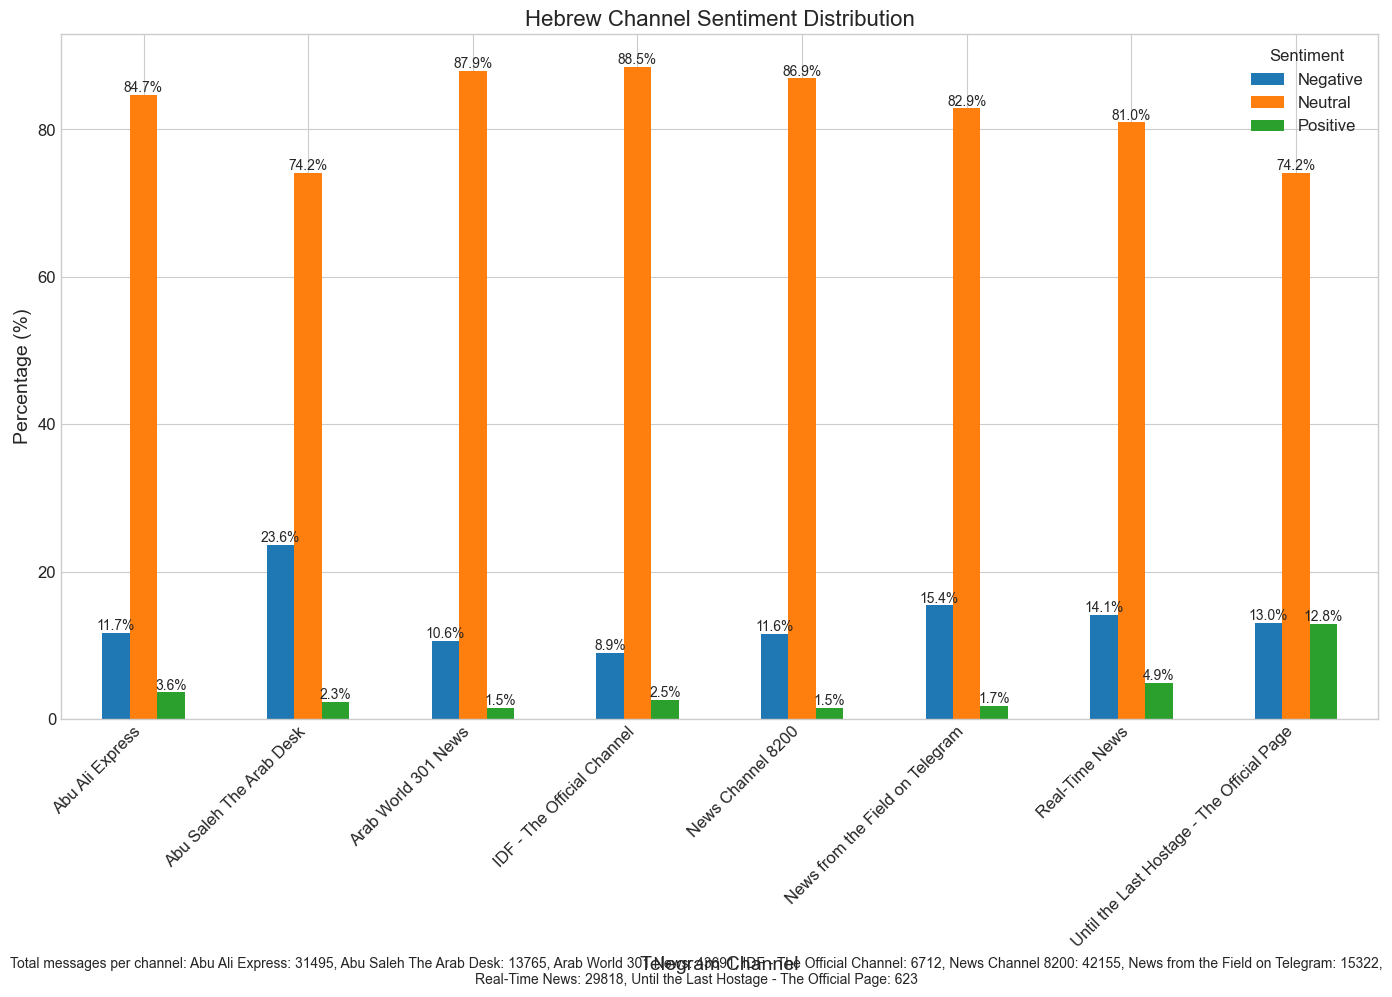

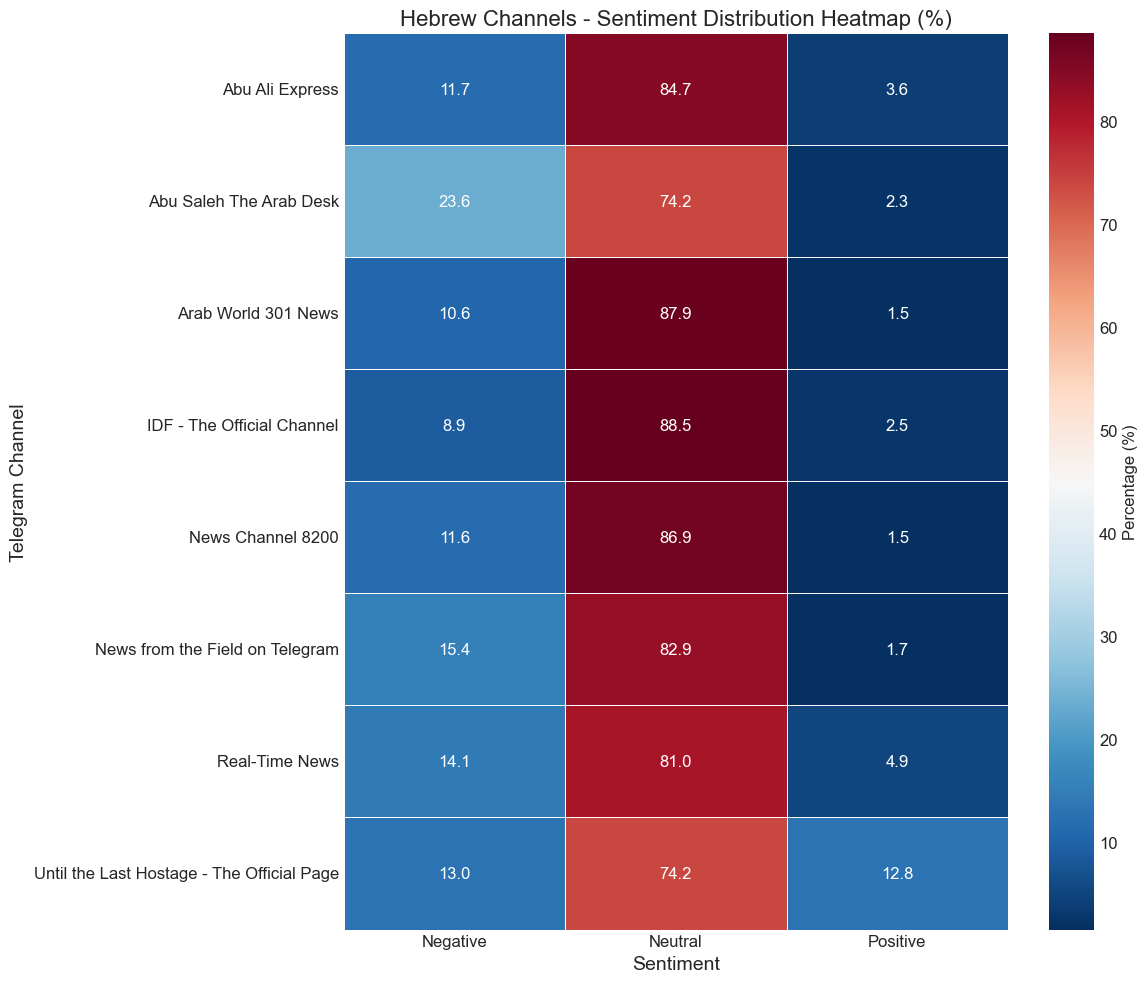

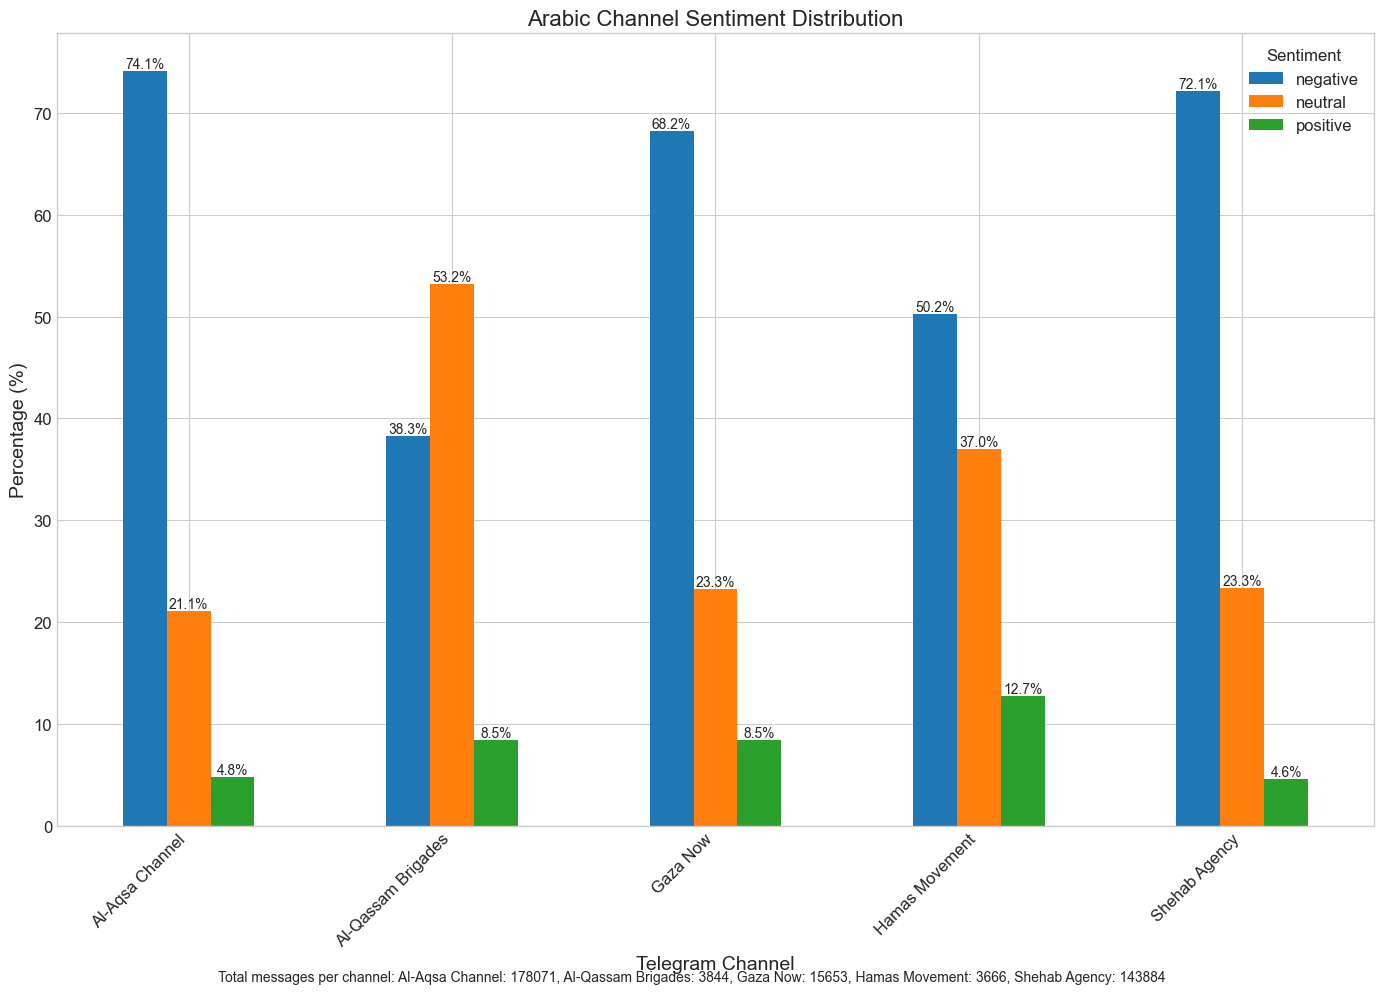

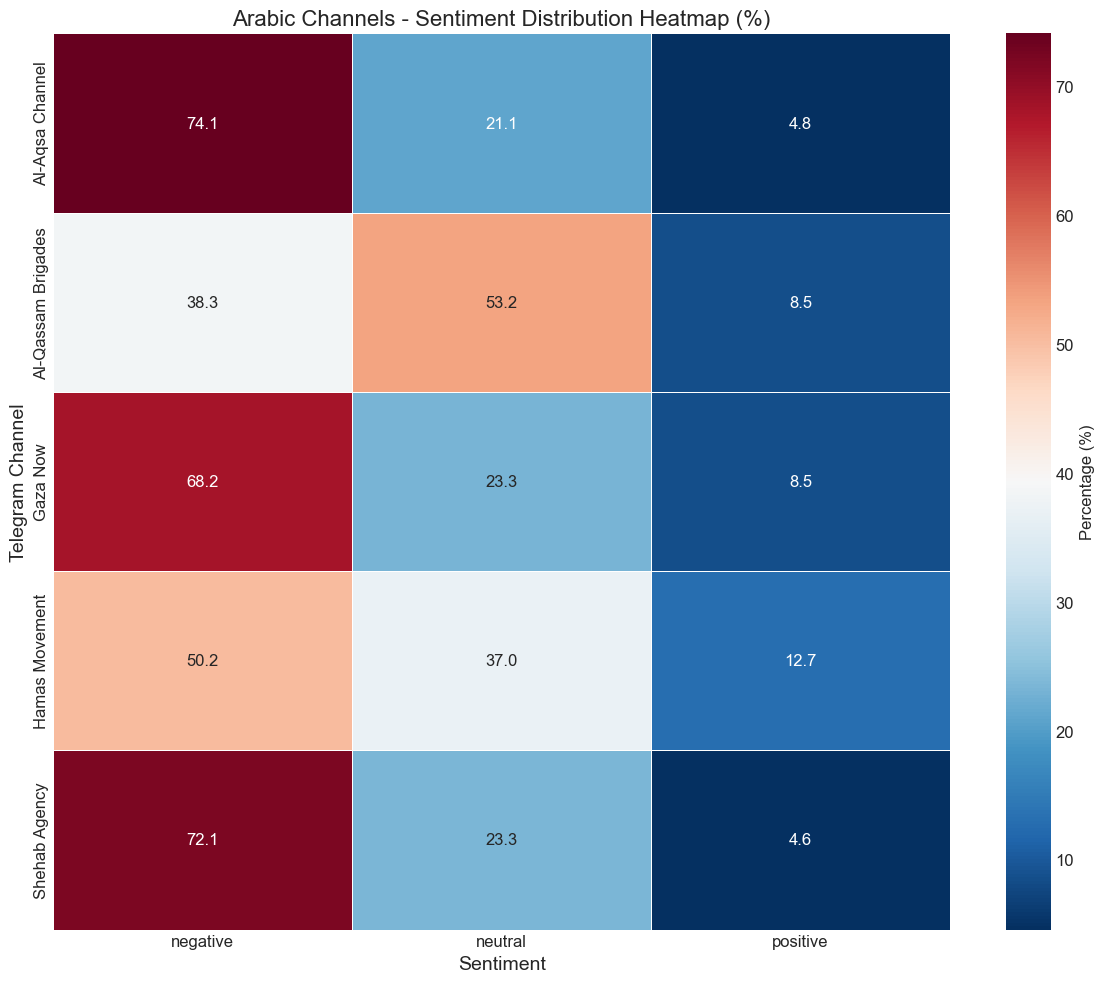


Hebrew Sentiment Distribution by Group (%):
sentiment_label                             Negative  Neutral  Positive
group_title                                                            
Abu Ali Express                                 11.7     84.7       3.6
Abu Saleh The Arab Desk                         23.6     74.2       2.3
Arab World 301 News                             10.6     87.9       1.5
IDF - The Official Channel                       8.9     88.5       2.5
News Channel 8200                               11.6     86.9       1.5
News from the Field on Telegram                 15.4     82.9       1.7
Real-Time News                                  14.1     81.0       4.9
Until the Last Hostage - The Official Page      13.0     74.2      12.8

Arabic Sentiment Distribution by Group (%):
sentiment_label     negative  neutral  positive
group_title                                    
Al-Aqsa Channel         74.1     21.1       4.8
Al-Qassam Brigades      38.3     53.2       8.

In [58]:
# Execute for Hebrew dataset
hebrew_sentiment_props = plot_sentiment_distribution_by_group(df_hebrew_sentiment, "Hebrew")
hebrew_heatmap = plot_sentiment_heatmap(df_hebrew_sentiment, "Hebrew")

# Execute for Arabic dataset
arabic_sentiment_props = plot_sentiment_distribution_by_group(df_arabic_sentiment, "Arabic")
arabic_heatmap = plot_sentiment_heatmap(df_arabic_sentiment, "Arabic")

# Display numeric breakdown for clear interpretation
print("\nHebrew Sentiment Distribution by Group (%):")
print(hebrew_sentiment_props.round(1))

print("\nArabic Sentiment Distribution by Group (%):")
print(arabic_sentiment_props.round(1))


# Aggregation and Comparison with Other Metadata

   - Compare sentiment with other metadata (e.g., `reactions`, `emoji_count`, `views`).
   - Aggregate sentiment by group (using `group_name` or `group_title`) to analyze sentiment trends across Telegram groups.

In [41]:
def aggregate_sentiment_by_group(df, group_col='group_name', sentiment_col='sentiment_label',
                                metric_cols=None):
    """
    Aggregate sentiment data by group, identifying the top sentiment label for each group
    along with its frequency and percentage.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing sentiment data
    group_col : str, default='group_name'
        Column name to group by (e.g., 'group_name', 'channel_id')
    sentiment_col : str, default='sentiment_label'
        Column name containing sentiment labels
    metric_cols : list, default=None
        Additional numerical columns to aggregate (mean) by group

    Returns:
    --------
    pandas.DataFrame
        Aggregated statistics by group
    """
    # Count occurrences of each sentiment label by group
    label_counts = df.groupby([group_col, sentiment_col]).size().reset_index(name='count')

    # Find the most frequent label for each group
    idx = label_counts.groupby(group_col)['count'].idxmax()
    top_sentiments = label_counts.loc[idx, [group_col, sentiment_col, 'count']]
    top_sentiments.columns = [group_col, 'top_sentiment_label', 'frequency']

    # Calculate total records per group
    group_totals = df.groupby(group_col).size().reset_index(name='total_records')

    # Add total records and calculate percentage
    top_sentiments = top_sentiments.merge(group_totals, on=group_col)
    top_sentiments['percentage'] = (top_sentiments['frequency'] / top_sentiments['total_records'] * 100).round(2)

    # Get other metrics if requested
    if metric_cols:
        other_metrics = df.groupby(group_col)[metric_cols].mean().reset_index()
        # Combine the results
        result = top_sentiments.merge(other_metrics, on=group_col)
    else:
        result = top_sentiments

    return result

In [45]:
# For Hebrew dataset
grouped_hebrew = aggregate_sentiment_by_group(
    df_hebrew_sentiment,
    metric_cols=['emoji_count', 'views']
)

grouped_hebrew

,group_name,top_sentiment_label,frequency,total_records,percentage,emoji_count,views
0,ForumPressReleases,Neutral,462,623,74.16,0.634029,393.402889
1,New_security8200,Neutral,36641,42155,86.92,0.897782,6650.857668
2,Realtimesecurity1,Neutral,24141,29818,80.96,0.942048,10348.451942
3,abualiexpress,Neutral,26689,31495,84.74,0.449341,126874.762788
4,arabworld301news,Neutral,38426,43691,87.95,0.106544,18382.571628
5,idf_telegram,Neutral,5941,6712,88.51,0.001341,19643.195322
6,salehdesk1,Neutral,10207,13765,74.15,0.295895,46898.105485
7,yediotnews,Neutral,12697,15322,82.87,0.297220,124997.650241


In [47]:
# For Arabic dataset
grouped_arabic = aggregate_sentiment_by_group(
    df_arabic_sentiment,
    metric_cols=['emoji_count', 'views']
)

grouped_arabic

,group_name,top_sentiment_label,frequency,total_records,percentage,emoji_count,views
0,SerajSat,negative,131945,178071,74.10,0.362934,18626.322568
1,ShehabTelegram,negative,103770,143884,72.12,0.322684,10961.204936
2,gazaalannet,negative,10677,15653,68.21,0.628825,215596.136012
3,hamasps,negative,1842,3666,50.25,1.022640,24641.578833
4,qassambrigades,neutral,2045,3844,53.20,0.069719,193141.117846


In [49]:
def extract_top_emojis_by_group(df, group_col='group_name', reactions_col='reactions', top_n=3):
    """
    Extract the top N emojis for each group based on reaction counts.
    """
    # Initialize dictionary to store emoji counts by group
    emoji_counts_by_group = {}

    # Iterate through each row in the DataFrame
    for _, row in df.iterrows():
        group = row[group_col]
        reactions_data = row[reactions_col]

        # Skip if reactions is None
        if pd.isna(reactions_data):
            continue

        # Parse reactions data if it's a string
        reactions_list = []
        if isinstance(reactions_data, str):
            try:
                # Try parsing as JSON
                reactions_list = json.loads(reactions_data.replace("'", '"'))
            except json.JSONDecodeError:
                try:
                    # Try parsing as Python literal
                    reactions_list = ast.literal_eval(reactions_data)
                except (SyntaxError, ValueError):
                    continue
        elif isinstance(reactions_data, list):
            reactions_list = reactions_data

        # Initialize the group in the dictionary if not already present
        if group not in emoji_counts_by_group:
            emoji_counts_by_group[group] = {}

        # Update emoji counts for this group
        for reaction in reactions_list:
            if isinstance(reaction, dict) and 'emoji' in reaction and 'count' in reaction:
                emoji = reaction['emoji']
                count = reaction['count']

                if emoji not in emoji_counts_by_group[group]:
                    emoji_counts_by_group[group][emoji] = 0
                emoji_counts_by_group[group][emoji] += count

    # Convert the dictionary to a DataFrame
    results = []
    for group, emoji_counts in emoji_counts_by_group.items():
        if emoji_counts:  # Only include groups with emoji data
            # Sort emojis by count and take top N
            top_emojis = sorted(emoji_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

            # Create a record for this group
            record = {
                group_col: group,
                'top_emojis': [{'emoji': emoji, 'count': count} for emoji, count in top_emojis],
                'top_emojis_formatted': ', '.join([f"{emoji} ({count})" for emoji, count in top_emojis])
            }
            results.append(record)

    return pd.DataFrame(results)

def combine_sentiment_and_emoji_data(sentiment_df, df_with_reactions, group_col='group_name'):
    """
    Combine sentiment aggregation data with top emoji data.
    """
    # Extract top emojis
    emoji_df = extract_top_emojis_by_group(df_with_reactions, group_col=group_col)

    # Merge with sentiment data
    combined_df = sentiment_df.merge(emoji_df, on=group_col, how='left')

    return combined_df

In [ ]:
# For Hebrew dataset
hebrew_with_emojis = combine_sentiment_and_emoji_data(
    grouped_hebrew,
    df_hebrew_sentiment
)

In [52]:
# Display the combined results
print("Hebrew groups with sentiment and top emojis:")
hebrew_with_emojis

Hebrew groups with sentiment and top emojis:


,group_name,top_sentiment_label,frequency,total_records,percentage,emoji_count,views,top_emojis,top_emojis_formatted
0,ForumPressReleases,Neutral,462,623,74.16,0.634029,393.402889,"[{'emoji': '🥰', 'count': 1475}, {'emoji': '💔',...","🥰 (1475), 💔 (1420), 🙏 (1393)"
1,New_security8200,Neutral,36641,42155,86.92,0.897782,6650.857668,"[{'emoji': '👍', 'count': 206318}, {'emoji': '🔥...","👍 (206318), 🔥 (191722), ❤ (109199)"
2,Realtimesecurity1,Neutral,24141,29818,80.96,0.942048,10348.451942,"[{'emoji': '👍', 'count': 343296}, {'emoji': '🔥...","👍 (343296), 🔥 (210778), 🤬 (202440)"
3,abualiexpress,Neutral,26689,31495,84.74,0.449341,126874.762788,"[{'emoji': '🔥', 'count': 16979231}, {'emoji': ...","🔥 (16979231), 😁 (15158507), 👍 (13156219)"
4,arabworld301news,Neutral,38426,43691,87.95,0.106544,18382.571628,"[{'emoji': '👍', 'count': 1098853}, {'emoji': '...","👍 (1098853), 🔥 (1087615), 🤬 (644426)"
5,idf_telegram,Neutral,5941,6712,88.51,0.001341,19643.195322,"[{'emoji': '🫡', 'count': 98060}, {'emoji': '👍'...","🫡 (98060), 👍 (93377), ❤ (73813)"
6,salehdesk1,Neutral,10207,13765,74.15,0.295895,46898.105485,"[{'emoji': '👍', 'count': 2181382}, {'emoji': '...","👍 (2181382), 🔥 (1498529), ❤ (1069418)"
7,yediotnews,Neutral,12697,15322,82.87,0.297220,124997.650241,"[{'emoji': '👍', 'count': 3021416}, {'emoji': '...","👍 (3021416), ❤ (2092016), 💔 (1504851)"


In [ ]:
# For Arabic dataset
arabic_with_emojis = combine_sentiment_and_emoji_data(
    grouped_arabic,
    df_arabic_sentiment
)

In [54]:
print("\nArabic groups with sentiment and top emojis:")
arabic_with_emojis


Arabic groups with sentiment and top emojis:


,group_name,top_sentiment_label,frequency,total_records,percentage,emoji_count,views,top_emojis,top_emojis_formatted
0,SerajSat,negative,131945,178071,74.10,0.362934,18626.322568,"[{'emoji': '😢', 'count': 6475839}, {'emoji': '...","😢 (6475839), 🔥 (4659803), ❤ (3712099)"
1,ShehabTelegram,negative,103770,143884,72.12,0.322684,10961.204936,"[{'emoji': '❤', 'count': 1882314}, {'emoji': '...","❤ (1882314), 🔥 (1543953), 😢 (1399322)"
2,gazaalannet,negative,10677,15653,68.21,0.628825,215596.136012,"[{'emoji': '❤', 'count': 13185387}, {'emoji': ...","❤ (13185387), 😢 (7659408), 👍 (5974501)"
3,hamasps,negative,1842,3666,50.25,1.022640,24641.578833,NaN,NaN
4,qassambrigades,neutral,2045,3844,53.20,0.069719,193141.117846,"[{'emoji': '🫡', 'count': 29223914}, {'emoji': ...","🫡 (29223914), ❤ (7516253), 🔥 (2764831)"


In [73]:
# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Set font that better supports emoji
# Windows
plt.rcParams['font.family'] = 'Segoe UI Emoji'

# VISUALIZATION FUNCTIONS

def visualize_sentiment_by_group(sentiment_df, language="Hebrew"):
    """
    Create visualizations of sentiment distribution by group.

    Parameters:
    -----------
    sentiment_df : pandas.DataFrame
        Aggregated sentiment data by group
    language : str
        Language of the dataset for plot titles
    """
    # Sort by percentage in descending order
    sorted_df = sentiment_df.sort_values('percentage', ascending=False)

    # Create a color map based on sentiment
    sentiment_colors = {
        'Positive': 'green', 'positive': 'green',
        'Neutral': 'blue', 'neutral': 'blue',
        'Negative': 'red', 'negative': 'red'
    }

    # Apply colors to each group based on top sentiment
    colors = [sentiment_colors.get(sentiment, 'gray') for sentiment in sorted_df['top_sentiment_label']]

    # Plot 1: Horizontal bar chart with dominant sentiment and percentage
    plt.figure(figsize=(12, max(8, len(sorted_df) * 0.5)))

    bars = plt.barh(sorted_df[sorted_df.columns[0]], sorted_df['percentage'], color=colors, alpha=0.7)

    # Add percentage and sentiment labels
    for i, bar in enumerate(bars):
        group = sorted_df.iloc[i][sorted_df.columns[0]]
        sentiment = sorted_df.iloc[i]['top_sentiment_label']
        percentage = sorted_df.iloc[i]['percentage']
        total = sorted_df.iloc[i]['total_records']

        plt.text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height()/2,
            f"{sentiment} ({percentage:.1f}%, n={total:,})",
            va='center'
        )

    plt.xlabel('Percentage of Messages (%)')
    plt.ylabel('Telegram Channel')
    plt.title(f'{language} Channels - Dominant Sentiment Distribution')
    plt.xlim(0, max(sorted_df['percentage']) * 1.3)  # Add space for labels
    plt.tight_layout()
    plt.show()

    # Plot 2: Scatter plot comparing total message count vs. dominant sentiment percentage
    plt.figure(figsize=(12, 8))

    for sentiment in set(sorted_df['top_sentiment_label']):
        subset = sorted_df[sorted_df['top_sentiment_label'] == sentiment]
        plt.scatter(
            subset['total_records'],
            subset['percentage'],
            label=sentiment,
            color=sentiment_colors.get(sentiment, 'gray'),
            s=100,
            alpha=0.7
        )

    # Add labels for each point
    for i, row in sorted_df.iterrows():
        plt.annotate(
            row[sorted_df.columns[0]],
            (row['total_records'], row['percentage']),
            xytext=(7, 0),
            textcoords='offset points',
            fontsize=9
        )

    plt.xscale('log')  # Use log scale for better visualization if range is wide
    plt.xlabel('Total Messages (log scale)')
    plt.ylabel('Percentage of Dominant Sentiment (%)')
    plt.title(f'{language} Channels - Message Volume vs. Sentiment Dominance')
    plt.legend(title='Dominant Sentiment')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # If there are numeric metric columns, visualize their relation to sentiment
    metric_cols = [col for col in sentiment_df.columns
                  if col not in [sentiment_df.columns[0], 'top_sentiment_label', 'frequency',
                                'total_records', 'percentage', 'top_emojis', 'top_emojis_formatted']]

    if metric_cols:
        # Plot 3: Multiple bar charts for metrics by group
        fig, axes = plt.subplots(len(metric_cols), 1, figsize=(12, 4 * len(metric_cols)))
        if len(metric_cols) == 1:
            axes = [axes]  # Make it iterable if only one subplot

        for i, metric in enumerate(metric_cols):
            ax = axes[i]
            metric_data = sorted_df.sort_values(metric, ascending=False)

            bars = ax.barh(metric_data[metric_data.columns[0]], metric_data[metric], alpha=0.7)

            ax.set_title(f'Average {metric} by Channel')
            ax.set_xlabel(f'Average {metric}')
            ax.set_ylabel('Telegram Channel')

            # Color bars by top sentiment
            for j, bar in enumerate(bars):
                sentiment = metric_data.iloc[j]['top_sentiment_label']
                bar.set_color(sentiment_colors.get(sentiment, 'gray'))

        plt.tight_layout()
        plt.show()

        # Plot 4: Scatter plots of metrics vs. sentiment percentage
        for metric in metric_cols:
            plt.figure(figsize=(10, 6))

            for sentiment in set(sorted_df['top_sentiment_label']):
                subset = sorted_df[sorted_df['top_sentiment_label'] == sentiment]
                plt.scatter(
                    subset[metric],
                    subset['percentage'],
                    label=sentiment,
                    color=sentiment_colors.get(sentiment, 'gray'),
                    s=80,
                    alpha=0.7
                )

            # Add regression line for overall trend
            if len(sorted_df) > 2:  # Need at least 3 points for meaningful regression
                m, b = np.polyfit(sorted_df[metric], sorted_df['percentage'], 1)
                plt.plot(
                    sorted_df[metric],
                    m * sorted_df[metric] + b,
                    '-',
                    color='black',
                    alpha=0.5,
                    label=f'Trend (slope={m:.2f})'
                )

            # Add labels for each point
            for i, row in sorted_df.iterrows():
                plt.annotate(
                    row[sorted_df.columns[0]],
                    (row[metric], row['percentage']),
                    xytext=(7, 0),
                    textcoords='offset points',
                    fontsize=9
                )

            plt.xlabel(f'Average {metric}')
            plt.ylabel('Percentage of Dominant Sentiment (%)')
            plt.title(f'{language} - Relationship Between {metric} and Dominant Sentiment')
            plt.legend(title='Dominant Sentiment')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

def visualize_emoji_sentiment_relationship(combined_df, df_original, language="Hebrew"):
    """
    Visualize the relationship between top emojis and sentiment across groups.

    Parameters:
    -----------
    combined_df : pandas.DataFrame
        Combined dataframe with sentiment and emoji data
    df_original : pandas.DataFrame
        Original dataframe with full message data
    language : str
        Language of the dataset for plot titles
    """
    if 'top_emojis' not in combined_df.columns:
        print("No emoji data found in the combined dataframe.")
        return

    # 1. Create a visualization of top emojis by group with sentiment coloring
    plt.figure(figsize=(14, 10))

    # Extract emoji counts for visualization
    emoji_data = []

    for _, row in combined_df.iterrows():
        if pd.isna(row.get('top_emojis_formatted')):
            continue

        group = row[combined_df.columns[0]]
        sentiment = row['top_sentiment_label']
        emojis = row['top_emojis']

        if isinstance(emojis, str):
            try:
                emojis = ast.literal_eval(emojis)
            except:
                continue

        if not isinstance(emojis, list):
            continue

        for i, emoji_info in enumerate(emojis):
            if not isinstance(emoji_info, dict):
                continue

            emoji = emoji_info.get('emoji', '')
            count = emoji_info.get('count', 0)

            if emoji and count:
                emoji_data.append({
                    'group': group,
                    'sentiment': sentiment,
                    'emoji': emoji,
                    'count': count,
                    'rank': i + 1  # 1-based rank
                })

    if not emoji_data:
        print("Could not parse emoji data for visualization.")
        return

    emoji_df = pd.DataFrame(emoji_data)

    # Filter to top 10 groups by total emoji count for readability
    group_total_counts = emoji_df.groupby('group')['count'].sum().sort_values(ascending=False)
    top_groups = group_total_counts.head(10).index.tolist()
    filtered_emoji_df = emoji_df[emoji_df['group'].isin(top_groups)]

    # Plot 1: Stacked bar chart of emoji counts by group
    plt.figure(figsize=(14, 10))

    # Create pivot table for plotting
    pivot_data = filtered_emoji_df.pivot_table(
        index='group',
        columns='emoji',
        values='count',
        aggfunc='sum',
        fill_value=0
    )

    # Sort by total count
    pivot_data = pivot_data.loc[pivot_data.sum(axis=1).sort_values(ascending=False).index]

    # Plot stacked bars
    pivot_data.plot(kind='barh', stacked=True, figsize=(14, 10))

    plt.title(f'Top Emojis by Channel in {language} Channels', fontsize=16)
    plt.xlabel('Count (log scale)', fontsize=14)
    plt.ylabel('Telegram Channel', fontsize=14)
    plt.xscale('log')  # Log scale to better see distribution
    plt.legend(title='Emoji', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Plot 2: Emoji usage by sentiment
    if df_original is not None and 'emoji_count' in df_original.columns:
        # Analyze the relationship between emoji usage and sentiment
        sentiment_col = 'sentiment_label'
        df_original['has_emoji'] = df_original['emoji_count'] > 0

        # Prepare data for plotting
        emoji_sentiment_counts = df_original.groupby(['has_emoji', sentiment_col]).size().unstack(fill_value=0)
        emoji_sentiment_props = emoji_sentiment_counts.div(emoji_sentiment_counts.sum(axis=1), axis=0) * 100

        # Plot sentiment distribution by emoji presence
        plt.figure(figsize=(12, 8))

        ax = emoji_sentiment_props.plot(kind='bar')
        plt.title(f'{language} - Sentiment Distribution by Emoji Presence', fontsize=16)
        plt.xlabel('Contains Emojis', fontsize=14)
        plt.ylabel('Percentage (%)', fontsize=14)
        plt.xticks([0, 1], ['No Emoji', 'Has Emoji'], rotation=0)
        plt.legend(title='Sentiment', fontsize=12)

        # Add percentage labels
        for container in ax.containers:
            ax.bar_label(container, fmt='%.1f%%', fontsize=10)

        plt.tight_layout()
        plt.show()

        # Print sample sizes
        print(f"\n{language} - Messages with and without emojis:")
        print(emoji_sentiment_counts.sum(axis=1).to_string())

    # Plot 3: Heat Map of Top Emojis by Group and their Sentiment
    # Extract most common emojis
    top_10_emojis = filtered_emoji_df.groupby('emoji')['count'].sum().sort_values(ascending=False).head(10).index.tolist()

    # Create a cross-tabulation of groups, emojis, and sentiment
    rows_list = []
    for group in top_groups:
        for emoji in top_10_emojis:
            # Get the dominant sentiment for this group
            group_sentiment = combined_df[combined_df[combined_df.columns[0]] == group]['top_sentiment_label'].iloc[0] \
                              if not combined_df[combined_df[combined_df.columns[0]] == group].empty else "Unknown"

            # Get count for this emoji in this group
            count = filtered_emoji_df[(filtered_emoji_df['group'] == group) &
                                     (filtered_emoji_df['emoji'] == emoji)]['count'].sum()

            rows_list.append({
                'group': group,
                'emoji': emoji,
                'sentiment': group_sentiment,
                'count': count
            })

    # Create DataFrame from the rows
    sentiment_emoji_matrix = pd.DataFrame(rows_list)

    # Create a pivot table for the heatmap
    heatmap_data = sentiment_emoji_matrix.pivot_table(
        index='group',
        columns='emoji',
        values='count',
        aggfunc='sum',
        fill_value=0
    )

    # Create a heatmap
    plt.figure(figsize=(14, 10))

    # Use log scale for better visualization of wide range of values
    sns.heatmap(
        np.log1p(heatmap_data),  # log(1+x) to handle zeros
        cmap='YlOrRd',
        annot=heatmap_data.values,  # Show original values
        fmt='g',
        linewidths=0.5
    )

    plt.title(f'Emoji Usage Heatmap Across {language} Channels (log scale colors, raw counts shown)', fontsize=16)
    plt.ylabel('Telegram Channel', fontsize=14)
    plt.xlabel('Emoji', fontsize=14)
    plt.tight_layout()
    plt.show()

# how to use these visualization functions
def visualize_sentiment_and_metadata(df_sentiment, language,
                                     combined_data=None):
    """
    Comprehensive function to analyze and visualize sentiment with metadata.

    Parameters:
    -----------
    df_sentiment : pandas.DataFrame
        DataFrame containing sentiment data
    language : str
        Language of the dataset for plot titles
    """
    print(f"Analyzing {language} sentiment data and metadata...")

    # 1. Aggregate sentiment by group with emoji_count and views as metrics
    metric_cols = ['emoji_count', 'views', 'forward_count']
    available_metrics = [col for col in metric_cols if col in df_sentiment.columns]

    sentiment_by_group = aggregate_sentiment_by_group(
        df_sentiment,
        group_col='group_title',
        sentiment_col='sentiment_label',
        metric_cols=available_metrics
    )

    # 2. Extract emoji data and combine with sentiment data
    combined_data = combine_sentiment_and_emoji_data(
        sentiment_by_group,
        df_sentiment,
        group_col='group_title'
    )

    # 3. Visualize the aggregated sentiment data
    visualize_sentiment_by_group(combined_data, language=language)

    # 4. Visualize the relationship between emojis and sentiment
    visualize_emoji_sentiment_relationship(combined_data, df_sentiment, language=language)

    # return combined_data

Analyzing Hebrew sentiment data and metadata...


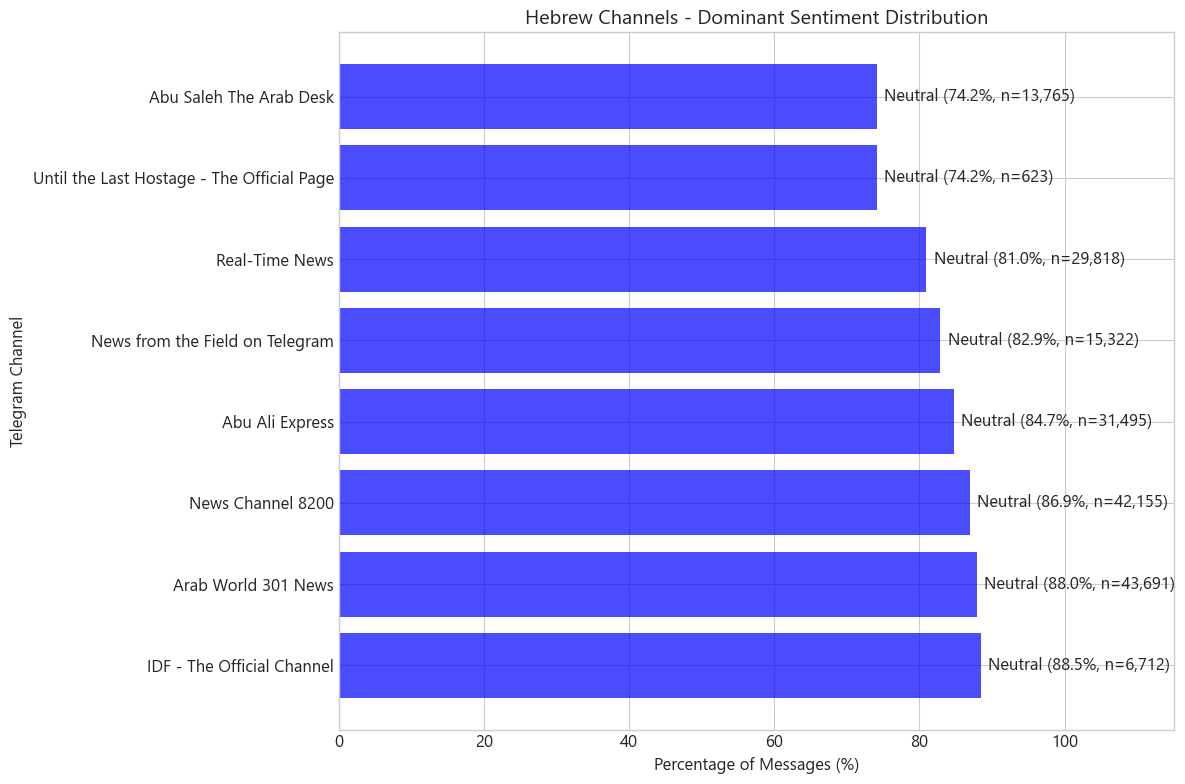

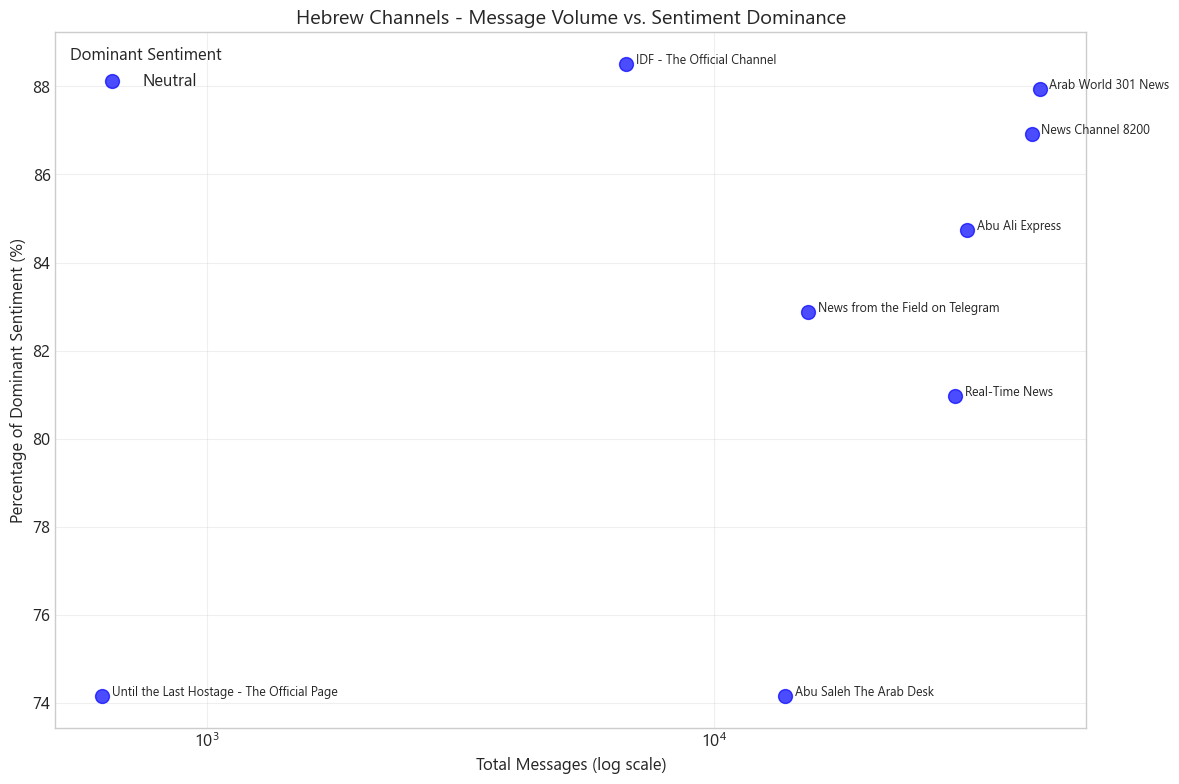

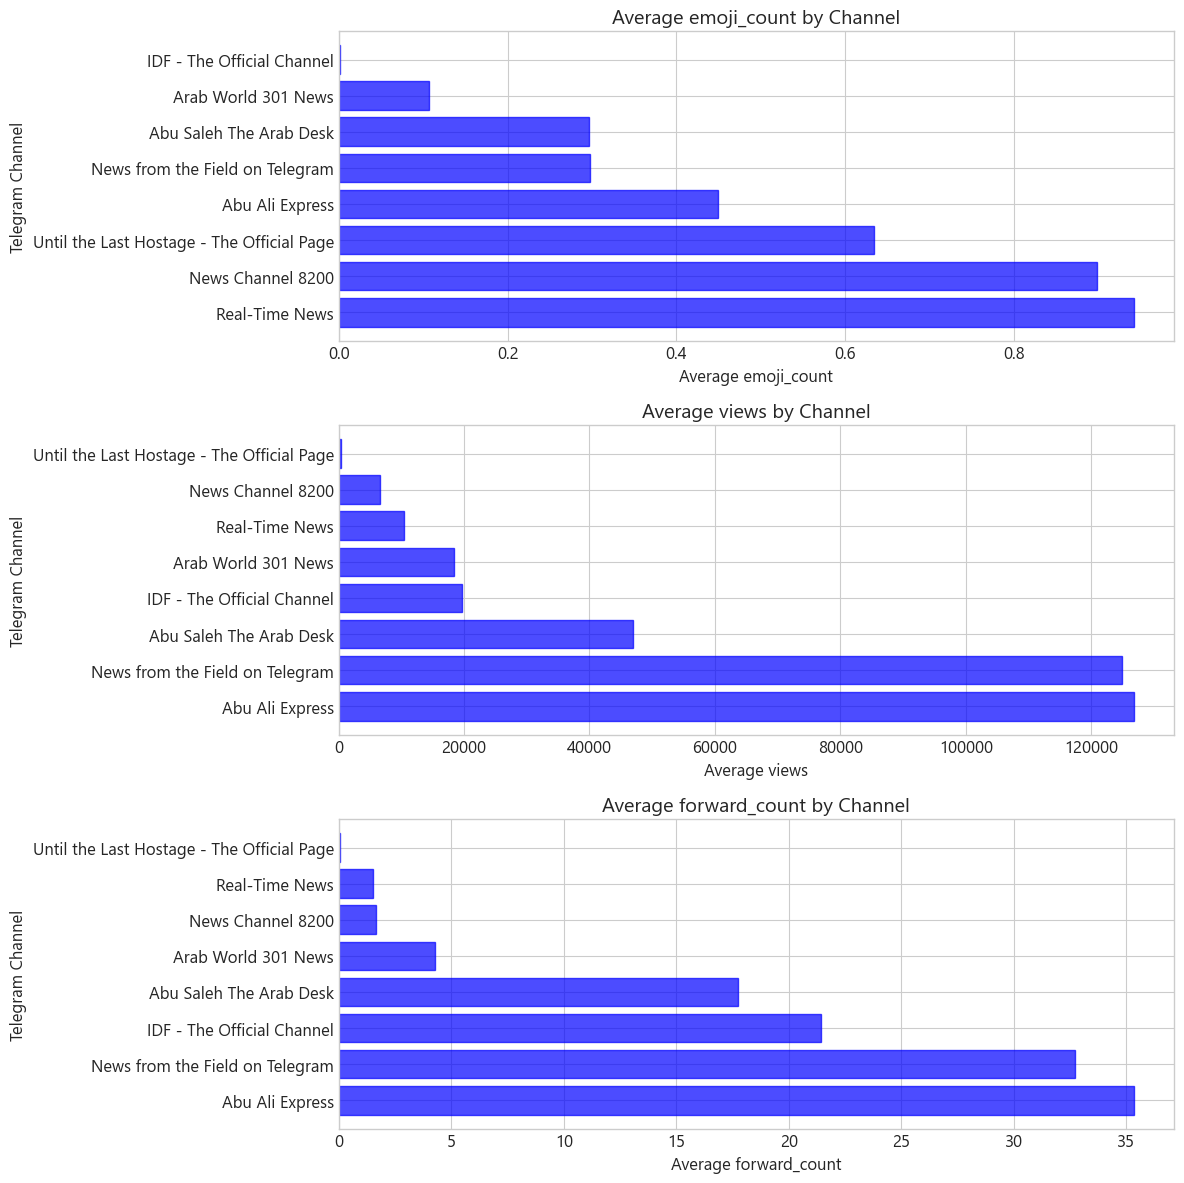

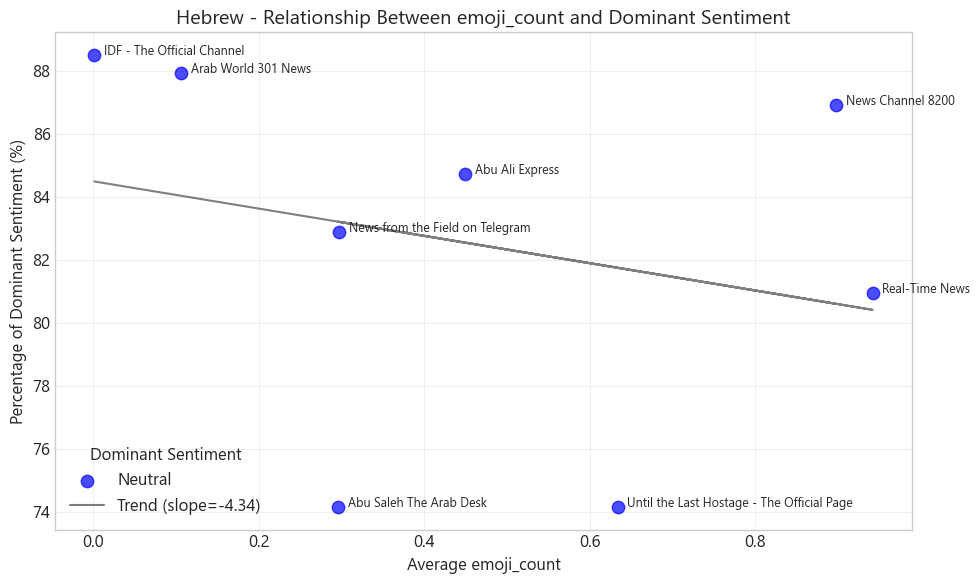

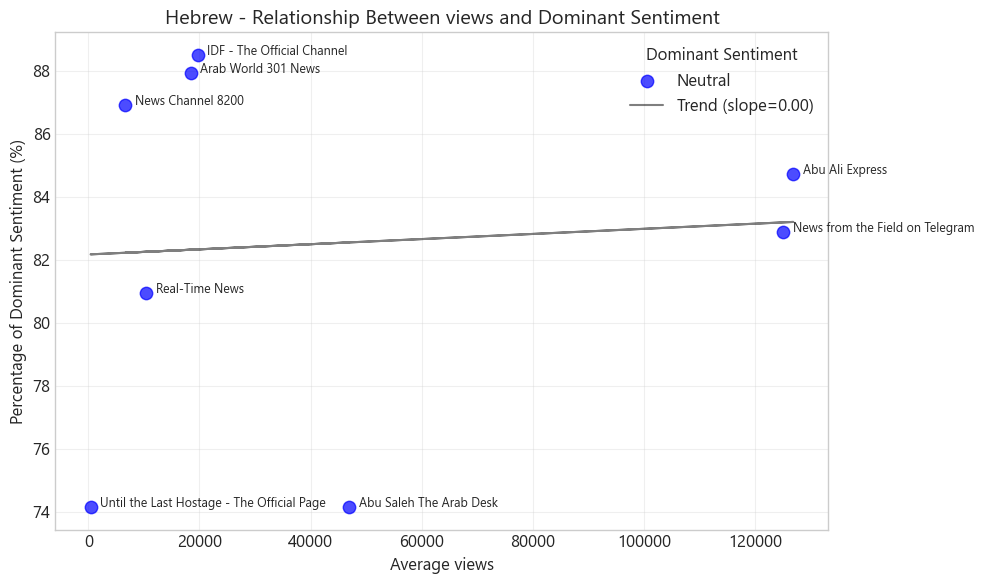

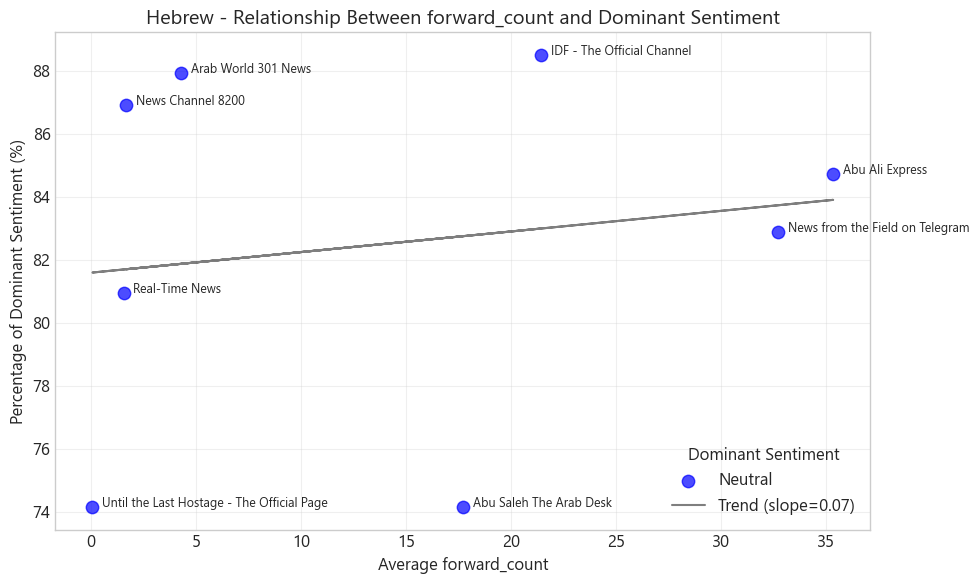

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

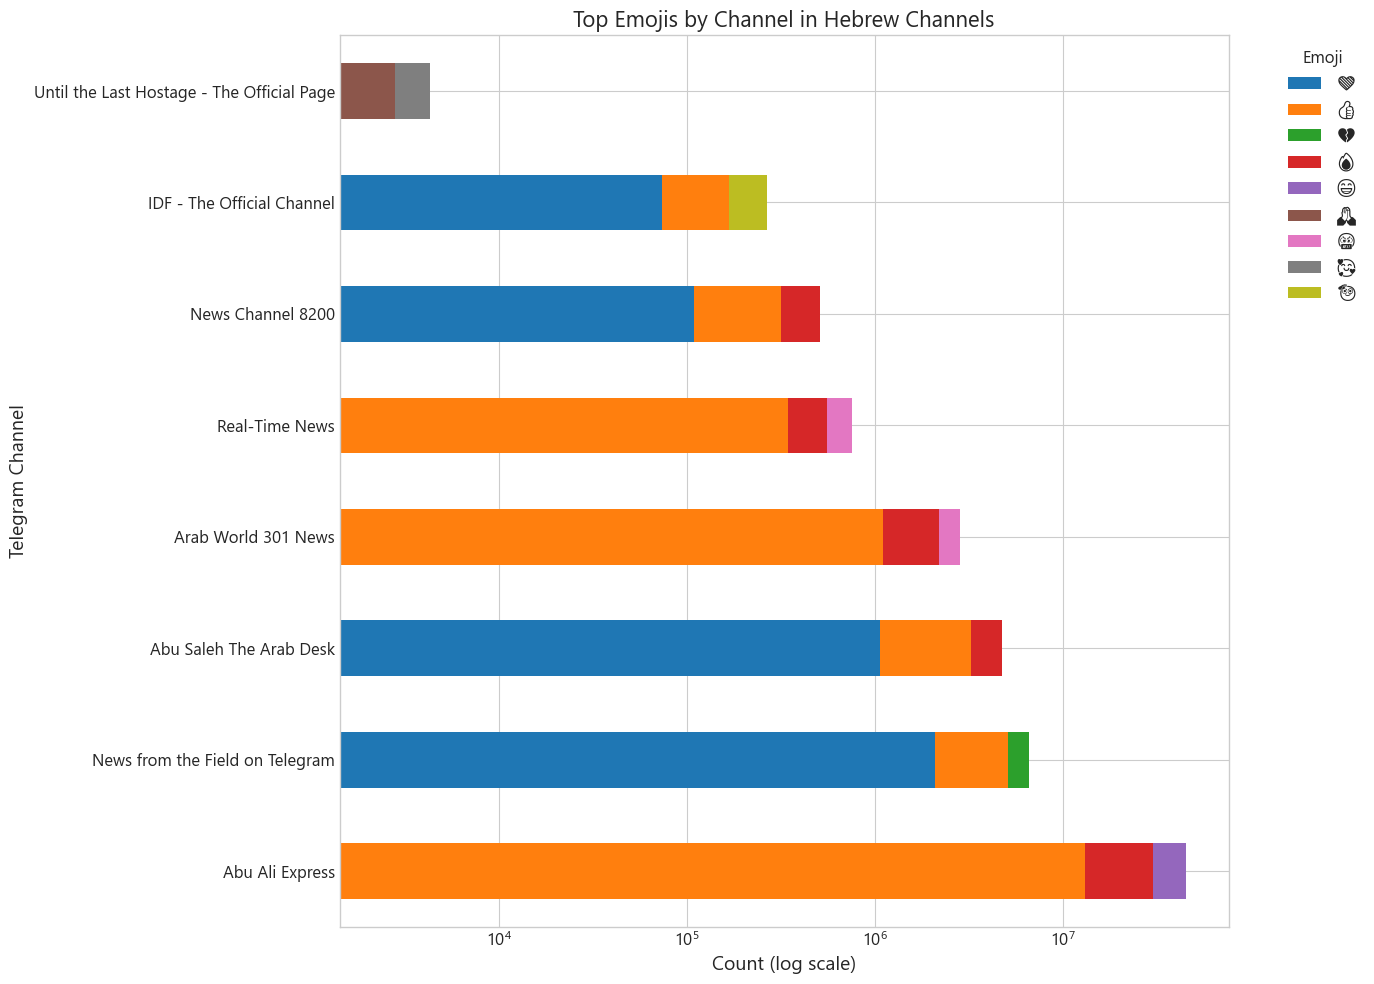

<Figure size 1200x800 with 0 Axes>

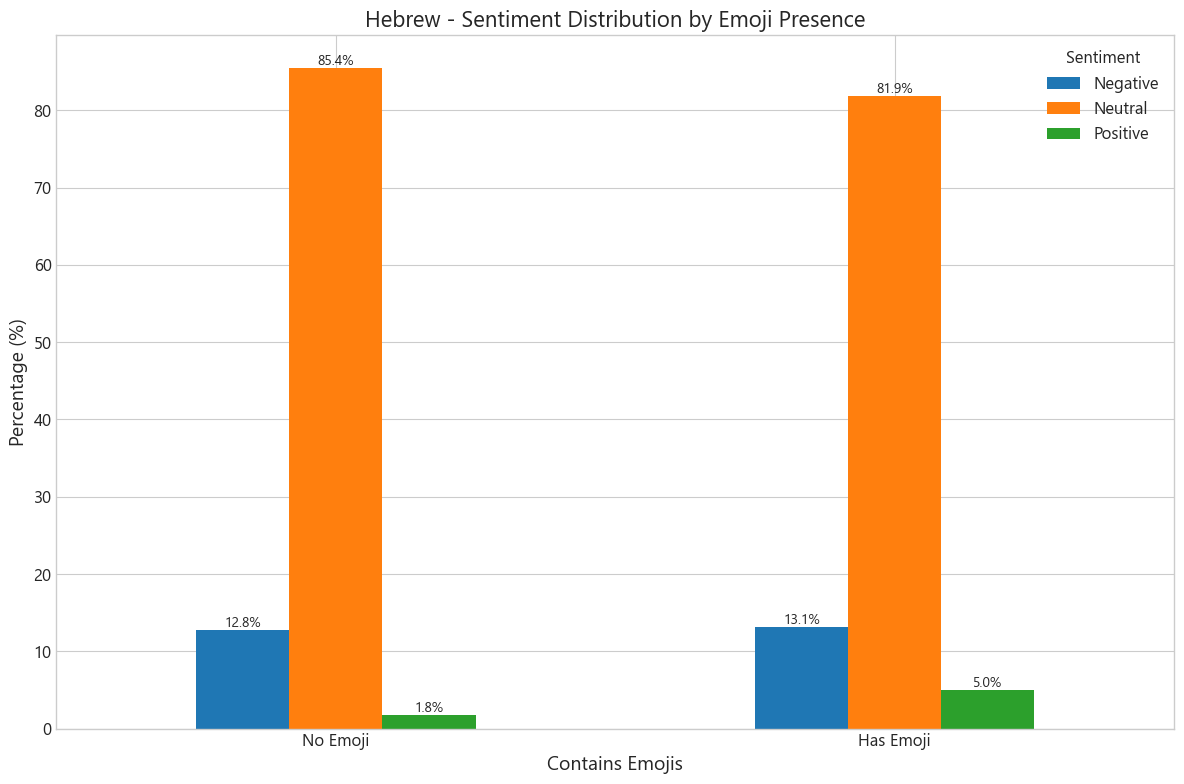


Hebrew - Messages with and without emojis:
has_emoji
False    137426
True      46155


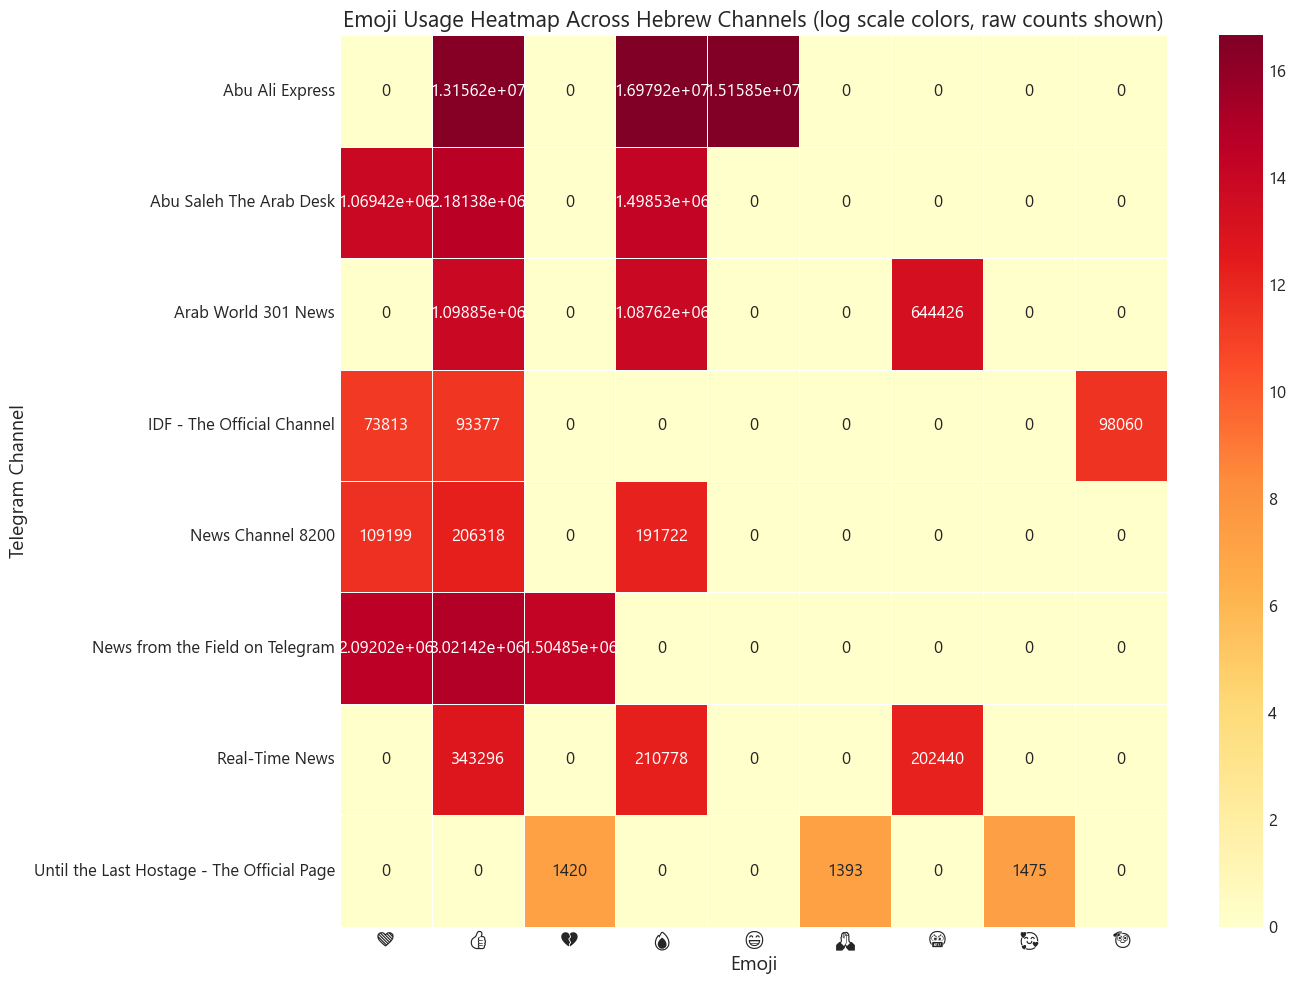

In [74]:
# Run the visualization for Hebrew data
hebrew_combined_data = visualize_sentiment_and_metadata(df_hebrew_sentiment, language="Hebrew",
                                                        combined_data=hebrew_with_emojis)

Analyzing Arabic sentiment data and metadata...


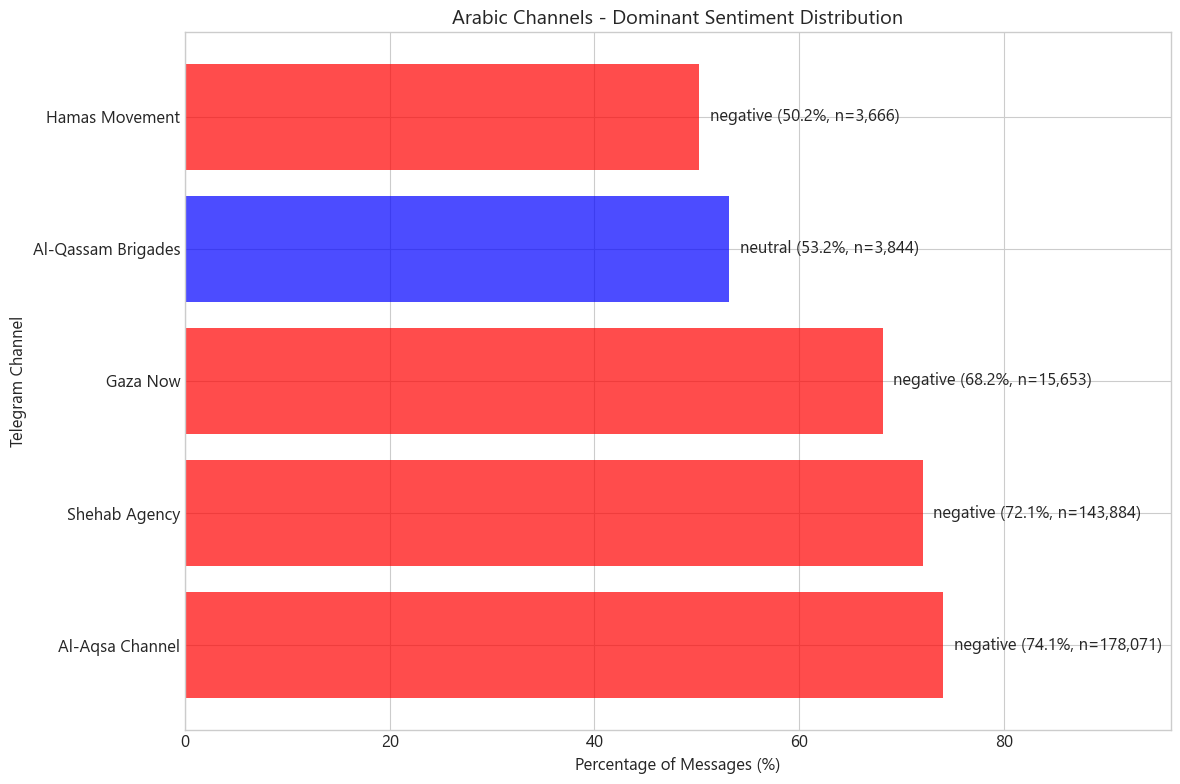

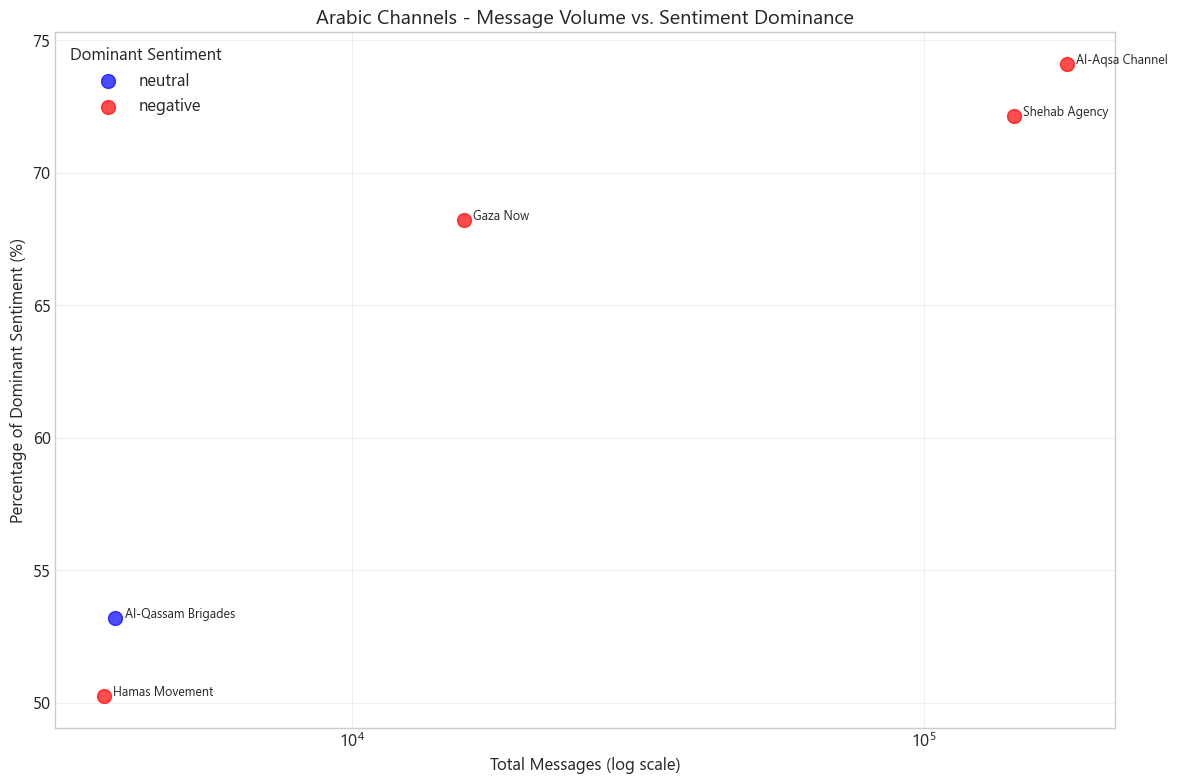

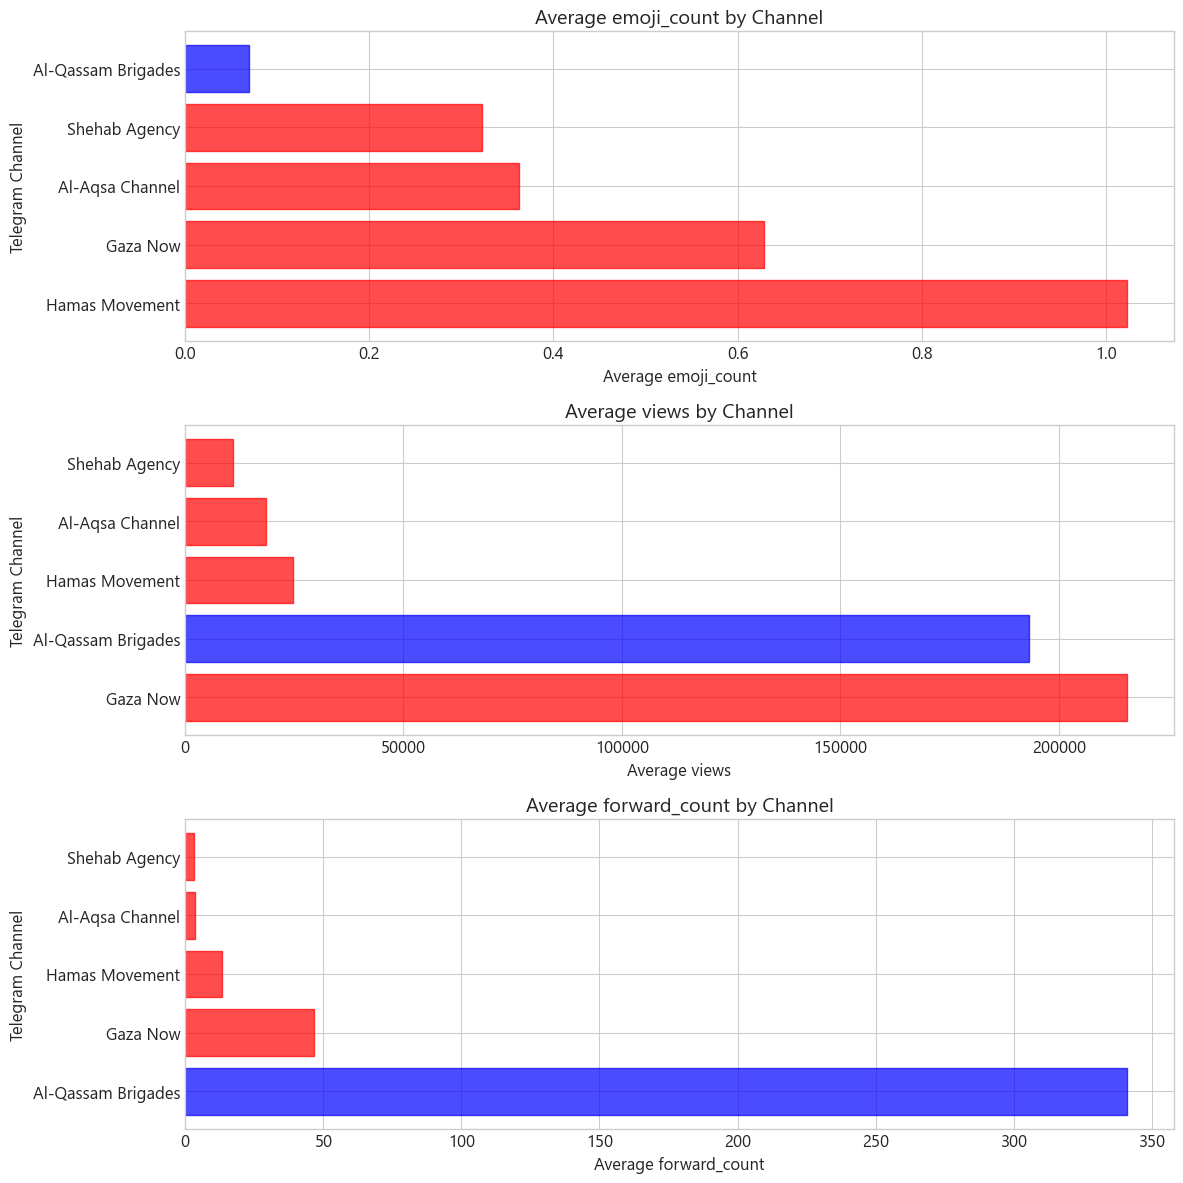

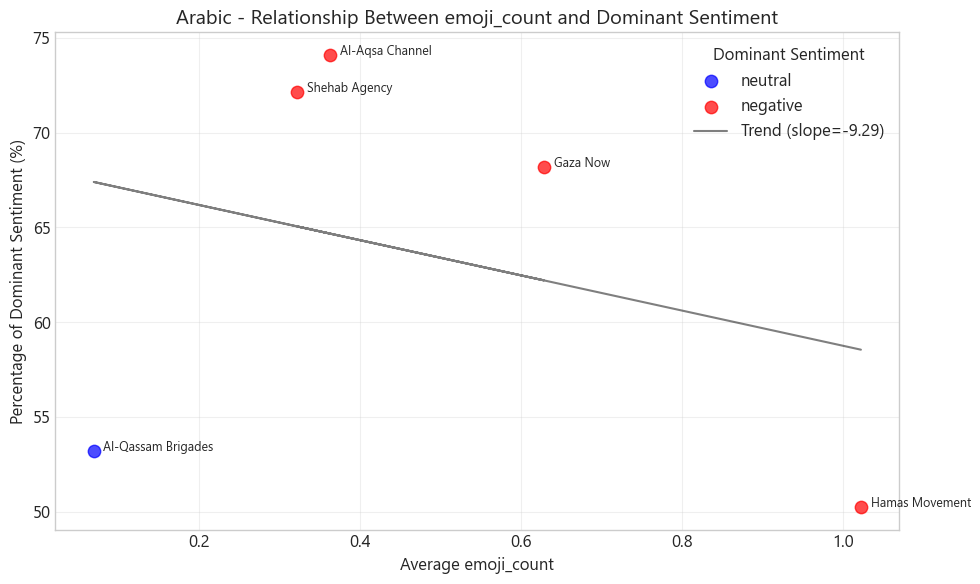

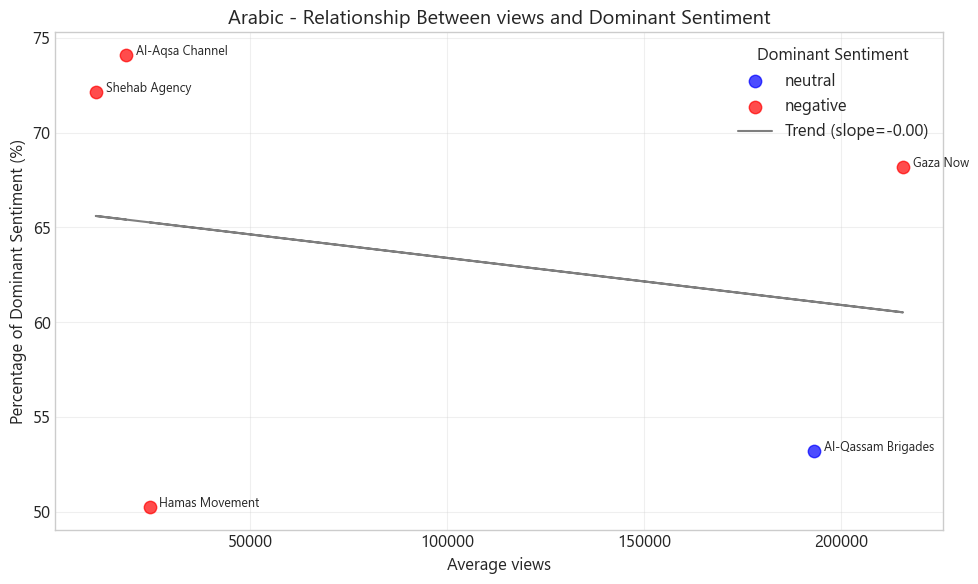

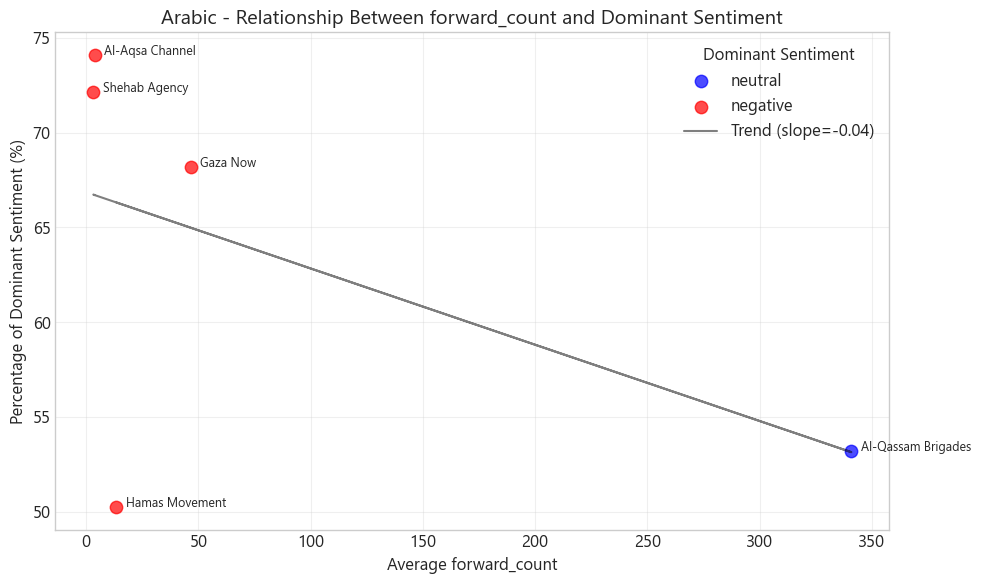

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

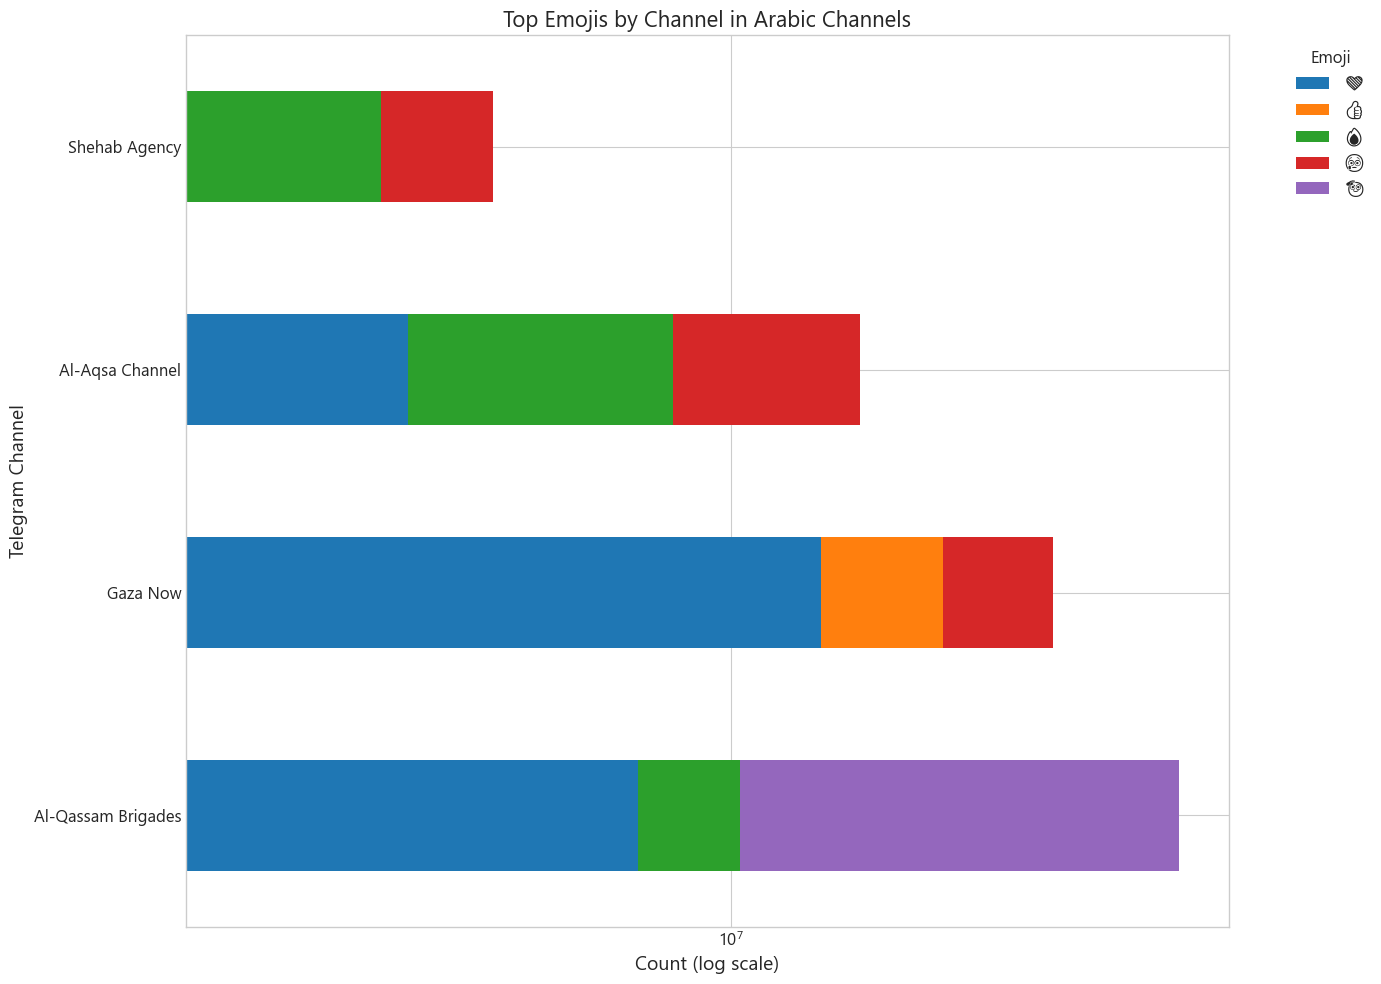

<Figure size 1200x800 with 0 Axes>

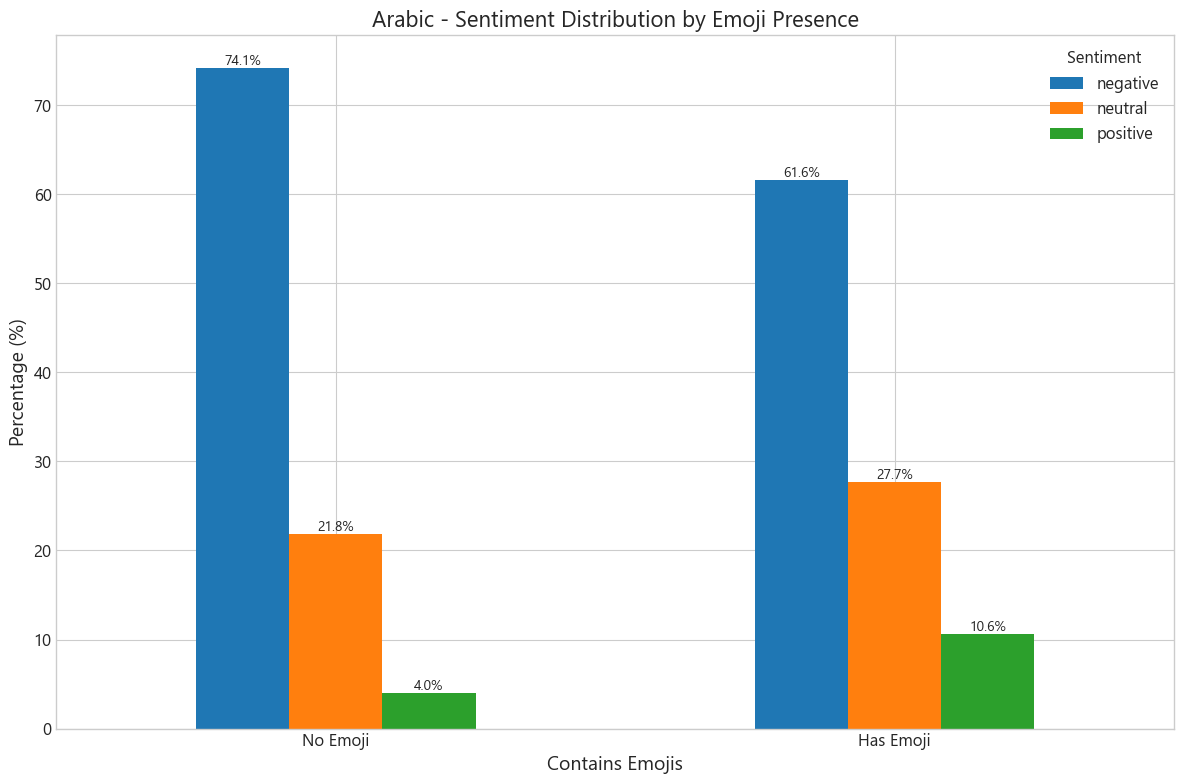


Arabic - Messages with and without emojis:
has_emoji
False    295611
True      49507


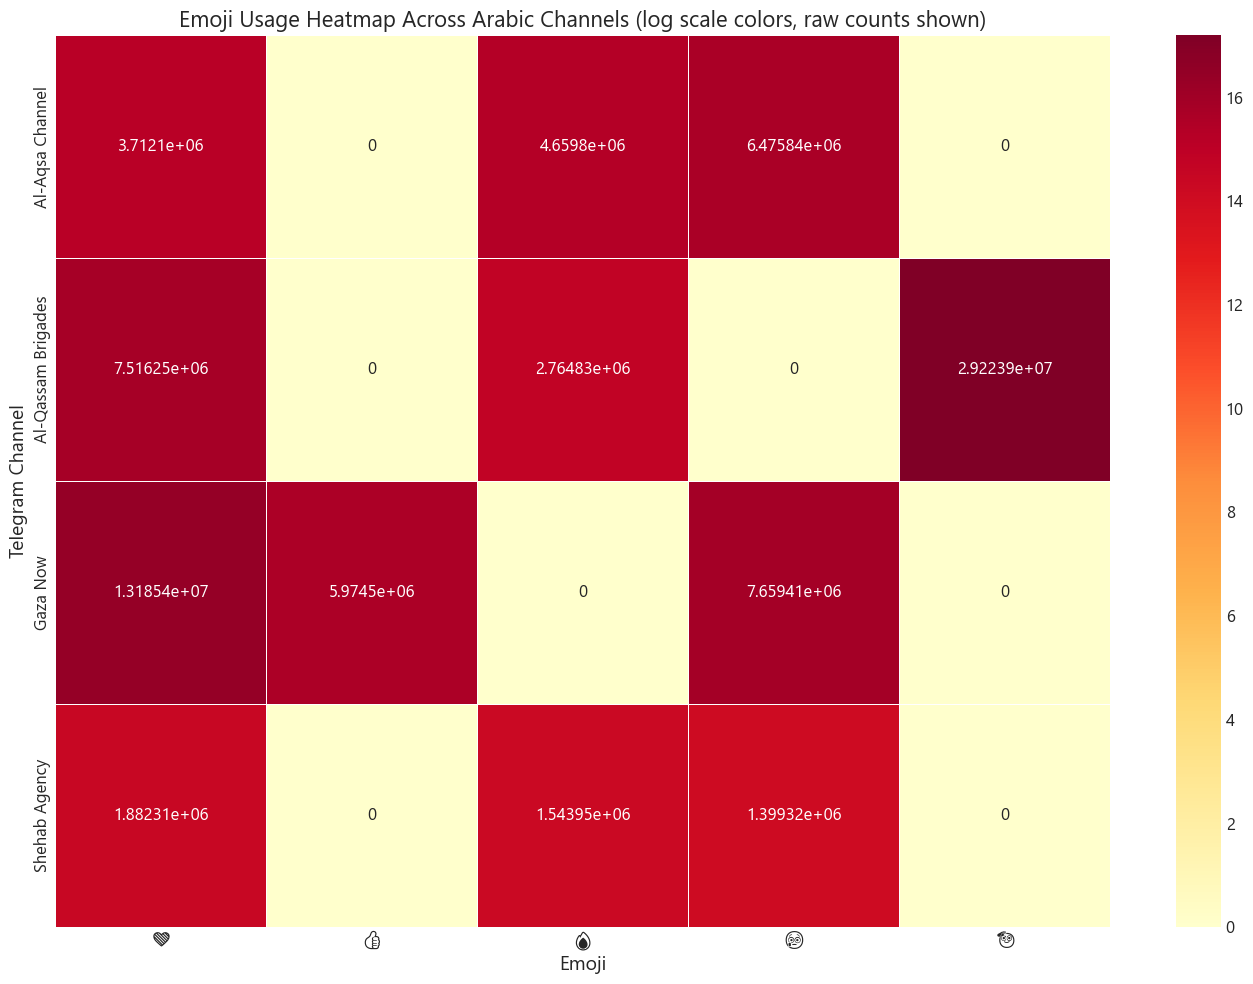

In [75]:
# Run the visualization for Arabic data
arabic_combined_data = visualize_sentiment_and_metadata(df_arabic_sentiment, language="Arabic")

# Analyze Groups' Sides Differences

In [2]:
df_hebrew_sentiment = pd.read_csv("../data/sentiment/df_hebrew_sentiment_dictabert.csv")
df_arabic_sentiment = pd.read_csv("../data/sentiment/df_arabic_sentiment.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_17032\2484302013.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_arabic_sentiment = pd.read_csv("../data/sentiment/df_arabic_sentiment.csv")


In [22]:
# Set plotting style with emoji support
plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("Set2")

# Set font with emoji support (use the one that works on your system)
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # Windows
# plt.rcParams['font.family'] = 'Apple Color Emoji'  # macOS
# plt.rcParams['font.family'] = 'Noto Color Emoji'  # Linux
plt.rcParams['svg.fonttype'] = 'none'  # Better emoji rendering in SVG

plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12


def analyze_sides_sentiment(df_hebrew, df_arabic):
    """
    Analyze sentiment differences between Israeli and Palestinian sides

    Parameters:
    -----------
    df_hebrew : DataFrame
        Hebrew sentiment dataset
    df_arabic : DataFrame
        Arabic sentiment dataset

    Returns:
    --------
    tuple
        DataFrames with aggregated sentiment by side and type
    """
    print("Analyzing sentiment differences between sides...")

    # Combine datasets
    # First, handle potential differences in sentiment column names
    hebrew_sentiment_col = 'sentiment_label'
    arabic_sentiment_col = 'sentiment_label'

    # Create a copy of each dataset with standardized columns
    df_hebrew_copy = df_hebrew.copy()
    df_arabic_copy = df_arabic.copy()

    # Add side column
    df_hebrew_copy['side'] = 'Israeli'
    df_arabic_copy['side'] = 'Palestinian'

    # Standardize sentiment values if needed
    # If Arabic dataset uses lowercase sentiment values
    sentiment_mapping = {
        'positive': 'Positive',
        'negative': 'Negative',
        'neutral': 'Neutral'
    }

    if set(df_arabic_copy[arabic_sentiment_col].unique()) == {'positive', 'negative', 'neutral'}:
        df_arabic_copy[arabic_sentiment_col] = df_arabic_copy[arabic_sentiment_col].map(sentiment_mapping)

    # # Add channel type
    # for idx, row in channels_df.iterrows():
    #     # For Hebrew dataset
    #     df_hebrew_copy.loc[df_hebrew_copy['group_title'] == row['channel'], 'channel_type'] = row['type']
    #     # For Arabic dataset
    #     df_arabic_copy.loc[df_arabic_copy['group_title'] == row['channel'], 'channel_type'] = row['type']

    # Combine datasets
    columns_to_keep = ['group_title', 'side', 'type', hebrew_sentiment_col, 'utc_date']
    columns_to_keep = [col for col in columns_to_keep if
                       col in df_hebrew_copy.columns and col in df_arabic_copy.columns]

    combined_df = pd.concat([
        df_hebrew_copy[columns_to_keep],
        df_arabic_copy[columns_to_keep]
    ], ignore_index=True)

    # Aggregate sentiment by side
    sentiment_by_side = pd.crosstab(
        combined_df['side'],
        combined_df[hebrew_sentiment_col],
        normalize='index'
    ) * 100

    # Aggregate sentiment by channel type
    sentiment_by_type = pd.crosstab(
        combined_df['type'],
        combined_df[hebrew_sentiment_col],
        normalize='index'
    ) * 100

    # Aggregate sentiment by side and type
    sentiment_by_side_type = pd.crosstab(
        [combined_df['side'], combined_df['type']],
        combined_df[hebrew_sentiment_col],
        normalize='index'
    ) * 100

    return sentiment_by_side, sentiment_by_type, sentiment_by_side_type, combined_df


def plot_side_differences(sentiment_by_side, sentiment_by_type, sentiment_by_side_type, combined_df):
    """
    Create visualizations comparing sentiment between different sides and channel types

    Parameters:
    -----------
    sentiment_by_side : DataFrame
        Sentiment proportions by side
    sentiment_by_type : DataFrame
        Sentiment proportions by channel type
    sentiment_by_side_type : DataFrame
        Sentiment proportions by side and channel type
    combined_df : DataFrame
        Combined dataset with side and type categorizations
    """
    # 1. Plot sentiment distribution by side
    plt.figure(figsize=(12, 6))
    sentiment_by_side.plot(kind='bar', figsize=(12, 6))
    # plt.title('Sentiment Distribution by Side', fontsize=16)
    plt.xlabel('Side', fontsize=20)
    plt.ylabel('Percentage (%)', fontsize=20)
    plt.xticks(rotation=0, fontsize=20)
    plt.legend(title='Sentiment', fontsize=20, title_fontsize=20)

    # Add percentage labels
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.1f%%')

    plt.tight_layout()
    # Save the figure to PDF
    plt.savefig('../plots/sentiment_distribution_by_side.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

    # 2. Plot sentiment distribution by channel type
    plt.figure(figsize=(12, 6))
    sentiment_by_type.plot(kind='bar', figsize=(12, 6))
    plt.title('Sentiment Distribution by Channel Type', fontsize=16)
    plt.xlabel('Channel Type', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Sentiment')

    # Add percentage labels
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.1f%%')

    plt.tight_layout()
    plt.show()

    # 3. Plot sentiment distribution by side and channel type
    sentiment_by_side_type.unstack().plot(kind='bar', figsize=(14, 8))
    plt.title('Sentiment Distribution by Side and Channel Type', fontsize=16)
    plt.xlabel('Side and Channel Type', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

    # 4. Heat map comparing sides and types
    plt.figure(figsize=(14, 10))

    # Create pivot tables for each sentiment
    for sentiment in ['Negative', 'Neutral', 'Positive']:
        if sentiment in sentiment_by_side_type.columns:
            pivot_data = sentiment_by_side_type[sentiment].unstack()

            plt.figure(figsize=(10, 6))
            sns.heatmap(
                pivot_data,
                annot=True,
                fmt='.1f',
                cmap='RdBu_r' if sentiment == 'Negative' else ('Blues' if sentiment == 'Neutral' else 'Greens'),
                linewidths=0.5,
                vmin=0,
                vmax=sentiment_by_side_type[sentiment].max() * 1.1  # Scale to max value
            )

            plt.title(f'{sentiment} Sentiment Distribution (%) by Side and Channel Type', fontsize=16)
            plt.tight_layout()
            plt.show()

    # 6. Statistical significance test
    print("\nStatistical significance testing for sentiment differences between sides:")

    # Create a contingency table of counts
    contingency_table = pd.crosstab(combined_df['side'], combined_df['sentiment_label'])

    # Perform chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    print(f"Chi-square test statistic: {chi2:.2f}")
    print(f"p-value: {p:.8f}")

    if p < 0.05:
        print("The sentiment distribution is significantly different between Israeli and Palestinian sides (p < 0.05)")
    else:
        print("No significant difference in sentiment distribution between Israeli and Palestinian sides")

    # Also test differences between channel types
    print("\nStatistical significance testing for sentiment differences between channel types:")

    # Create a contingency table of counts
    type_contingency = pd.crosstab(combined_df['type'], combined_df['sentiment_label'])

    # Perform chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(type_contingency)

    print(f"Chi-square test statistic: {chi2:.2f}")
    print(f"p-value: {p:.8f}")

    if p < 0.05:
        print("The sentiment distribution is significantly different between channel types (p < 0.05)")
    else:
        print("No significant difference in sentiment distribution between channel types")

In [4]:
# Analyze sentiment differences between sides
sentiment_by_side, sentiment_by_type, sentiment_by_side_type, combined_df = analyze_sides_sentiment(
    df_hebrew_sentiment,
    df_arabic_sentiment)

Analyzing sentiment differences between sides...


In [5]:
sentiment_by_side

sentiment_label,Negative,Neutral,Positive
side,,,
Israeli,12.886955,84.542518,2.570527
Palestinian,72.354093,22.658337,4.987569


In [6]:
sentiment_by_type

sentiment_label,Negative,Neutral,Positive
type,,,
Israeli commentary,12.964441,84.678081,2.357478
Israeli news,13.110717,84.173206,2.716078
Israeli side,9.284254,87.293797,3.421950
Palestinian news,72.981683,22.154688,4.863629
Palestinian side,44.141145,45.299601,10.559254


In [7]:
sentiment_by_side_type

sentiment_label                  Negative    Neutral   Positive
side        type                                               
Israeli     Israeli commentary  12.964441  84.678081   2.357478
            Israeli news        13.110717  84.173206   2.716078
            Israeli side         9.284254  87.293797   3.421950
Palestinian Palestinian news    72.981683  22.154688   4.863629
            Palestinian side    44.141145  45.299601  10.559254

<Figure size 1200x600 with 0 Axes>

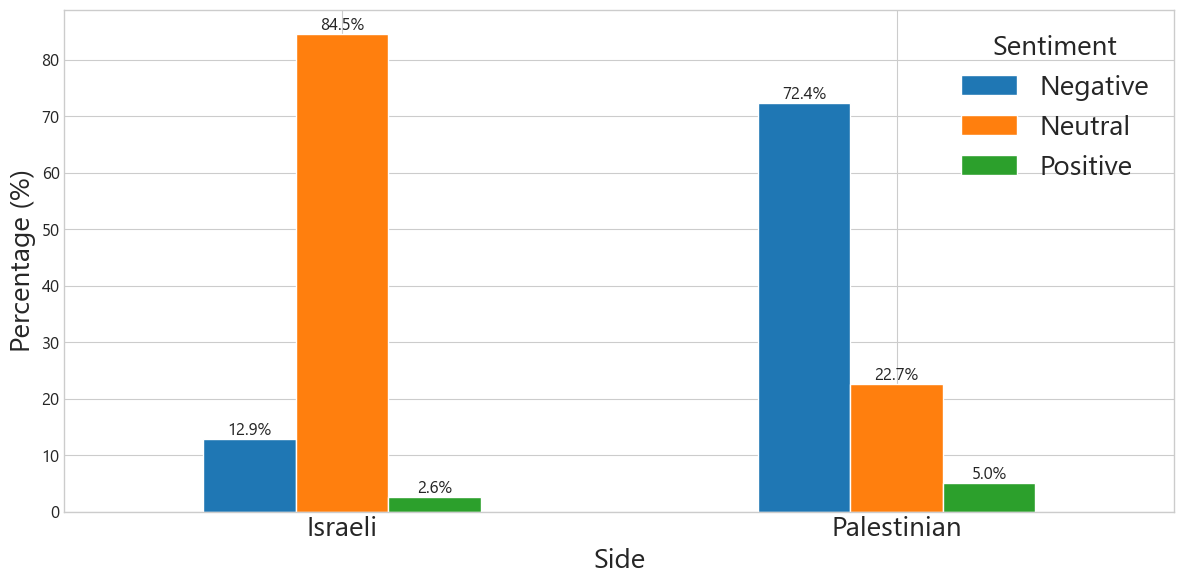

<Figure size 1200x600 with 0 Axes>

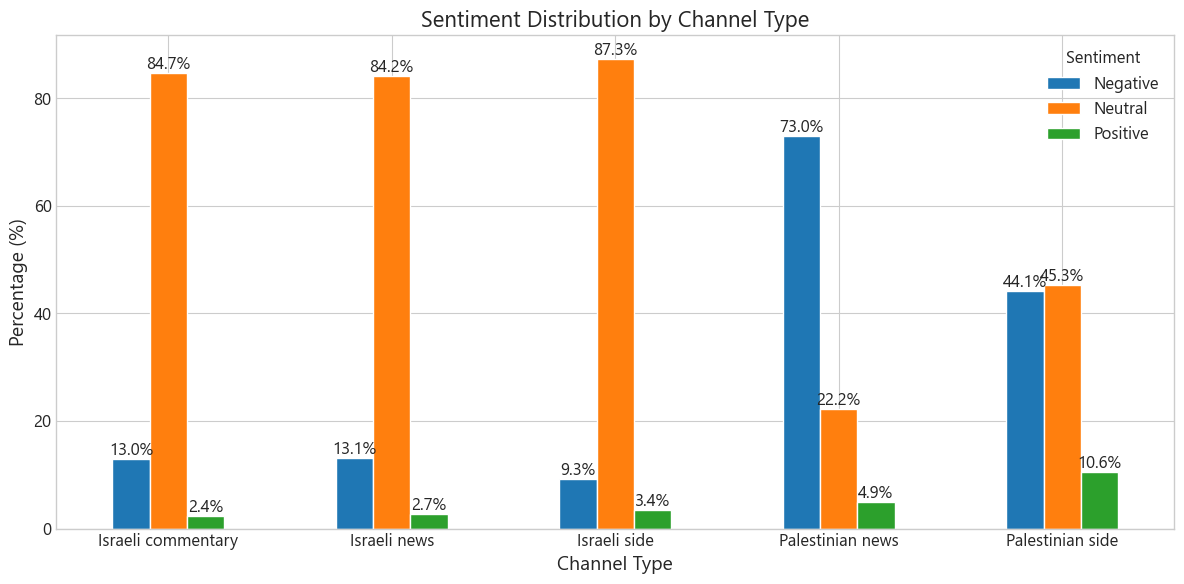

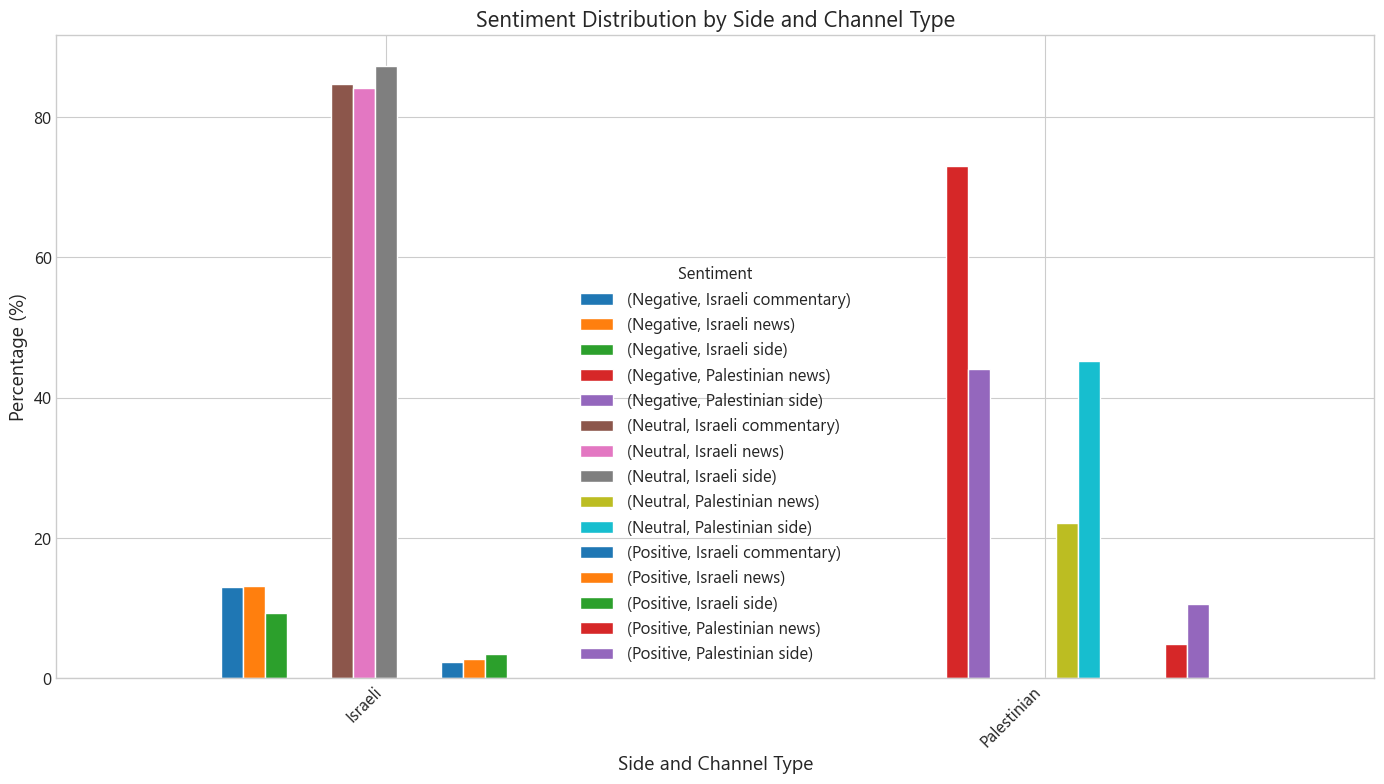

<Figure size 1400x1000 with 0 Axes>

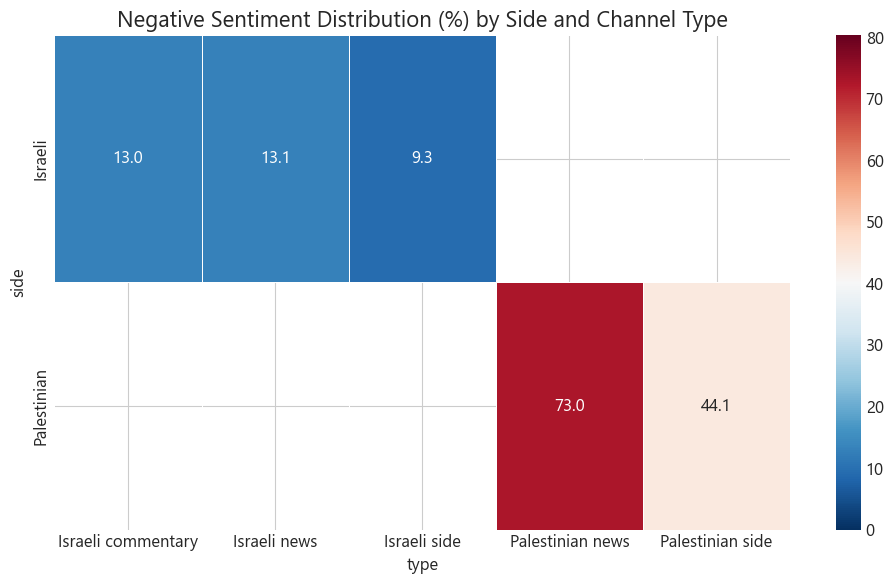

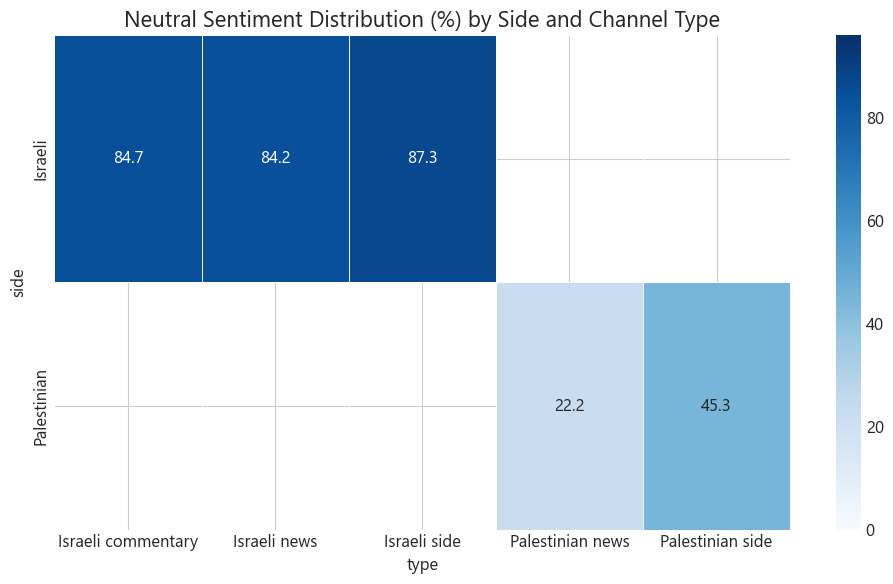

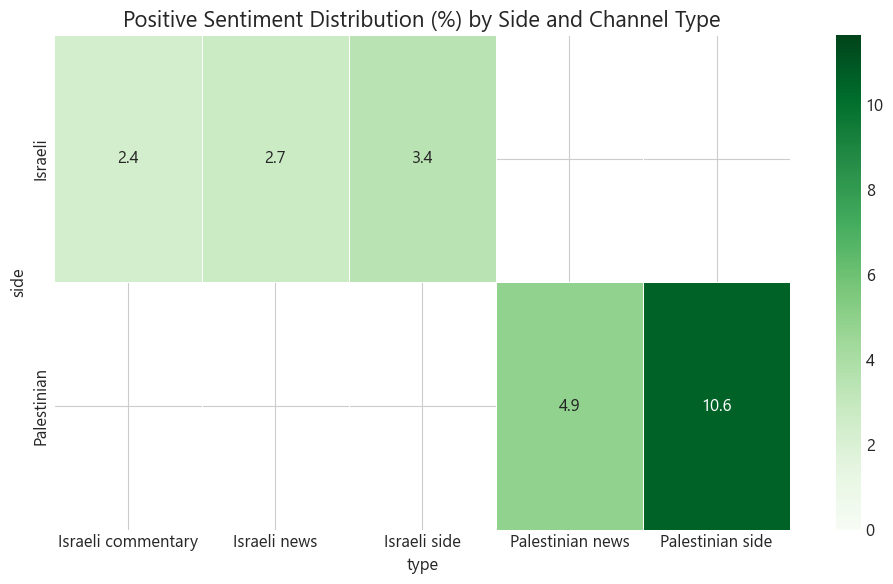


Statistical significance testing for sentiment differences between sides:
Chi-square test statistic: 187604.64
p-value: 0.00000000
The sentiment distribution is significantly different between Israeli and Palestinian sides (p < 0.05)

Statistical significance testing for sentiment differences between channel types:
Chi-square test statistic: 190314.46
p-value: 0.00000000
The sentiment distribution is significantly different between channel types (p < 0.05)


In [23]:
# Create visualizations
plot_side_differences(sentiment_by_side, sentiment_by_type, sentiment_by_side_type, combined_df)

In [9]:
# Additional focused analysis on specific groups or time periods


def compare_channel_types(combined_df):
    """
    Compare sentiment patterns between news and commentary channels

    Parameters:
    -----------
    combined_df : DataFrame
        Combined dataset with side and type categorizations
    """
    print("\nComparing News vs. Commentary Channels:")

    # # Focus on channels clearly identified as news or commentary
    # filtered_df = combined_df[combined_df['type'].isin(['News', 'Commentary'])]
    # Focus on channels containing news or commentary in their type description
    filtered_df = combined_df[combined_df['type'].str.contains('News|Commentary', case=False, na=False)]

    # Compare sentiment distribution
    type_sentiment = pd.crosstab(
        filtered_df['type'],
        filtered_df['sentiment_label'],
        normalize='index'
    ) * 100

    # Plot comparison
    plt.figure(figsize=(12, 6))
    type_sentiment.plot(kind='bar')
    plt.title('Sentiment Distribution in News vs. Commentary Channels', fontsize=16)
    plt.xlabel('Channel Type', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=0)
    plt.legend(title='Sentiment')

    # Add percentage labels
    for container in plt.gca().containers:
        plt.bar_label(container, fmt='%.1f%%')

    plt.tight_layout()
    plt.show()

    # Compare across sides
    side_type_sentiment = pd.crosstab(
        [filtered_df['side'], filtered_df['type']],
        filtered_df['sentiment_label'],
        normalize='index'
    ) * 100

    # Plot comparison
    plt.figure(figsize=(14, 8))
    side_type_sentiment.unstack().plot(kind='bar')
    plt.title('Sentiment by Side and Channel Type', fontsize=16)
    plt.xlabel('Side and Channel Type', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Sentiment')
    plt.tight_layout()
    plt.show()

    # Calculate and plot the sentiment "bias" (difference from neutral)
    # This helps compare how different channel types lean in sentiment
    if 'Neutral' in type_sentiment.columns and 'Positive' in type_sentiment.columns and 'Negative' in type_sentiment.columns:
        # Calculate sentiment score (positive - negative)
        type_sentiment['Bias'] = type_sentiment['Positive'] - type_sentiment['Negative']

        plt.figure(figsize=(10, 6))
        type_sentiment['Bias'].plot(kind='bar', color=['blue', 'red'])
        plt.title('Sentiment Bias in News vs. Commentary Channels\n(Positive % - Negative %)', fontsize=16)
        plt.xlabel('Channel Type', fontsize=14)
        plt.ylabel('Sentiment Bias', fontsize=14)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.xticks(rotation=0)

        # Add labels
        for i, bias in enumerate(type_sentiment['Bias']):
            color = 'green' if bias > 0 else 'red'
            plt.text(i, bias + (1 if bias > 0 else -1), f"{bias:.1f}",
                     ha='center', color=color, fontweight='bold')

        plt.tight_layout()
        plt.show()


Comparing News vs. Commentary Channels:


<Figure size 1200x600 with 0 Axes>

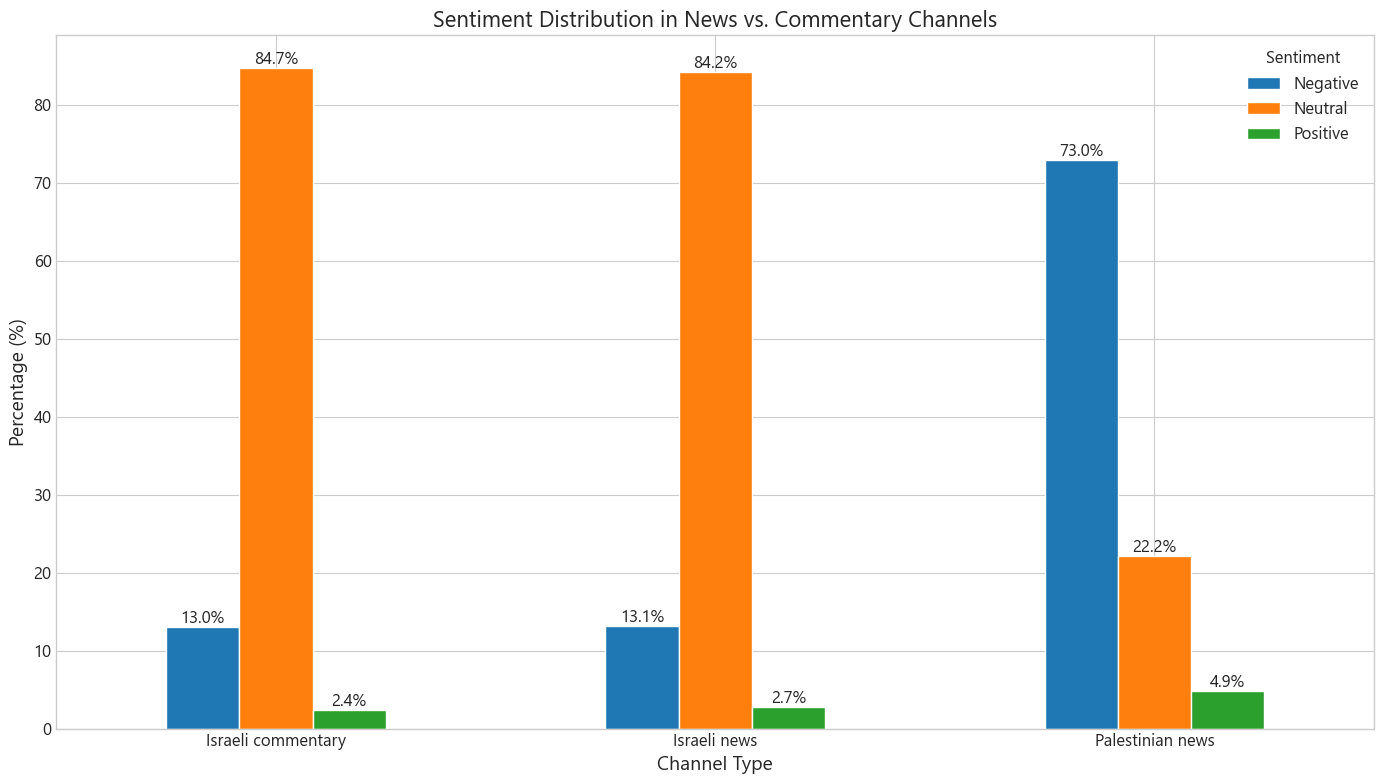

<Figure size 1400x800 with 0 Axes>

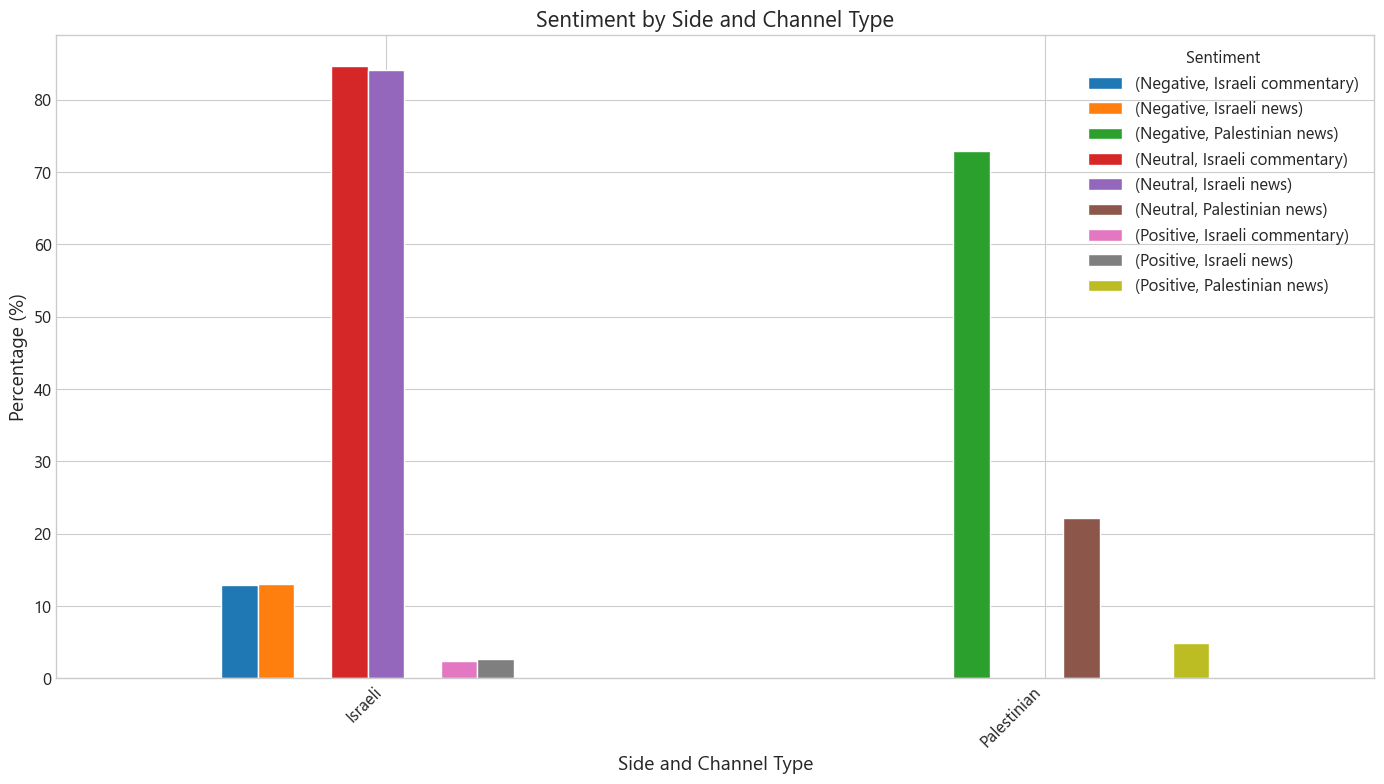

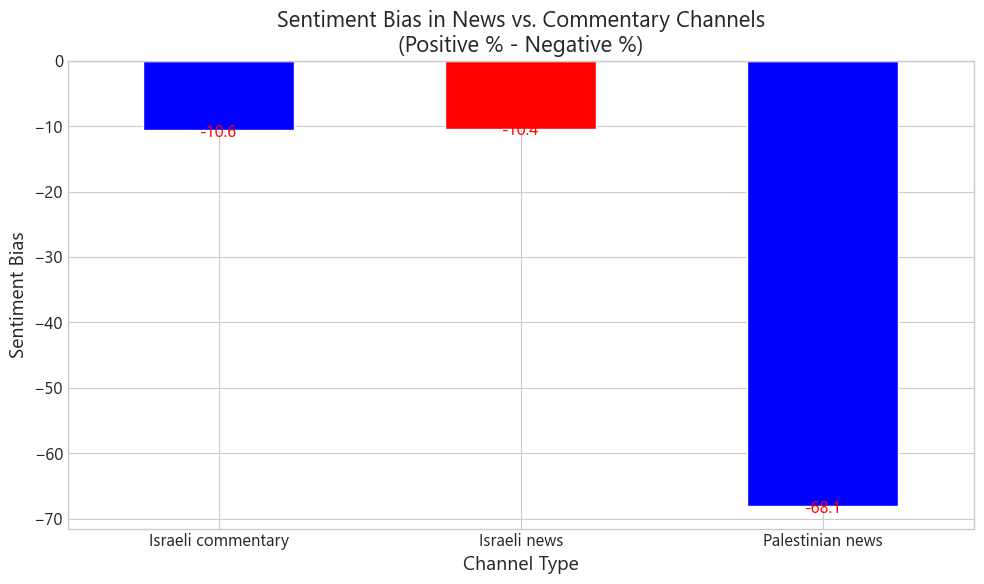

In [10]:
# Execute the channel type comparison
compare_channel_types(combined_df)

In [11]:
combined_df

,group_title,side,type,sentiment_label,utc_date
0,IDF - The Official Channel,Israeli,Israeli side,Neutral,2025-02-21 19:35:05+0000
1,IDF - The Official Channel,Israeli,Israeli side,Neutral,2025-02-21 13:50:56+0000
2,IDF - The Official Channel,Israeli,Israeli side,Neutral,2025-02-21 10:30:15+0000
3,IDF - The Official Channel,Israeli,Israeli side,Neutral,2025-02-21 00:20:08+0000
4,IDF - The Official Channel,Israeli,Israeli side,Neutral,2025-02-20 23:07:30+0000
...,...,...,...,...,...
528694,Shehab Agency,Palestinian,Palestinian news,Negative,2023-10-05 21:33:44+0000
528695,Shehab Agency,Palestinian,Palestinian news,Negative,2023-10-05 21:28:32+0000
528696,Shehab Agency,Palestinian,Palestinian news,Negative,2023-10-05 21:27:51+0000
528697,Shehab Agency,Palestinian,Palestinian news,Negative,2023-10-05 21:22:42+0000


In [12]:
# Analyze the relationship between engagement metrics and sentiment across sides

def analyze_engagement_by_sentiment_side(combined_df):
    """
    Analyze how engagement metrics vary by sentiment and side

    Parameters:
    -----------
    combined_df : DataFrame
        Combined dataset with side and type categorizations
    """
    print("\nAnalyzing engagement metrics by sentiment and side:")

    # Check which engagement metrics are available
    engagement_metrics = ['views', 'emoji_count', 'forward_count', 'word_count']
    available_metrics = [col for col in engagement_metrics if col in combined_df.columns]

    if not available_metrics:
        print("No engagement metrics available in the dataset.")
        return

    # For each metric, analyze by sentiment and side
    for metric in available_metrics:
        # Calculate average metric value by sentiment and side
        engagement_by_sentiment_side = combined_df.groupby(['side', 'sentiment_label'])[metric].mean().unstack()

        # Plot the results
        plt.figure(figsize=(12, 6))
        engagement_by_sentiment_side.plot(kind='bar')
        plt.title(f'Average {metric.replace("_", " ").title()} by Sentiment and Side', fontsize=16)
        plt.xlabel('Side', fontsize=14)
        plt.ylabel(f'Average {metric.replace("_", " ").title()}', fontsize=14)
        plt.xticks(rotation=0)
        plt.legend(title='Sentiment')

        # Add value labels
        for container in plt.gca().containers:
            plt.bar_label(container, fmt='%.1f')

        plt.tight_layout()
        plt.show()

        # Statistical testing - Two-way ANOVA would be ideal, but we'll use simpler tests
        print(f"\nStatistical significance testing for {metric}:")

        # Test effect of sentiment
        sentiments = combined_df['sentiment_label'].unique()
        sentiment_groups = [combined_df[combined_df['sentiment_label'] == s][metric].dropna()
                            for s in sentiments if len(combined_df[combined_df['sentiment_label'] == s]) > 0]

        if len(sentiment_groups) > 1 and all(len(g) > 0 for g in sentiment_groups):
            f_stat, p_val = stats.f_oneway(*sentiment_groups)
            print(f"Effect of sentiment on {metric}: F={f_stat:.2f}, p={p_val:.8f}")

            if p_val < 0.05:
                print(f"  Significant effect of sentiment on {metric} (p < 0.05)")
            else:
                print(f"  No significant effect of sentiment on {metric}")

        # Test effect of side
        sides = combined_df['side'].unique()
        side_groups = [combined_df[combined_df['side'] == s][metric].dropna()
                       for s in sides if len(combined_df[combined_df['side'] == s]) > 0]

        if len(side_groups) > 1 and all(len(g) > 0 for g in side_groups):
            f_stat, p_val = stats.f_oneway(*side_groups)
            print(f"Effect of side on {metric}: F={f_stat:.2f}, p={p_val:.8f}")

            if p_val < 0.05:
                print(f"  Significant effect of side on {metric} (p < 0.05)")
            else:
                print(f"  No significant effect of side on {metric}")

In [13]:
# Execute the engagement analysis
analyze_engagement_by_sentiment_side(combined_df)


Analyzing engagement metrics by sentiment and side:
No engagement metrics available in the dataset.


In [14]:
def analyze_engagement_by_sentiment_side(combined_df, hebrew_df, arabic_df):
    """
    Analyze how engagement metrics vary by sentiment and side

    Parameters:
    -----------
    combined_df : DataFrame
        Combined dataset with side and type categorizations
    hebrew_df : DataFrame
        Original Hebrew dataset with engagement metrics
    arabic_df : DataFrame
        Original Arabic dataset with engagement metrics
    """
    print("\nAnalyzing engagement metrics by sentiment and side:")

    # Create a new DataFrame to hold all data
    analysis_df = combined_df.copy()

    # Extract Hebrew and Arabic records
    hebrew_metrics = hebrew_df[hebrew_df['language'].str.lower() == 'hebrew'].copy().reset_index(drop=True)
    arabic_metrics = arabic_df[arabic_df['language'].str.lower() == 'arabic'].copy().reset_index(drop=True)

    # Filter combined_df by side
    hebrew_combined = analysis_df[analysis_df['side'] == 'Israeli'].copy().reset_index(drop=True)
    arabic_combined = analysis_df[analysis_df['side'] == 'Palestinian'].copy().reset_index(drop=True)

    # Add engagement metrics to respective datasets based on index position
    # Ensure dataframes are the same length before adding columns
    if len(hebrew_combined) == len(hebrew_metrics):
        for metric in ['views', 'emoji_count', 'forward_count', 'word_count']:
            if metric in hebrew_metrics.columns:
                hebrew_combined[metric] = hebrew_metrics[metric].values
    else:
        print(f"Warning: Israeli/Hebrew dataframes have different lengths ({len(hebrew_combined)} vs {len(hebrew_metrics)})")

    if len(arabic_combined) == len(arabic_metrics):
        for metric in ['views', 'emoji_count', 'forward_count', 'word_count']:
            if metric in arabic_metrics.columns:
                arabic_combined[metric] = arabic_metrics[metric].values
    else:
        print(f"Warning: Palestinian/Arabic dataframes have different lengths ({len(arabic_combined)} vs {len(arabic_metrics)})")

    # Recombine the datasets
    analysis_df = pd.concat([hebrew_combined, arabic_combined], ignore_index=True)

    # Check which engagement metrics are available
    engagement_metrics = ['views', 'emoji_count', 'forward_count', 'word_count']
    available_metrics = [col for col in engagement_metrics if col in analysis_df.columns]

    if not available_metrics:
        print("No engagement metrics available in the dataset.")
        return

    # For each metric, analyze by sentiment and side
    for metric in available_metrics:
        # Skip metrics with too many NaN values
        if analysis_df[metric].isna().sum() > 0.8 * len(analysis_df):
            print(f"Skipping {metric} due to too many missing values")
            continue

        # Calculate average metric value by sentiment and side
        engagement_by_sentiment_side = analysis_df.groupby(['side', 'sentiment_label'])[metric].mean().unstack()

        # Plot the results
        plt.figure(figsize=(12, 6))
        engagement_by_sentiment_side.plot(kind='bar')
        plt.title(f'Average {metric.replace("_", " ").title()} by Sentiment and Side', fontsize=16)
        plt.xlabel('Side', fontsize=14)
        plt.ylabel(f'Average {metric.replace("_", " ").title()}', fontsize=14)
        plt.xticks(rotation=0)
        plt.legend(title='Sentiment')

        # Add value labels
        for container in plt.gca().containers:
            plt.bar_label(container, fmt='%.1f')

        plt.tight_layout()
        plt.show()

        # Statistical testing
        print(f"\nStatistical significance testing for {metric}:")

        # Test effect of sentiment
        sentiments = analysis_df['sentiment_label'].unique()
        sentiment_groups = [analysis_df[analysis_df['sentiment_label'] == s][metric].dropna()
                            for s in sentiments if len(analysis_df[analysis_df['sentiment_label'] == s]) > 0]

        if len(sentiment_groups) > 1 and all(len(g) > 0 for g in sentiment_groups):
            f_stat, p_val = stats.f_oneway(*sentiment_groups)
            print(f"Effect of sentiment on {metric}: F={f_stat:.2f}, p={p_val:.8f}")

            if p_val < 0.05:
                print(f"  Significant effect of sentiment on {metric} (p < 0.05)")
            else:
                print(f"  No significant effect of sentiment on {metric}")

        # Test effect of side
        sides = analysis_df['side'].unique()
        side_groups = [analysis_df[analysis_df['side'] == s][metric].dropna()
                       for s in sides if len(analysis_df[analysis_df['side'] == s]) > 0]

        if len(side_groups) > 1 and all(len(g) > 0 for g in side_groups):
            f_stat, p_val = stats.f_oneway(*side_groups)
            print(f"Effect of side on {metric}: F={f_stat:.2f}, p={p_val:.8f}")

            if p_val < 0.05:
                print(f"  Significant effect of side on {metric} (p < 0.05)")
            else:
                print(f"  No significant effect of side on {metric}")


Analyzing engagement metrics by sentiment and side:


<Figure size 1200x600 with 0 Axes>

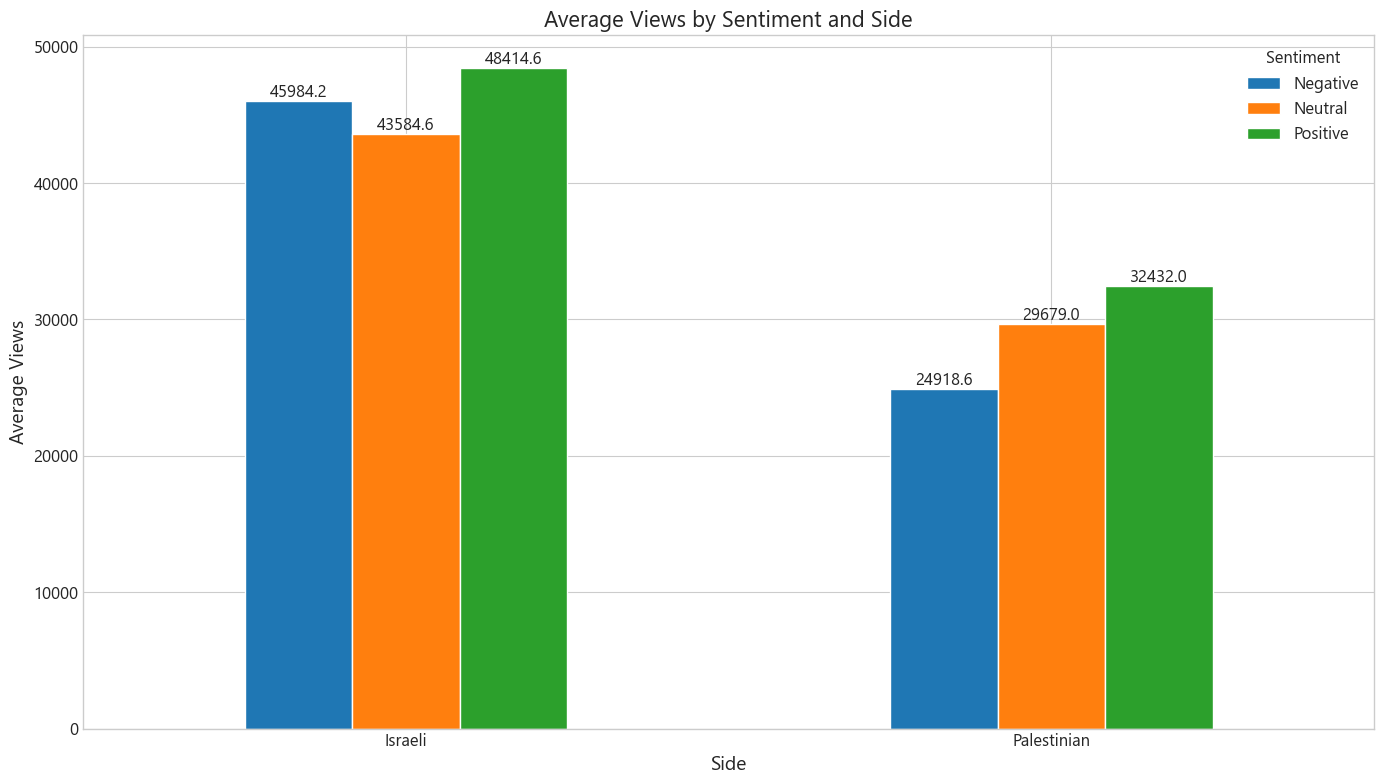


Statistical significance testing for views:
Effect of sentiment on views: F=3133.71, p=0.00000000
  Significant effect of sentiment on views (p < 0.05)
Effect of side on views: F=12484.27, p=0.00000000
  Significant effect of side on views (p < 0.05)


<Figure size 1200x600 with 0 Axes>

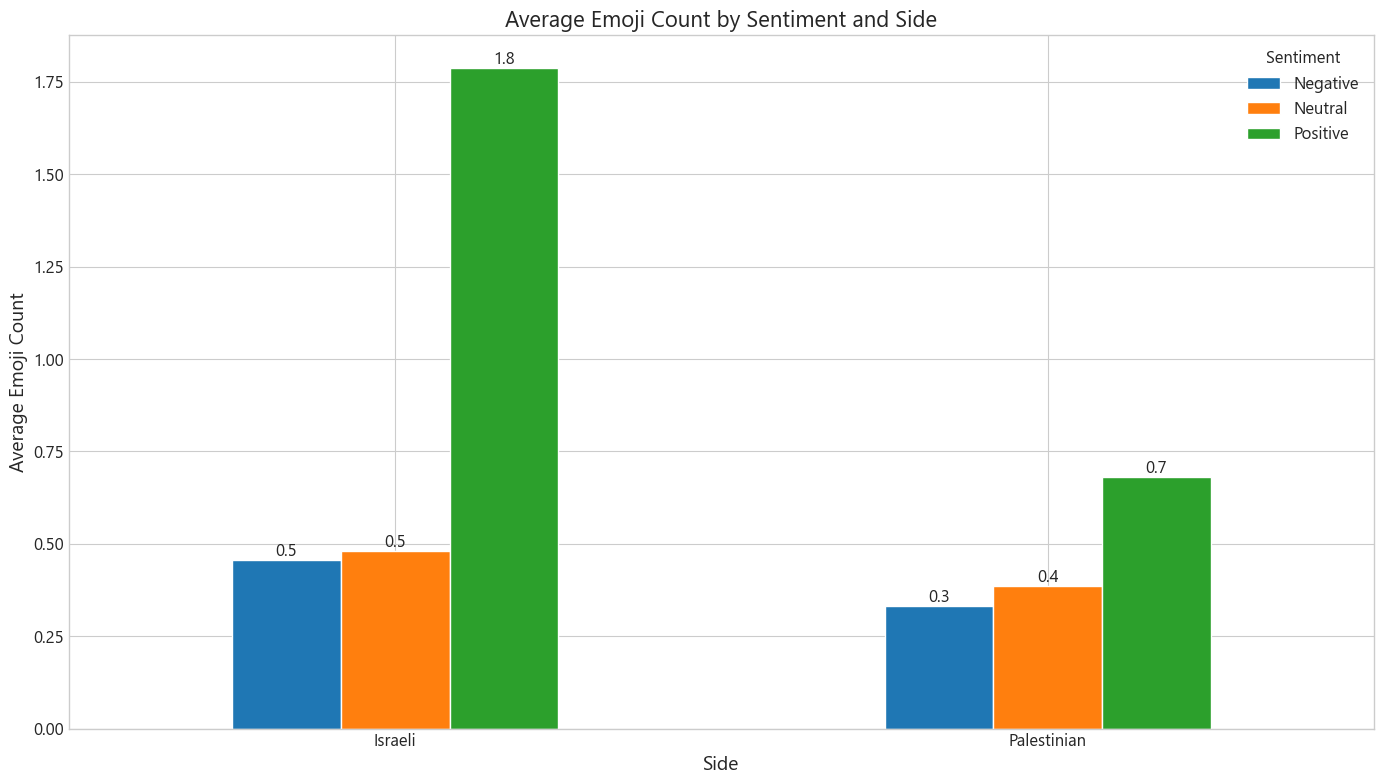


Statistical significance testing for emoji_count:
Effect of sentiment on emoji_count: F=1617.51, p=0.00000000
  Significant effect of sentiment on emoji_count (p < 0.05)
Effect of side on emoji_count: F=1185.56, p=0.00000000
  Significant effect of side on emoji_count (p < 0.05)


<Figure size 1200x600 with 0 Axes>

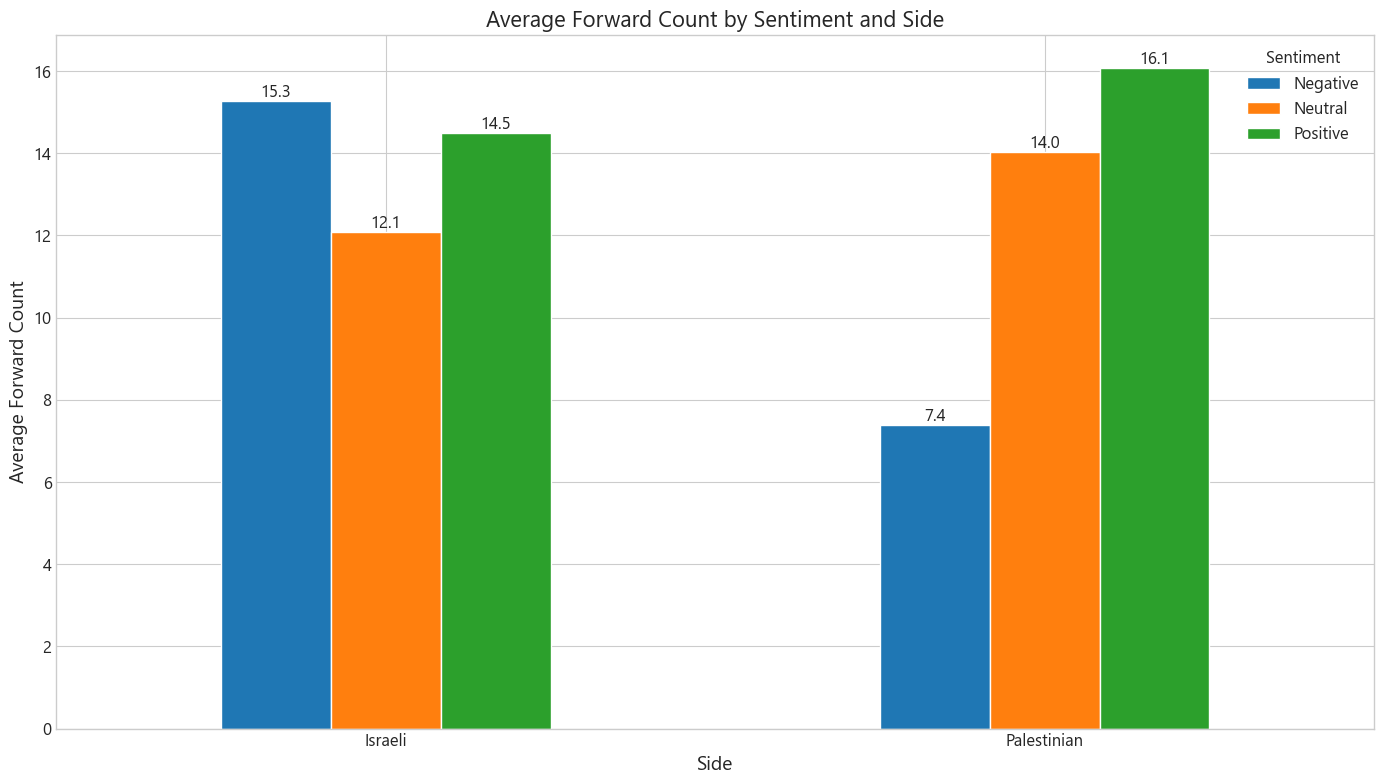


Statistical significance testing for forward_count:
Effect of sentiment on forward_count: F=448.31, p=0.00000000
  Significant effect of sentiment on forward_count (p < 0.05)
Effect of side on forward_count: F=334.07, p=0.00000000
  Significant effect of side on forward_count (p < 0.05)


<Figure size 1200x600 with 0 Axes>

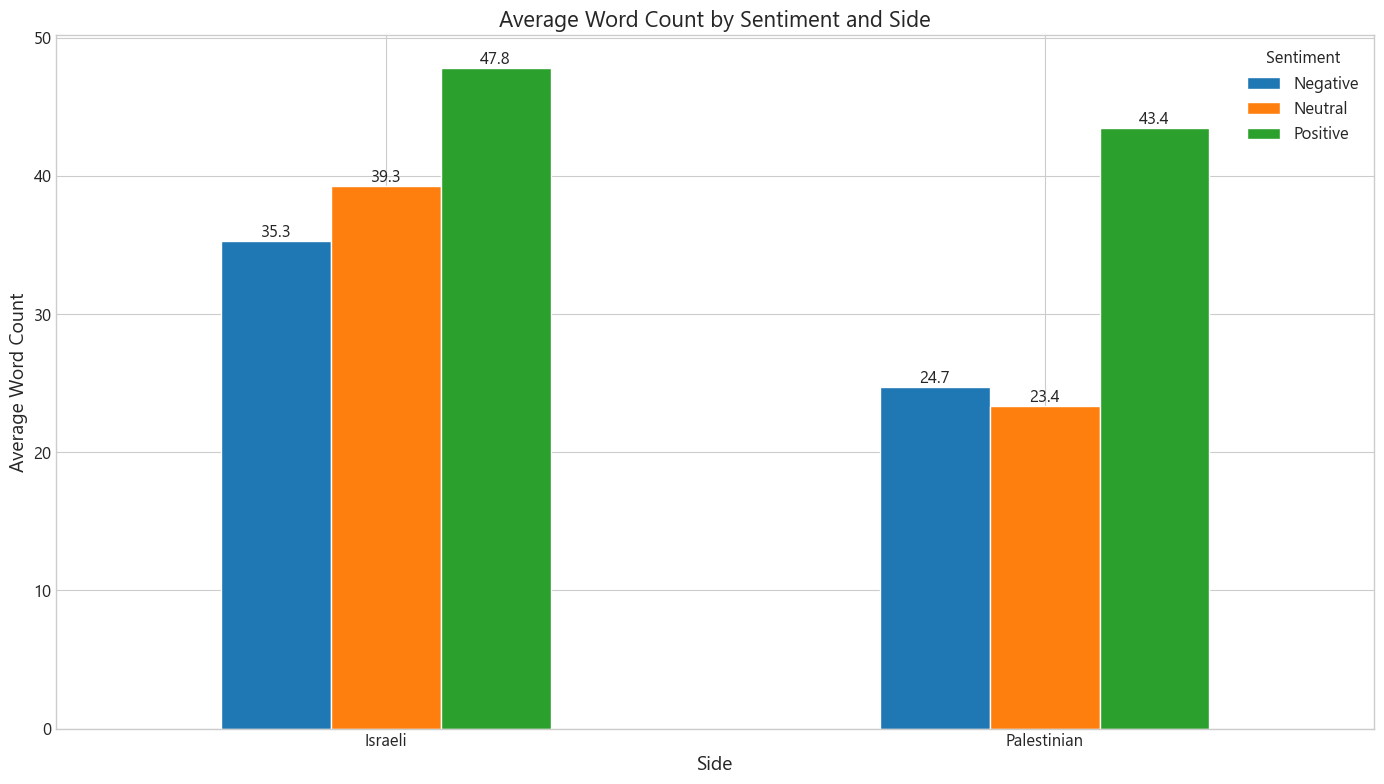


Statistical significance testing for word_count:
Effect of sentiment on word_count: F=3477.92, p=0.00000000
  Significant effect of sentiment on word_count (p < 0.05)
Effect of side on word_count: F=11668.31, p=0.00000000
  Significant effect of side on word_count (p < 0.05)


In [15]:
analyze_engagement_by_sentiment_side(combined_df, df_hebrew_sentiment, df_arabic_sentiment)

In [16]:
# Set plotting style with emoji support
plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("Set2")

# Set font with emoji support
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # Windows
# plt.rcParams['font.family'] = 'Apple Color Emoji'  # macOS
# plt.rcParams['font.family'] = 'Noto Color Emoji'  # Linux
plt.rcParams['svg.fonttype'] = 'none'  # Better emoji rendering in SVG

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

def compare_sides_and_types(df_hebrew, df_arabic):
    """
    Compare sentiment distributions between Israeli and Palestinian sides,
    as well as between different channel types (official, commentary, news).

    Parameters:
    -----------
    df_hebrew : pandas.DataFrame
        DataFrame with Hebrew sentiment data
    df_arabic : pandas.DataFrame
        DataFrame with Arabic sentiment data
    """
    print("Analyzing sentiment differences between Israeli and Palestinian sides...")

    # Combine datasets with a new column for side
    df_hebrew['side'] = 'Israeli'
    df_arabic['side'] = 'Palestinian'

    # Rename sentiment labels in Arabic dataset to match Hebrew format for consistency
    sentiment_map = {
        'negative': 'Negative',
        'neutral': 'Neutral',
        'positive': 'Positive'
    }

    df_arabic_renamed = df_arabic.copy()
    df_arabic_renamed['sentiment_label'] = df_arabic_renamed['sentiment_label'].map(sentiment_map)

    # Combine datasets
    combined_df = pd.concat([df_hebrew, df_arabic_renamed], ignore_index=True)

    # 1. Overall Sentiment by Side
    print("Analyzing overall sentiment by side...")

    # Calculate sentiment proportions by side
    sentiment_by_side = pd.crosstab(
        combined_df['side'],
        combined_df['sentiment_label'],
        normalize='index'
    ) * 100

    # Plot side comparison
    plt.figure(figsize=(12, 6))
    ax = sentiment_by_side.plot(kind='bar', rot=0)

    plt.title('Sentiment Distribution: Israeli vs. Palestinian Sides', fontsize=16)
    plt.xlabel('Side', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.legend(title='Sentiment')

    # Add count labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

    # Add sample sizes as text
    side_counts = combined_df['side'].value_counts()
    for i, side in enumerate(sentiment_by_side.index):
        plt.text(i, 5, f'n={side_counts[side]:,}', ha='center')

    plt.tight_layout()
    plt.show()

    # Chi-square test for significance
    contingency_table = pd.crosstab(combined_df['side'], combined_df['sentiment_label'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    print(f"Chi-square test for sentiment differences between sides:")
    print(f"Chi-square statistic: {chi2:.2f}")
    print(f"p-value: {p:.8f}")
    if p < 0.05:
        print("The sentiment difference between Israeli and Palestinian sides is statistically significant.")
    else:
        print("There is no statistically significant difference in sentiment between sides.")

    # 2. Sentiment by Channel Type
    print("\nAnalyzing sentiment by channel type...")

    # Extract type groups
    israeli_types = combined_df[combined_df['side'] == 'Israeli']['type'].str.replace('Israeli ', '')
    palestinian_types = combined_df[combined_df['side'] == 'Palestinian']['type'].str.replace('Palestinian ', '')

    # Create a new column with just the type
    combined_df['channel_type'] = combined_df['type'].str.extract(r'(?:Israeli|Palestinian) (.+)')

    # Calculate sentiment proportions by type
    sentiment_by_type = pd.crosstab(
        combined_df['channel_type'],
        combined_df['sentiment_label'],
        normalize='index'
    ) * 100

    # Plot type comparison
    plt.figure(figsize=(12, 6))
    ax = sentiment_by_type.plot(kind='bar', rot=0)

    plt.title('Sentiment Distribution by Channel Type', fontsize=16)
    plt.xlabel('Channel Type', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.legend(title='Sentiment')

    # Add count labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%')

    # Add sample sizes as text
    type_counts = combined_df['channel_type'].value_counts()
    for i, channel_type in enumerate(sentiment_by_type.index):
        plt.text(i, 5, f'n={type_counts[channel_type]:,}', ha='center')

    plt.tight_layout()
    plt.show()

    # Chi-square test for significance among types
    type_contingency = pd.crosstab(combined_df['channel_type'], combined_df['sentiment_label'])
    type_chi2, type_p, type_dof, type_expected = stats.chi2_contingency(type_contingency)

    print(f"Chi-square test for sentiment differences between channel types:")
    print(f"Chi-square statistic: {type_chi2:.2f}")
    print(f"p-value: {type_p:.8f}")
    if type_p < 0.05:
        print("The sentiment difference between channel types is statistically significant.")
    else:
        print("There is no statistically significant difference in sentiment between channel types.")

    # 3. Side-Type Interaction Analysis
    print("\nAnalyzing interaction between side and channel type...")

    # Create a combined side-type column
    combined_df['side_type'] = combined_df['side'] + ' ' + combined_df['channel_type']

    # Calculate sentiment proportions by side-type combination
    sentiment_by_side_type = pd.crosstab(
        combined_df['side_type'],
        combined_df['sentiment_label'],
        normalize='index'
    ) * 100

    # Plot side-type combination
    plt.figure(figsize=(14, 8))
    ax = sentiment_by_side_type.plot(kind='bar')

    plt.title('Sentiment Distribution by Side and Channel Type', fontsize=16)
    plt.xlabel('Side and Channel Type', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.legend(title='Sentiment')
    plt.xticks(rotation=45, ha='right')

    # Add count labels on top of each bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=8)

    # Add sample sizes as text
    side_type_counts = combined_df['side_type'].value_counts()
    for i, side_type in enumerate(sentiment_by_side_type.index):
        if side_type in side_type_counts:
            plt.text(i, 5, f'n={side_type_counts[side_type]:,}', ha='center', fontsize=8, rotation=90)

    plt.tight_layout()
    plt.show()

    # 4. Visualize the data as a heatmap for better comparison
    plt.figure(figsize=(12, 8))

    # Prepare data for heatmap - Negative sentiment percentage
    negative_pcts = pd.DataFrame({
        'Negative': sentiment_by_side_type['Negative']
    }).reset_index()

    # Extract side and type for plotting
    negative_pcts[['side', 'type']] = negative_pcts['side_type'].str.split(' ', n=1, expand=True)
    negative_pcts = negative_pcts.pivot(index='type', columns='side', values='Negative')

    # Plot heatmap
    sns.heatmap(
        negative_pcts,
        annot=True,
        fmt='.1f',
        cmap='RdBu_r',
        vmin=0,
        vmax=100,
        linewidths=0.5,
        cbar_kws={'label': 'Percentage of Negative Sentiment (%)'}
    )

    plt.title('Percentage of Negative Sentiment by Side and Channel Type', fontsize=16)
    plt.tight_layout()
    plt.show()

    # 5. Compare engagement metrics across sides and types
    print("\nComparing engagement metrics across sides and channel types...")

    engagement_metrics = ['views', 'emoji_count', 'forward_count']
    available_metrics = [col for col in engagement_metrics if col in combined_df.columns]

    if available_metrics:
        # Calculate average metrics by side and type
        side_engagement = combined_df.groupby('side')[available_metrics].mean()
        type_engagement = combined_df.groupby('channel_type')[available_metrics].mean()
        side_type_engagement = combined_df.groupby('side_type')[available_metrics].mean()

        # Plot side comparison
        plt.figure(figsize=(14, 5 * len(available_metrics)))

        for i, metric in enumerate(available_metrics):
            plt.subplot(len(available_metrics), 1, i + 1)

            # Plot by side
            sns.barplot(x='side', y=metric, data=combined_df, errorbar=('ci', 95))

            plt.title(f'Average {metric.replace("_", " ").title()} by Side', fontsize=14)
            plt.xlabel('Side', fontsize=12)
            plt.ylabel(f'Average {metric.replace("_", " ").title()}', fontsize=12)

            # Add mean values as text
            for j, side in enumerate(side_engagement.index):
                plt.text(j, side_engagement.loc[side, metric] * 1.05,
                        f'{side_engagement.loc[side, metric]:.1f}',
                        ha='center')

        plt.tight_layout()
        plt.show()

        # Plot type comparison
        plt.figure(figsize=(14, 5 * len(available_metrics)))

        for i, metric in enumerate(available_metrics):
            plt.subplot(len(available_metrics), 1, i + 1)

            # Plot by channel type
            sns.barplot(x='channel_type', y=metric, data=combined_df, errorbar=('ci', 95))

            plt.title(f'Average {metric.replace("_", " ").title()} by Channel Type', fontsize=14)
            plt.xlabel('Channel Type', fontsize=12)
            plt.ylabel(f'Average {metric.replace("_", " ").title()}', fontsize=12)

            # Add mean values as text
            for j, channel_type in enumerate(type_engagement.index):
                plt.text(j, type_engagement.loc[channel_type, metric] * 1.05,
                        f'{type_engagement.loc[channel_type, metric]:.1f}',
                        ha='center')

        plt.tight_layout()
        plt.show()

        # Plot side-type combination heatmap for the most important metric (views)
        if 'views' in available_metrics:
            plt.figure(figsize=(10, 6))

            # Prepare data for heatmap
            views_data = side_type_engagement.reset_index()[['side_type', 'views']]
            views_data[['side', 'type']] = views_data['side_type'].str.split(' ', n=1, expand=True)
            views_pivot = views_data.pivot(index='type', columns='side', values='views')

            # Plot heatmap
            sns.heatmap(
                views_pivot,
                annot=True,
                fmt='.1f',
                cmap='YlGnBu',
                linewidths=0.5,
                cbar_kws={'label': 'Average Views'}
            )

            plt.title('Average Views by Side and Channel Type', fontsize=16)
            plt.tight_layout()
            plt.show()

    # 6. Create a side-by-side channel comparison with all relevant metrics
    print("\nCreating comprehensive channel comparison...")

    # Group by group_title to calculate aggregate metrics - separately for each part

    # First, calculate the dominant sentiment
    dominant_sentiment = combined_df.groupby('group_title')['sentiment_label'].agg(
        lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else None
    ).to_frame('dominant_sentiment')

    # Calculate metadata columns (side, channel_type)
    metadata = combined_df.groupby('group_title').agg({
        'side': 'first',
        'channel_type': 'first',
    })

    # Calculate average engagement metrics
    engagement = combined_df.groupby('group_title').agg({
        'views': 'mean',
        'emoji_count': 'mean'
    })
    engagement.columns = ['avg_views', 'avg_emoji']

    # Calculate sentiment proportions
    sentiment_props = combined_df.groupby('group_title')['sentiment_label'].agg([
        ('pct_positive', lambda x: (x == 'Positive').mean() * 100),
        ('pct_neutral', lambda x: (x == 'Neutral').mean() * 100),
        ('pct_negative', lambda x: (x == 'Negative').mean() * 100)
    ])

    # Combine all the aggregated data
    channel_metrics = pd.concat([dominant_sentiment, metadata, engagement, sentiment_props], axis=1)

    # Add message count
    channel_metrics['message_count'] = combined_df['group_title'].value_counts()

    # Sort by side and then by negative sentiment percentage
    channel_metrics = channel_metrics.sort_values(['side', 'pct_negative'], ascending=[True, False])

    # Create a visual comparison of channels
    plt.figure(figsize=(16, 10))

    # Create color mapping for sentiment
    sentiment_colors = {
        'Positive': 'green',
        'Neutral': 'blue',
        'Negative': 'red'
    }

    # Create color mapping for sides
    side_colors = {
        'Israeli': 'skyblue',
        'Palestinian': 'lightcoral'
    }

    # Plot negative sentiment percentages with side coloring
    bars = plt.barh(
        channel_metrics.index,
        channel_metrics['pct_negative'],
        color=[side_colors[side] for side in channel_metrics['side']]
    )

    # Add dominant sentiment markers
    for i, (idx, row) in enumerate(channel_metrics.iterrows()):
        plt.scatter(
            row['pct_negative'] + 2,  # Offset for visibility
            i,
            marker='o',
            s=100,
            color=sentiment_colors.get(row['dominant_sentiment'], 'gray'),
            edgecolor='black',
            zorder=5
        )

    # Add channel type and message count annotations
    for i, (idx, row) in enumerate(channel_metrics.iterrows()):
        plt.text(
            row['pct_negative'] + 10,  # Position after the sentiment marker
            i,
            f"{row['channel_type']} | n={row['message_count']:,} | Views: {row['avg_views']:.1f}",
            va='center'
        )

    # Create custom legend for sides
    side_patches = [mpatches.Patch(color=color, label=side) for side, color in side_colors.items()]

    # Create custom legend for sentiment
    sentiment_patches = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=sentiment)
        for sentiment, color in sentiment_colors.items()
    ]

    # Combine legends
    plt.legend(
        handles=side_patches + sentiment_patches,
        loc='lower right',
        title='Side & Dominant Sentiment'
    )

    plt.xlabel('Percentage of Negative Sentiment (%)', fontsize=14)
    plt.ylabel('Telegram Channel', fontsize=14)
    plt.title('Channel Comparison: Negative Sentiment, Side, and Metrics', fontsize=16)
    plt.grid(axis='x', alpha=0.3)
    plt.xlim(0, 100)
    plt.tight_layout()
    plt.show()

    return {
        'sentiment_by_side': sentiment_by_side,
        'sentiment_by_type': sentiment_by_type,
        'sentiment_by_side_type': sentiment_by_side_type,
        'channel_metrics': channel_metrics
    }

Analyzing sentiment differences between Israeli and Palestinian sides...
Analyzing overall sentiment by side...


<Figure size 1200x600 with 0 Axes>

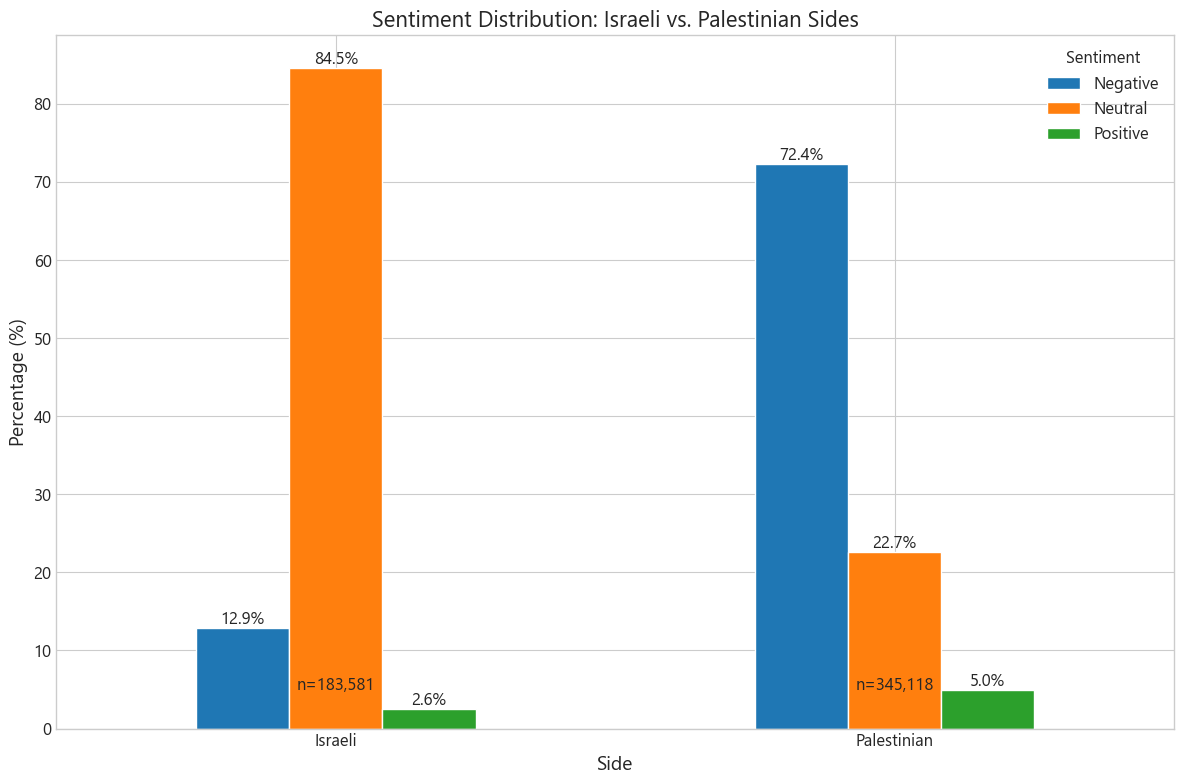

Chi-square test for sentiment differences between sides:
Chi-square statistic: 187604.64
p-value: 0.00000000
The sentiment difference between Israeli and Palestinian sides is statistically significant.

Analyzing sentiment by channel type...


<Figure size 1200x600 with 0 Axes>

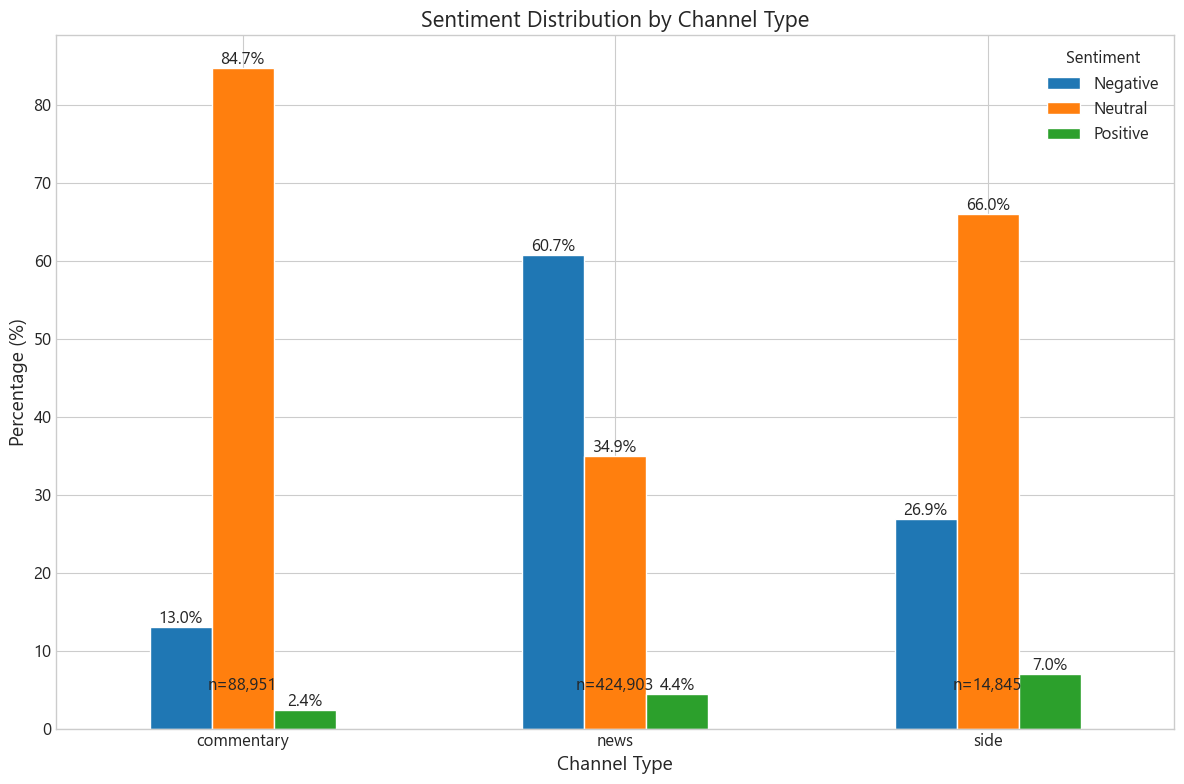

Chi-square test for sentiment differences between channel types:
Chi-square statistic: 78217.38
p-value: 0.00000000
The sentiment difference between channel types is statistically significant.

Analyzing interaction between side and channel type...


<Figure size 1400x800 with 0 Axes>

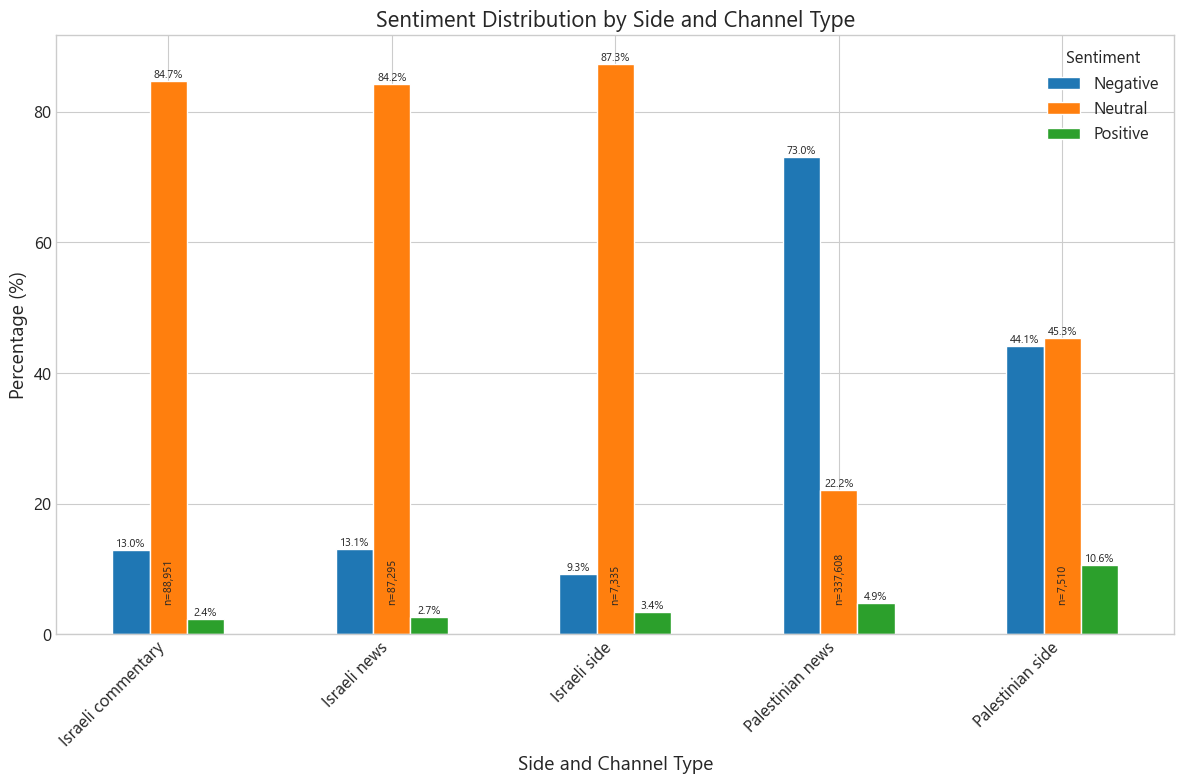

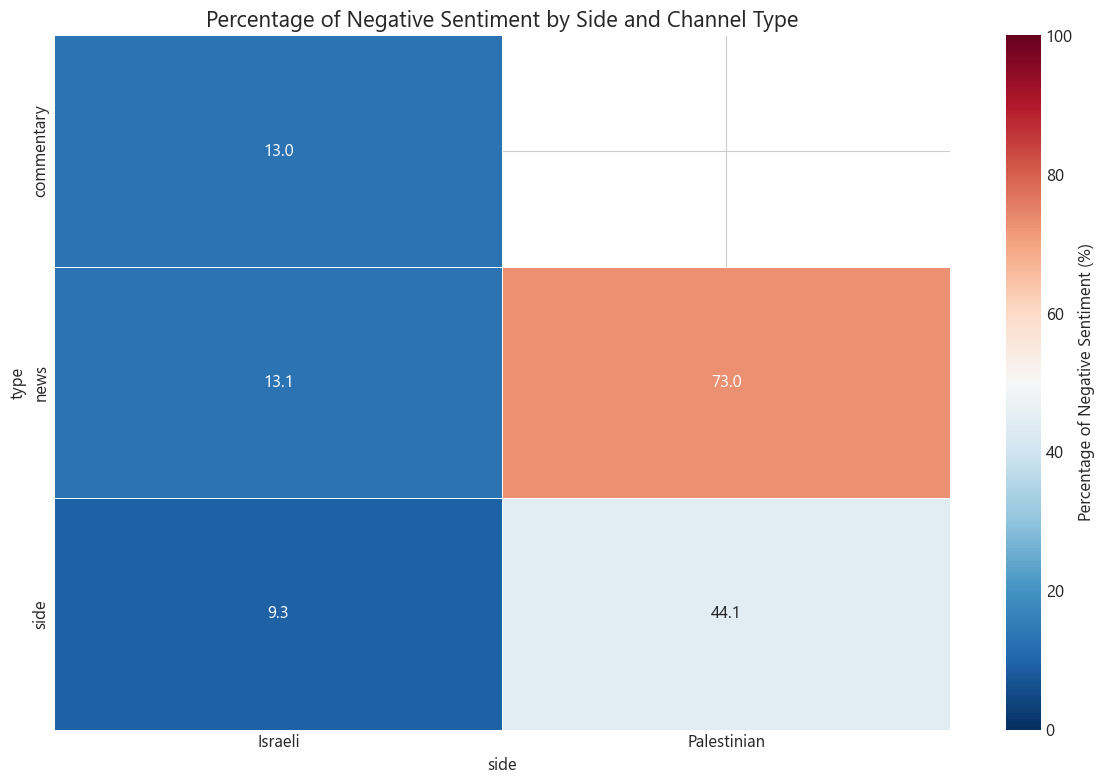


Comparing engagement metrics across sides and channel types...


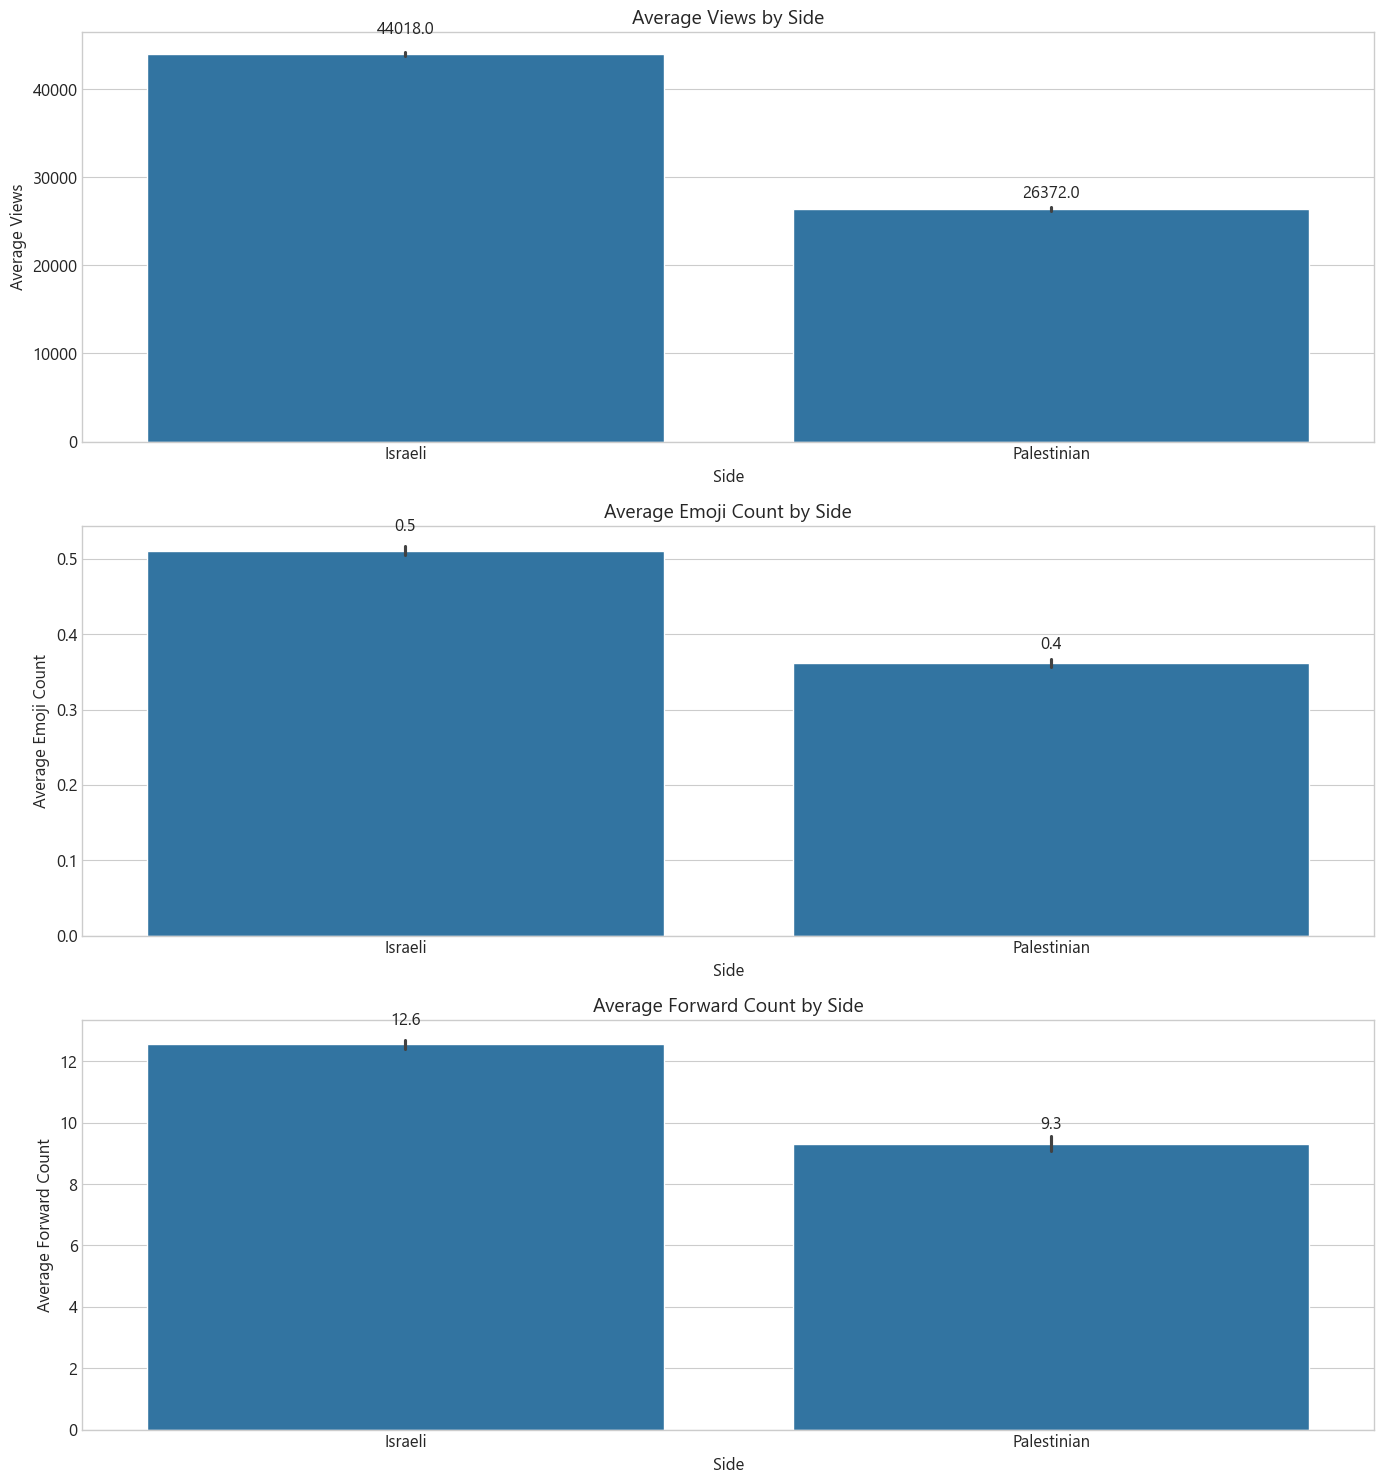

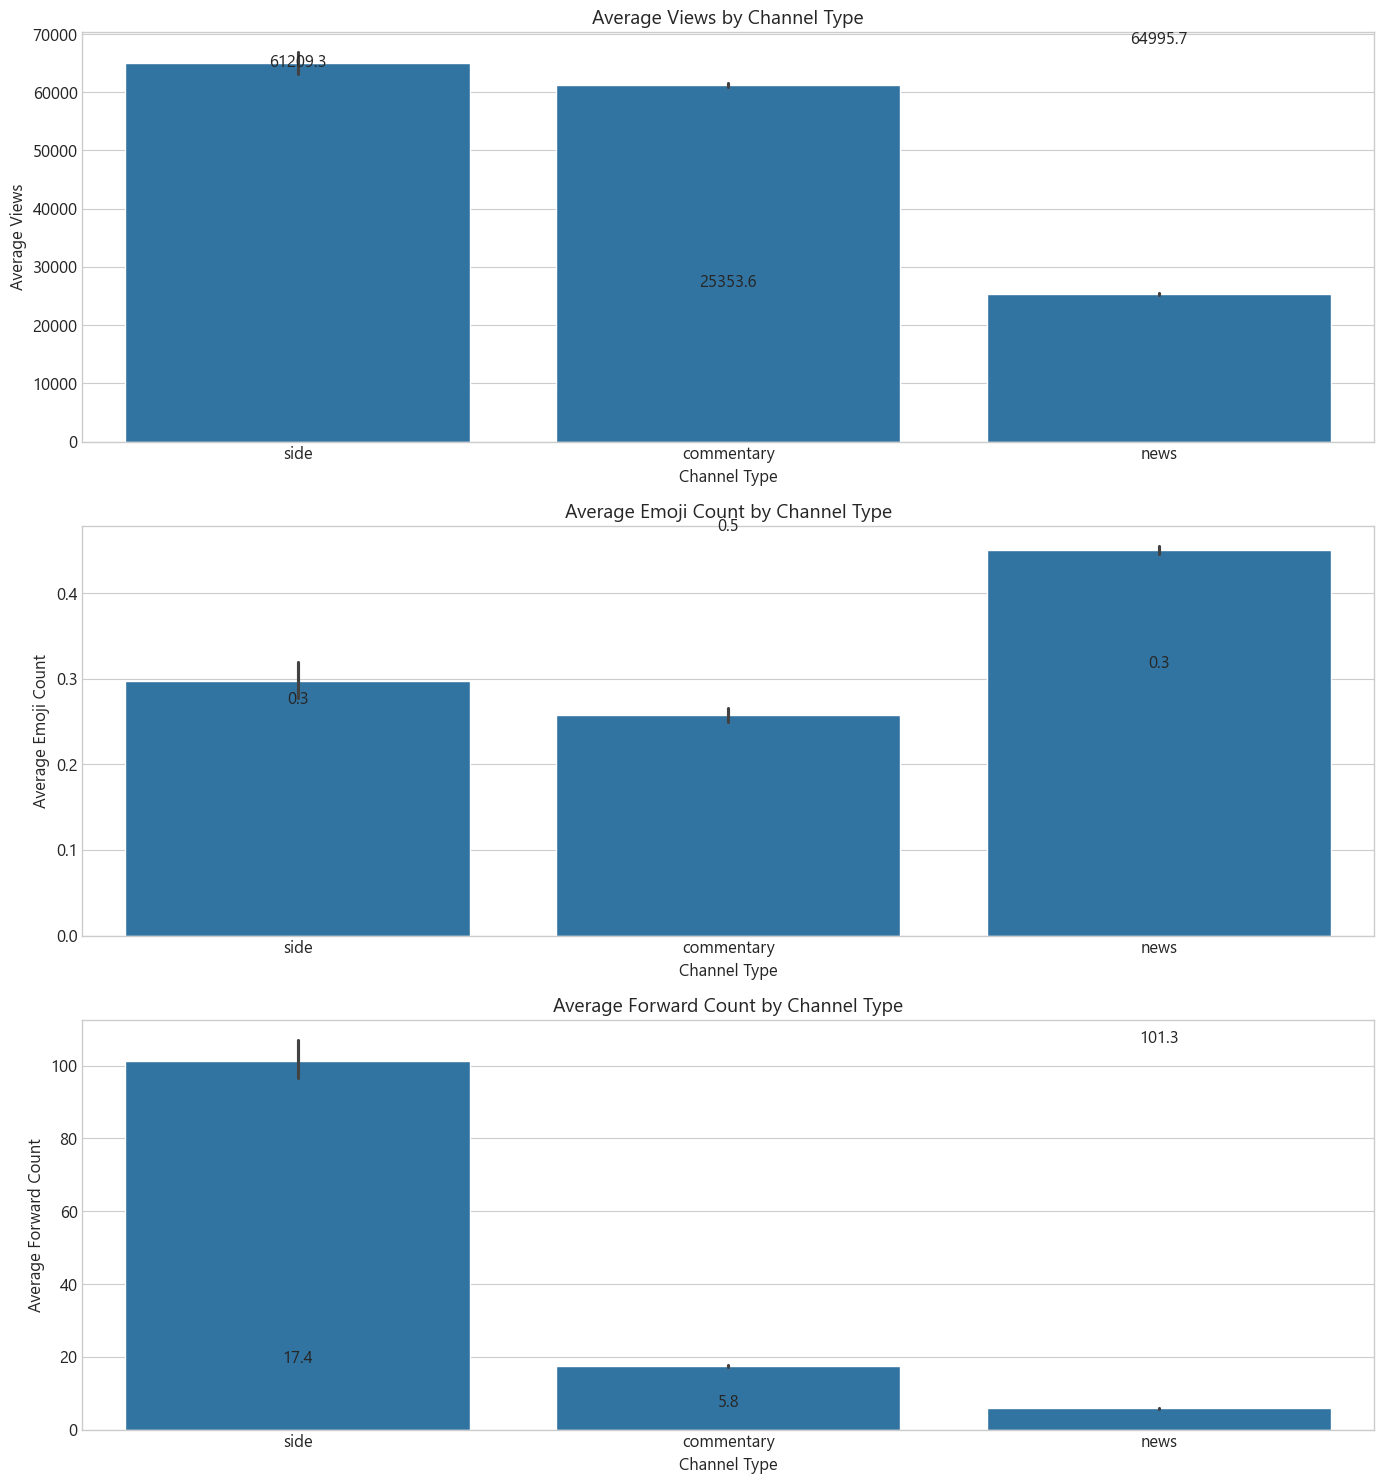

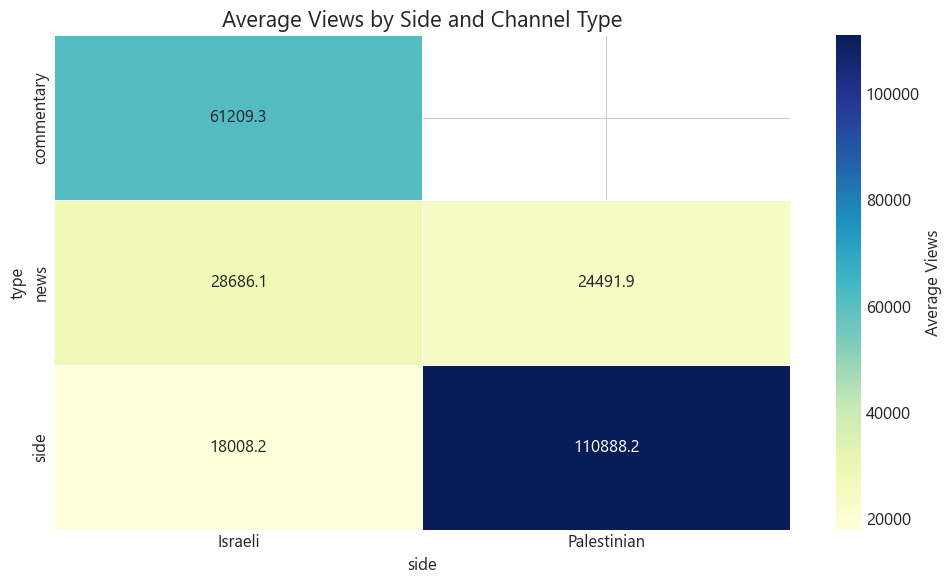


Creating comprehensive channel comparison...


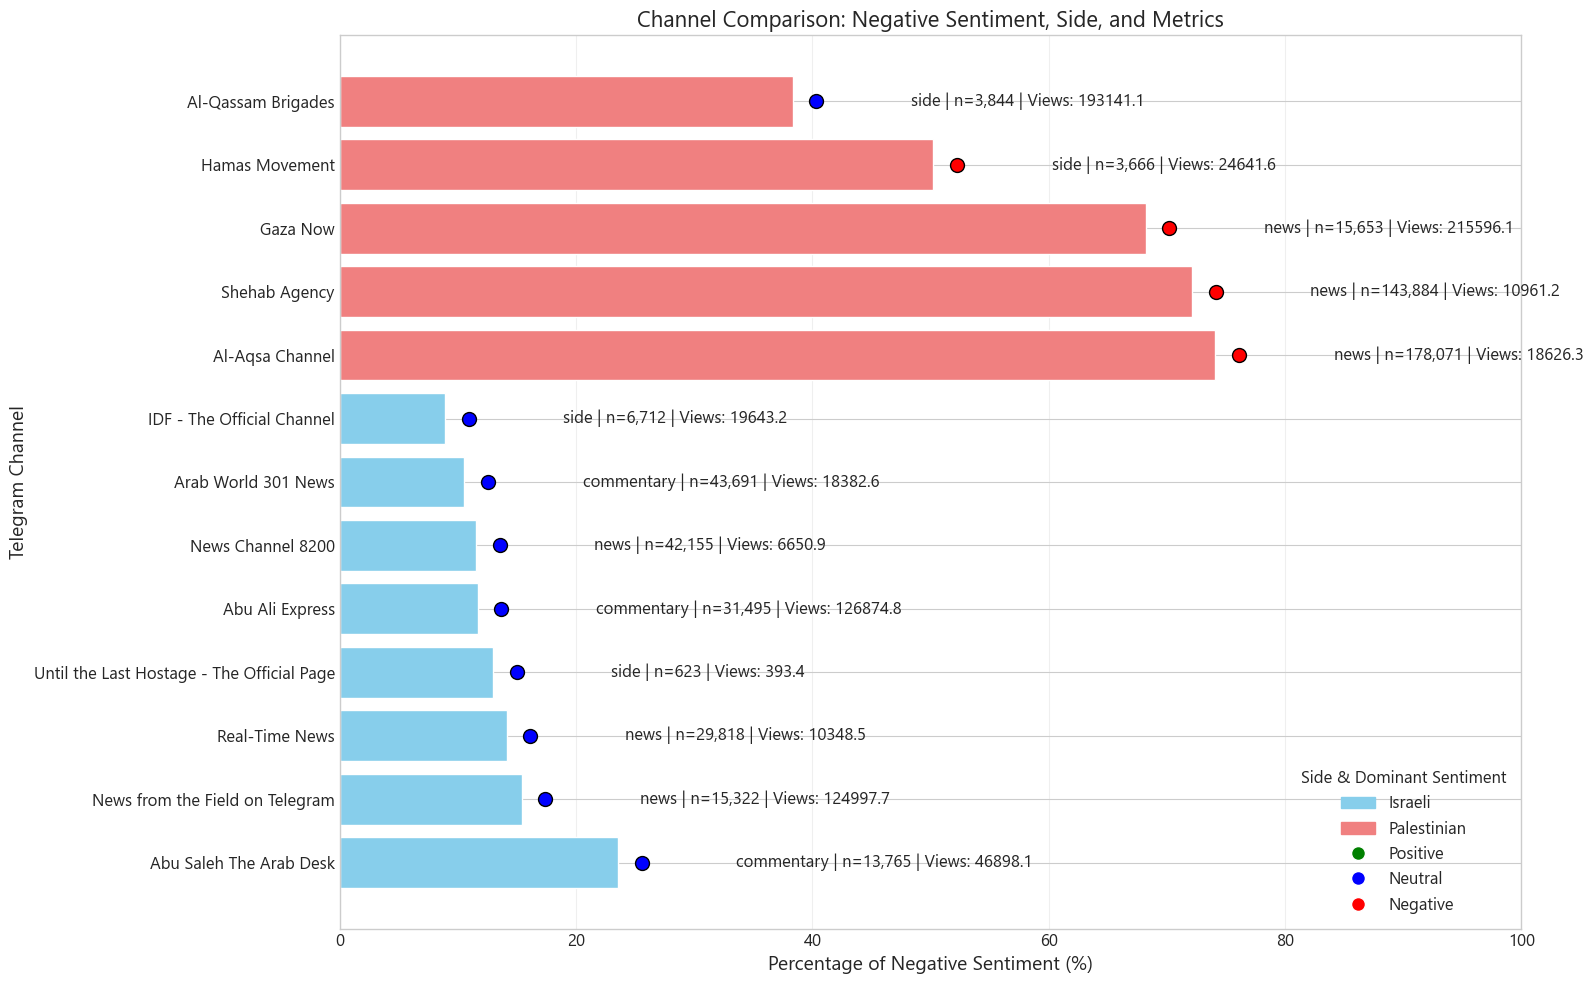

In [17]:
# Execute the analysis
comparison_results = compare_sides_and_types(df_hebrew_sentiment, df_arabic_sentiment)

In [18]:
comparison_results

{'sentiment_by_side': sentiment_label   Negative    Neutral  Positive
 side                                           
 Israeli          12.886955  84.542518  2.570527
 Palestinian      72.354093  22.658337  4.987569,
 'sentiment_by_type': sentiment_label   Negative    Neutral  Positive
 channel_type                                   
 commentary       12.964441  84.678081  2.357478
 news             60.681379  34.896200  4.422421
 side             26.918154  66.049175  7.032671,
 'sentiment_by_side_type': sentiment_label      Negative    Neutral   Positive
 side_type                                          
 Israeli commentary  12.964441  84.678081   2.357478
 Israeli news        13.110717  84.173206   2.716078
 Israeli side         9.284254  87.293797   3.421950
 Palestinian news    72.981683  22.154688   4.863629
 Palestinian side    44.141145  45.299601  10.559254,
 'channel_metrics':                                            dominant_sentiment         side  \
 group_title       